# **New York City Yellow Taxi Data**

## Objective
In this case study you will be learning exploratory data analysis (EDA) with the help of a dataset on yellow taxi rides in New York City. This will enable you to understand why EDA is an important step in the process of data science and machine learning.

## **Problem Statement**
As an analyst at an upcoming taxi operation in NYC, you are tasked to use the 2023 taxi trip data to uncover insights that could help optimise taxi operations. The goal is to analyse patterns in the data that can inform strategic decisions to improve service efficiency, maximise revenue, and enhance passenger experience.

## Tasks
You need to perform the following steps for successfully completing this assignment:
1. Data Loading
2. Data Cleaning
3. Exploratory Analysis: Bivariate and Multivariate
4. Creating Visualisations to Support the Analysis
5. Deriving Insights and Stating Conclusions

---

**NOTE:** The marks given along with headings and sub-headings are cumulative marks for those particular headings/sub-headings.<br>

The actual marks for each task are specified within the tasks themselves.

For example, marks given with heading *2* or sub-heading *2.1* are the cumulative marks, for your reference only. <br>

The marks you will receive for completing tasks are given with the tasks.

Suppose the marks for two tasks are: 3 marks for 2.1.1 and 2 marks for 3.2.2, or
* 2.1.1 [3 marks]
* 3.2.2 [2 marks]

then, you will earn 3 marks for completing task 2.1.1 and 2 marks for completing task 3.2.2.


---

## Data Understanding
The yellow taxi trip records include fields capturing pick-up and drop-off dates/times, pick-up and drop-off locations, trip distances, itemized fares, rate types, payment types, and driver-reported passenger counts.

The data is stored in Parquet format (*.parquet*). The dataset is from 2009 to 2024. However, for this assignment, we will only be using the data from 2023.

The data for each month is present in a different parquet file. You will get twelve files for each of the months in 2023.

The data was collected and provided to the NYC Taxi and Limousine Commission (TLC) by technology providers like vendors and taxi hailing apps. <br>

You can find the link to the TLC trip records page here: https://www.nyc.gov/site/tlc/about/tlc-trip-record-data.page

###  Data Description
You can find the data description here: [Data Dictionary](https://www.nyc.gov/assets/tlc/downloads/pdf/data_dictionary_trip_records_yellow.pdf)

**Trip Records**



|Field Name       |description |
|:----------------|:-----------|
| VendorID | A code indicating the TPEP provider that provided the record. <br> 1= Creative Mobile Technologies, LLC; <br> 2= VeriFone Inc. |
| tpep_pickup_datetime | The date and time when the meter was engaged.  |
| tpep_dropoff_datetime | The date and time when the meter was disengaged.   |
| Passenger_count | The number of passengers in the vehicle. <br> This is a driver-entered value. |
| Trip_distance | The elapsed trip distance in miles reported by the taximeter. |
| PULocationID | TLC Taxi Zone in which the taximeter was engaged |
| DOLocationID | TLC Taxi Zone in which the taximeter was disengaged |
|RateCodeID |The final rate code in effect at the end of the trip.<br> 1 = Standard rate <br> 2 = JFK <br> 3 = Newark <br>4 = Nassau or Westchester <br>5 = Negotiated fare <br>6 = Group ride |
|Store_and_fwd_flag |This flag indicates whether the trip record was held in vehicle memory before sending to the vendor, aka “store and forward,” because the vehicle did not have a connection to the server.  <br>Y= store and forward trip <br>N= not a store and forward trip |
|Payment_type| A numeric code signifying how the passenger paid for the trip. <br> 1 = Credit card <br>2 = Cash <br>3 = No charge <br>4 = Dispute <br>5 = Unknown <br>6 = Voided trip |
|Fare_amount| The time-and-distance fare calculated by the meter. <br>Extra Miscellaneous extras and surcharges.  Currently, this only includes the 0.50 and 1 USD rush hour and overnight charges. |
|MTA_tax |0.50 USD MTA tax that is automatically triggered based on the metered rate in use. |
|Improvement_surcharge | 0.30 USD improvement surcharge assessed trips at the flag drop. The improvement surcharge began being levied in 2015. |
|Tip_amount |Tip amount – This field is automatically populated for credit card tips. Cash tips are not included. |
| Tolls_amount | Total amount of all tolls paid in trip.  |
| total_amount | The total amount charged to passengers. Does not include cash tips. |
|Congestion_Surcharge |Total amount collected in trip for NYS congestion surcharge. |
| Airport_fee | 1.25 USD for pick up only at LaGuardia and John F. Kennedy Airports|

Although the amounts of extra charges and taxes applied are specified in the data dictionary, you will see that some cases have different values of these charges in the actual data.

**Taxi Zones**

Each of the trip records contains a field corresponding to the location of the pickup or drop-off of the trip, populated by numbers ranging from 1-263.

These numbers correspond to taxi zones, which may be downloaded as a table or map/shapefile and matched to the trip records using a join.

This is covered in more detail in later sections.

---

## **1** Data Preparation

<font color = red>[5 marks]</font> <br>

### Import Libraries

In [3]:
# Import warnings
import warnings
warnings.filterwarnings("ignore")


In [4]:
# Import the libraries you will be using for analysis

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
!pip install numpy==1.26.4

In [ ]:
!pip install pandas==2.2.2

In [ ]:
!pip install matplotlib==3.10.0

In [ ]:
!pip install seaborn==0.13.2

In [5]:
# Recommended versions
# numpy version: 1.26.4
# pandas version: 2.2.2
# matplotlib version: 3.10.0
# seaborn version: 0.13.2

# Check versions
print("numpy version:", np.__version__)
print("pandas version:", pd.__version__)
print("matplotlib version:", plt.matplotlib.__version__)
print("seaborn version:", sns.__version__)

numpy version: 1.26.4
pandas version: 2.2.2
matplotlib version: 3.9.4
seaborn version: 0.13.2


### **1.1** Load the dataset
<font color = red>[5 marks]</font> <br>

You will see twelve files, one for each month.

To read parquet files with Pandas, you have to follow a similar syntax as that for CSV files.

`df = pd.read_parquet('file.parquet')`

In [ ]:
# Try loading one file

df = pd.read_parquet('2023-1.parquet')
df.info()

How many rows are there? Do you think handling such a large number of rows is computationally feasible when we have to combine the data for all twelve months into one?

To handle this, we need to sample a fraction of data from each of the files. How to go about that? Think of a way to select only some portion of the data from each month's file that accurately represents the trends.

#### Sampling the Data
> One way is to take a small percentage of entries for pickup in every hour of a date. So, for all the days in a month, we can iterate through the hours and select 5% values randomly from those. Use `tpep_pickup_datetime` for this. Separate date and hour from the datetime values and then for each date, select some fraction of trips for each of the 24 hours.

To sample data, you can use the `sample()` method. Follow this syntax:

```Python
# sampled_data is an empty DF to keep appending sampled data of each hour
# hour_data is the DF of entries for an hour 'X' on a date 'Y'

sample = hour_data.sample(frac = 0.05, random_state = 42)
# sample 0.05 of the hour_data
# random_state is just a seed for sampling, you can define it yourself

sampled_data = pd.concat([sampled_data, sample]) # adding data for this hour to the DF
```

This *sampled_data* will contain 5% values selected at random from each hour.

Note that the code given above is only the part that will be used for sampling and not the complete code required for sampling and combining the data files.

Keep in mind that you sample by date AND hour, not just hour. (Why?)

---

**1.1.1** <font color = red>[5 marks]</font> <br>
Figure out how to sample and combine the files.

**Note:** It is not mandatory to use the method specified above. While sampling, you only need to make sure that your sampled data represents the overall data of all the months accurately.

In [ ]:
# Sample the data
# It is recommmended to not load all the files at once to avoid memory overload

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
# Take a small percentage of entries from each hour of every date.
# Iterating through the monthly data:
#   read a month file -> day -> hour: append sampled data -> move to next hour -> move to next day after 24 hours -> move to next month file
# Create a single dataframe for the year combining all the monthly data

# Select the folder having data files
import os

# Select the folder having data files
os.chdir('/content/Assignments/EDA/data_NYC_Taxi/trip_records')

# Create a list of all the twelve files to read
file_list = os.listdir()

# initialise an empty dataframe
df = pd.DataFrame()


# iterate through the list of files and sample one by one:
for file_name in file_list:
    try:
        # file path for the current file
        file_path = os.path.join(os.getcwd(), file_name)

        # Reading the current file



        # We will store the sampled data for the current date in this df by appending the sampled data from each hour to this
        # After completing iteration through each date, we will append this data to the final dataframe.
        sampled_data = pd.DataFrame()

        # Loop through dates and then loop through every hour of each date

            # Iterate through each hour of the selected date

                # Sample 5% of the hourly data randomly

                # add data of this hour to the dataframe

        # Concatenate the sampled data of all the dates to a single dataframe
        df = # we initialised this empty DF earlier

    except Exception as e:
        print(f"Error reading file {file_name}: {e}")

In [ ]:
# Load data files in loop

file_list = pd.Series(["2023-1.parquet","2023-2.parquet","2023-3.parquet","2023-4.parquet","2023-5.parquet","2023-6.parquet","2023-7.parquet","2023-8.parquet","2023-9.parquet","2023-10.parquet","2023-11.parquet","2023-12.parquet"
])


In [ ]:
dfFinal = pd.DataFrame()
for file in file_list:
    print(file)
    df = pd.read_parquet(file)
    df["tpep_pickup_datetime"] = pd.to_datetime(df['tpep_pickup_datetime'])
    df["pickupdate"] = df["tpep_pickup_datetime"].dt.date
    df["pickupdate"] = df["pickupdate"].astype(str)
    df["pickuptime"] = df["tpep_pickup_datetime"].dt.time
    df["pickuptime"] = df["pickuptime"].astype(str)
    df["pickupyear"] = df["tpep_pickup_datetime"].dt.year
    df["day"] = df["tpep_pickup_datetime"].dt.day
    df["month"] = df["tpep_pickup_datetime"].dt.month
    df["hour"] = df["tpep_pickup_datetime"].dt.hour
    df["pickupyear"] = df["pickupyear"].astype(str)
    df = df[df["pickupyear"] == "2023"]
    groupByhr = df.groupby(["day","hour"])
    dfOfHrs = {f"{day}_{hour}": group for (day, hour), group in groupByhr}
    for key, value in dfOfHrs.items():
        sample = value.sample(frac = 0.05, random_state = 42)
        dfFinal = pd.concat([dfFinal, sample])

After combining the data files into one DataFrame, convert the new DataFrame to a CSV or parquet file and store it to use directly.

Ideally, you can try keeping the total entries to around 250,000 to 300,000.

In [ ]:
# Store the df in csv/parquet
dfFinal.to_parquet('NYC_TAXI.parquet')

## **2** Data Cleaning
<font color = red>[30 marks]</font> <br>

Now we can load the new data directly.

In [4]:
# Load the new data file

df = pd.read_parquet("NYC_TAXI.parquet")

In [ ]:
df.head()

In [ ]:
df.info()

#### **2.1** Fixing Columns
<font color = red>[10 marks]</font> <br>

Fix/drop any columns as you seem necessary in the below sections

**2.1.1** <font color = red>[2 marks]</font> <br>

Fix the index and drop unnecessary columns

In [5]:
# Fix the index and drop any columns that are not needed
df.reset_index(inplace=True)


In [6]:
100*df.isnull().mean()

index                     0.000000
VendorID                  0.000000
tpep_pickup_datetime      0.000000
tpep_dropoff_datetime     0.000000
passenger_count           3.420608
trip_distance             0.000000
RatecodeID                3.420608
store_and_fwd_flag        3.420608
PULocationID              0.000000
DOLocationID              0.000000
payment_type              0.000000
fare_amount               0.000000
extra                     0.000000
mta_tax                   0.000000
tip_amount                0.000000
tolls_amount              0.000000
improvement_surcharge     0.000000
total_amount              0.000000
congestion_surcharge      3.420608
airport_fee              92.170446
pickupdate                0.000000
pickuptime                0.000000
pickupyear                0.000000
day                       0.000000
month                     0.000000
hour                      0.000000
Airport_fee              11.250163
dtype: float64

In [8]:
df.drop(columns=["airport_fee"], inplace=True)

<b>[Sheeshma]</b>
Since airport_fee column has 92 percent of null values, decision taken to drop the column


**2.1.2** <font color = red>[3 marks]</font> <br>
There are two airport fee columns. This is possibly an error in naming columns. Let's see whether these can be combined into a single column.

In [9]:
# Combine the two airport fee columns

df = pd.read_parquet("NYC_TAXI.parquet")

In [10]:
df.head(4)

VendorID tpep_pickup_datetime tpep_dropoff_datetime  passenger_count  \
3703         2  2023-01-01 00:31:50   2023-01-01 00:44:17              2.0   
4166         2  2023-01-01 00:10:50   2023-01-01 00:24:12              4.0   
3847         2  2023-01-01 00:25:37   2023-01-01 00:34:52              1.0   
1882         2  2023-01-01 00:27:26   2023-01-01 00:52:20              2.0   

      trip_distance  RatecodeID store_and_fwd_flag  PULocationID  \
3703           2.85         1.0                  N           263   
4166           1.32         1.0                  N            90   
3847           3.17         1.0                  N            79   
1882           3.80         1.0                  N           142   

      DOLocationID  payment_type  ...  total_amount  congestion_surcharge  \
3703            41             1  ...         24.72                   2.5   
4166           137             1  ...         21.36                   2.5   
3847           141             1  ...         23.88                   2.5   
1882           107             2  ...         29.70                   2.5   

      airport_fee  pickupdate  pickuptime  pickupyear  day  month  hour  \
3703          0.0  2023-01-01    00:31:50        2023    1      1     0   
4166          0.0  2023-01-01    00:10:50        2023    1      1     0   
3847          0.0  2023-01-01    00:25:37        2023    1      1     0   
1882          0.0  2023-01-01    00:27:26        2023    1      1     0   

     Airport_fee  
3703         NaN  
4166         NaN  
3847         NaN  
1882         NaN  

[4 rows x 26 columns]

In [13]:
df["Airport_fee"].fillna(0, inplace=True)
df["airport_fee"].fillna(0, inplace=True)

In [15]:
df["Airport_fee"].unique()

array([ 0.  ,  1.25, -1.25,  1.75, -1.75,  1.  ])

In [16]:
df["airport_fee_sum"] = df["airport_fee"] + df["Airport_fee"]

In [17]:
df.drop(columns = ["airport_fee", "Airport_fee"], inplace=True)

**2.1.3** <font color = red>[5 marks]</font> <br>
Fix columns with negative (monetary) values

In [18]:
# check where values of fare amount are negative

df[df.fare_amount < 0]

Empty DataFrame
Columns: [VendorID, tpep_pickup_datetime, tpep_dropoff_datetime, passenger_count, trip_distance, RatecodeID, store_and_fwd_flag, PULocationID, DOLocationID, payment_type, fare_amount, extra, mta_tax, tip_amount, tolls_amount, improvement_surcharge, total_amount, congestion_surcharge, pickupdate, pickuptime, pickupyear, day, month, hour, airport_fee_sum]
Index: []

[0 rows x 25 columns]

<b>[Sheeshma]</b>
No negative fare amount

Did you notice something different in the `RatecodeID` column for above records?

In [22]:
# Analyse RatecodeID for the negative fare amounts

df.RatecodeID.isnull().mean()*100

3.4206084421306073

In [23]:
df.RatecodeID.unique()

array([ 1., nan,  2.,  5., 99.,  3.,  4.,  6.])

<b>[Sheeshma]</b>

RatecodeID had <b>3.42 percent</b> of <b>null values</b> and Outlier which is <b>99</b>

In [53]:
# Find which columns have negative values
print(df[df.extra < 0].shape)
print(df[df.mta_tax < 0].shape)
print(df[df.improvement_surcharge < 0].shape)
print(df[df.total_amount < 0].shape)
print(df[df.congestion_surcharge < 0].shape)
print(df[df.VendorID < 0].shape)
print(df[df.trip_distance < 0].shape)
print(df[df.passenger_count < 0].shape)
print(df[df.airport_fee_sum < 0].shape)


(3, 25)
(75, 25)
(80, 25)
(80, 25)
(57, 25)
(0, 25)
(0, 25)
(0, 25)
(15, 25)


<b>[Sheeshma]</b>

Analysing all above columns following columns has negative values <br>
<b>
#extra<br>
#mta_tax<br>
#improvement_surcharge<br>
#total_amount<br>
#congestion_surcharge<br>
#airport_fee_sum<br>
    </b>

In [55]:
# fix these negative values

df = df[-(df.extra < 0)]

In [59]:
df = df[-(df.mta_tax < 0)]

In [61]:
df = df[-(df.improvement_surcharge < 0)]

In [62]:
df = df[-(df.total_amount < 0)]

In [63]:
df = df[-(df.congestion_surcharge < 0)]

In [64]:
df = df[-(df.airport_fee_sum < 0)]

In [65]:
df.shape

(1896336, 25)

In [66]:
df.to_parquet('df212.parquet')

In [88]:
df = pd.read_parquet("df212.parquet")

<b>[Sheeshma]</b>

Fix the negative values by removing the negative values since the percent of negative values are very less<br>


### **2.2** Handling Missing Values
<font color = red>[10 marks]</font> <br>

**2.2.1**  <font color = red>[2 marks]</font> <br>
Find the proportion of missing values in each column




In [89]:
# Find the proportion of missing values in each column

100*df.isnull().mean()

VendorID                 0.000000
tpep_pickup_datetime     0.000000
tpep_dropoff_datetime    0.000000
passenger_count          3.420755
trip_distance            0.000000
RatecodeID               3.420755
store_and_fwd_flag       3.420755
PULocationID             0.000000
DOLocationID             0.000000
payment_type             0.000000
fare_amount              0.000000
extra                    0.000000
mta_tax                  0.000000
tip_amount               0.000000
tolls_amount             0.000000
improvement_surcharge    0.000000
total_amount             0.000000
congestion_surcharge     3.420755
pickupdate               0.000000
pickuptime               0.000000
pickupyear               0.000000
day                      0.000000
month                    0.000000
hour                     0.000000
airport_fee_sum          0.000000
dtype: float64

<b>[Sheeshma]</b><br> Percentage of missing values : <br>
passenger_count          3.420755<br>
RatecodeID               3.420755<br>
store_and_fwd_flag       3.420755<br>
congestion_surcharge     3.420755<br>

**2.2.2**  <font color = red>[3 marks]</font> <br>
Handling missing values in `passenger_count`

In [76]:
# Display the rows with null values
# Impute NaN values in 'passenger_count'
df[df["passenger_count"].isnull()]


VendorID tpep_pickup_datetime tpep_dropoff_datetime  passenger_count  \
2995366         2  2023-01-01 00:59:15   2023-01-01 01:23:15              NaN   
2995166         2  2023-01-01 00:39:50   2023-01-01 00:54:29              NaN   
2995026         2  2023-01-01 00:43:47   2023-01-01 00:56:12              NaN   
2995233         2  2023-01-01 00:33:00   2023-01-01 01:01:00              NaN   
2995039         2  2023-01-01 00:33:00   2023-01-01 00:57:00              NaN   
...           ...                  ...                   ...              ...   
3376345         2  2023-12-31 23:09:34   2023-12-31 23:36:00              NaN   
3376187         2  2023-12-31 23:05:26   2023-12-31 23:18:01              NaN   
3376077         2  2023-12-31 23:38:22   2024-01-01 00:02:48              NaN   
3376414         2  2023-12-31 23:35:59   2023-12-31 23:39:21              NaN   
3376497         1  2023-12-31 23:12:30   2023-12-31 23:21:12              NaN   

         trip_distance  RatecodeID store_and_fwd_flag  PULocationID  \
2995366           7.97         NaN               None           140   
2995166           7.53         NaN               None           213   
2995026           5.36         NaN               None            88   
2995233           6.90         NaN               None            45   
2995039           5.11         NaN               None           255   
...                ...         ...                ...           ...   
3376345           4.10         NaN               None           140   
3376187           3.24         NaN               None           229   
3376077           8.38         NaN               None           244   
3376414           0.76         NaN               None           141   
3376497           0.00         NaN               None           166   

         DOLocationID  payment_type  ...  improvement_surcharge  total_amount  \
2995366            17             0  ...                    1.0         49.00   
2995166             7             0  ...                    1.0         43.02   
2995026           229             0  ...                    1.0         32.79   
2995233           188             0  ...                    1.0         39.49   
2995039           229             0  ...                    1.0         33.65   
...               ...           ...  ...                    ...           ...   
3376345           249             0  ...                    1.0         27.47   
3376187           239             0  ...                    1.0         21.33   
3376077           137             0  ...                    1.0         38.93   
3376414           140             0  ...                    1.0         10.83   
3376497           244             0  ...                    1.0         16.14   

         congestion_surcharge  pickupdate  pickuptime  pickupyear  day  month  \
2995366                   NaN  2023-01-01    00:59:15        2023    1      1   
2995166                   NaN  2023-01-01    00:39:50        2023    1      1   
2995026                   NaN  2023-01-01    00:43:47        2023    1      1   
2995233                   NaN  2023-01-01    00:33:00        2023    1      1   
2995039                   NaN  2023-01-01    00:33:00        2023    1      1   
...                       ...         ...         ...         ...  ...    ...   
3376345                   NaN  2023-12-31    23:09:34        2023   31     12   
3376187                   NaN  2023-12-31    23:05:26        2023   31     12   
3376077                   NaN  2023-12-31    23:38:22        2023   31     12   
3376414                   NaN  2023-12-31    23:35:59        2023   31     12   
3376497                   NaN  2023-12-31    23:12:30        2023   31     12   

        hour airport_fee_sum  
2995366    0             0.0  
2995166    0             0.0  
2995026    0             0.0  
2995233    0             0.0  
2995039    0             0.0  
...      ...             ...  
3376345   23        

In [90]:
pMedian = df["passenger_count"].sort_values().median()

df["passenger_count"].fillna(pMedian, inplace=True)

In [91]:
df[df["passenger_count"].isnull()]

Empty DataFrame
Columns: [VendorID, tpep_pickup_datetime, tpep_dropoff_datetime, passenger_count, trip_distance, RatecodeID, store_and_fwd_flag, PULocationID, DOLocationID, payment_type, fare_amount, extra, mta_tax, tip_amount, tolls_amount, improvement_surcharge, total_amount, congestion_surcharge, pickupdate, pickuptime, pickupyear, day, month, hour, airport_fee_sum]
Index: []

[0 rows x 25 columns]

In [83]:
df[df["passenger_count"] == 0]

VendorID tpep_pickup_datetime tpep_dropoff_datetime  passenger_count  \
4511            1  2023-01-01 00:08:49   2023-01-01 00:26:15              0.0   
4380            1  2023-01-01 00:25:02   2023-01-01 00:37:23              0.0   
3084            1  2023-01-01 00:42:48   2023-01-01 00:52:02              0.0   
3355            1  2023-01-01 00:23:01   2023-01-01 00:32:42              0.0   
1499            1  2023-01-01 00:56:10   2023-01-01 01:08:18              0.0   
...           ...                  ...                   ...              ...   
3190594         1  2023-12-31 22:45:00   2023-12-31 23:07:43              0.0   
3191040         1  2023-12-31 22:38:04   2023-12-31 22:40:34              0.0   
3193323         1  2023-12-31 23:13:06   2023-12-31 23:17:16              0.0   
3195810         1  2023-12-31 23:44:04   2023-12-31 23:53:59              0.0   
3194610         1  2023-12-31 23:06:18   2023-12-31 23:25:09              0.0   

         trip_distance  RatecodeID store_and_fwd_flag  PULocationID  \
4511               1.5         1.0                  N           170   
4380               6.4         1.0                  N            75   
3084               1.0         1.0                  N           162   
3355               2.4         1.0                  N            43   
1499               2.0         1.0                  N           148   
...                ...         ...                ...           ...   
3190594            1.4         1.0                  N           186   
3191040            0.8         1.0                  N           107   
3193323            0.7         1.0                  N            24   
3195810            1.5         1.0                  N           229   
3194610            2.0         1.0                  N           246   

         DOLocationID  payment_type  ...  improvement_surcharge  total_amount  \
4511               43             2  ...                    1.0          21.3   
4380               79             2  ...                    1.0          30.4   
3084              161             1  ...                    1.0          16.5   
3355              166             1  ...                    1.0          20.0   
1499              264             1  ...                    1.0          22.2   
...               ...           ...  ...                    ...           ...   
3190594           186             2  ...                    1.0          24.1   
3191040           137             1  ...                    1.0          10.8   
3193323           151             1  ...                    1.0          13.3   
3195810           164             4  ...                    1.0          16.4   
3194610           143             2  ...                    1.0          23.4   

         congestion_surcharge  pickupdate  pickuptime  pickupyear  day  month  \
4511                      2.5  2023-01-01    00:08:49        2023    1      1   
4380                      2.5  2023-01-01    00:25:02        2023    1      1   
3084                      2.5  2023-01-01    00:42:48        2023    1      1   
3355                      2.5  2023-01-01    00:23:01        2023    1      1   
1499                      2.5  2023-01-01    00:56:10        2023    1      1   
...                       ...         ...         ...         ...  ...    ...   
3190594                   2.5  2023-12-31    22:45:00        2023   31     12   
3191040                   2.5  2023-12-31    22:38:04        2023   31     12   
3193323                   0.0  2023-12-31    23:13:06        2023   31     12   
3195810                   2.5  2023-12-31    23:44:04        2023   31     12   
3194610                   2.5  2023-12-31    23:06:18        2023   31     12   

        hour airport_fee_sum  
4511       0             0.0  
4380       0             0.0  
3084       0             0.0  
3355       0             0.0  
1499       0             0.0  
...      ...             ...  
3190594   22        

In [92]:
df['passenger_count'] = df['passenger_count'].apply(lambda x: pMedian if x == 0 else x)

Did you find zeroes in passenger_count? Handle these.

In [94]:
df.to_parquet('df221.parquet')

<b>[Sheeshma]</b><br>
Yes Zero passenger_count is <b>29661 </br> Replace with median

**2.2.3**  <font color = red>[2 marks]</font> <br>
Handle missing values in `RatecodeID`

In [96]:
# Fix missing values in 'RatecodeID'
df[df["RatecodeID"].isnull()]

VendorID tpep_pickup_datetime tpep_dropoff_datetime  passenger_count  \
2995366         2  2023-01-01 00:59:15   2023-01-01 01:23:15              1.0   
2995166         2  2023-01-01 00:39:50   2023-01-01 00:54:29              1.0   
2995026         2  2023-01-01 00:43:47   2023-01-01 00:56:12              1.0   
2995233         2  2023-01-01 00:33:00   2023-01-01 01:01:00              1.0   
2995039         2  2023-01-01 00:33:00   2023-01-01 00:57:00              1.0   
...           ...                  ...                   ...              ...   
3376345         2  2023-12-31 23:09:34   2023-12-31 23:36:00              1.0   
3376187         2  2023-12-31 23:05:26   2023-12-31 23:18:01              1.0   
3376077         2  2023-12-31 23:38:22   2024-01-01 00:02:48              1.0   
3376414         2  2023-12-31 23:35:59   2023-12-31 23:39:21              1.0   
3376497         1  2023-12-31 23:12:30   2023-12-31 23:21:12              1.0   

         trip_distance  RatecodeID store_and_fwd_flag  PULocationID  \
2995366           7.97         NaN               None           140   
2995166           7.53         NaN               None           213   
2995026           5.36         NaN               None            88   
2995233           6.90         NaN               None            45   
2995039           5.11         NaN               None           255   
...                ...         ...                ...           ...   
3376345           4.10         NaN               None           140   
3376187           3.24         NaN               None           229   
3376077           8.38         NaN               None           244   
3376414           0.76         NaN               None           141   
3376497           0.00         NaN               None           166   

         DOLocationID  payment_type  ...  improvement_surcharge  total_amount  \
2995366            17             0  ...                    1.0         49.00   
2995166             7             0  ...                    1.0         43.02   
2995026           229             0  ...                    1.0         32.79   
2995233           188             0  ...                    1.0         39.49   
2995039           229             0  ...                    1.0         33.65   
...               ...           ...  ...                    ...           ...   
3376345           249             0  ...                    1.0         27.47   
3376187           239             0  ...                    1.0         21.33   
3376077           137             0  ...                    1.0         38.93   
3376414           140             0  ...                    1.0         10.83   
3376497           244             0  ...                    1.0         16.14   

         congestion_surcharge  pickupdate  pickuptime  pickupyear  day  month  \
2995366                   NaN  2023-01-01    00:59:15        2023    1      1   
2995166                   NaN  2023-01-01    00:39:50        2023    1      1   
2995026                   NaN  2023-01-01    00:43:47        2023    1      1   
2995233                   NaN  2023-01-01    00:33:00        2023    1      1   
2995039                   NaN  2023-01-01    00:33:00        2023    1      1   
...                       ...         ...         ...         ...  ...    ...   
3376345                   NaN  2023-12-31    23:09:34        2023   31     12   
3376187                   NaN  2023-12-31    23:05:26        2023   31     12   
3376077                   NaN  2023-12-31    23:38:22        2023   31     12   
3376414                   NaN  2023-12-31    23:35:59        2023   31     12   
3376497                   NaN  2023-12-31    23:12:30        2023   31     12   

        hour airport_fee_sum  
2995366    0             0.0  
2995166    0             0.0  
2995026    0             0.0  
2995233    0             0.0  
2995039    0             0.0  
...      ...             ...  
3376345   23        

In [97]:
pRatecode = df["RatecodeID"].sort_values().median()

df["RatecodeID"].fillna(pRatecode, inplace=True)

In [98]:
df.to_parquet('df223.parquet')

**2.2.4**  <font color = red>[3 marks]</font> <br>
Impute NaN in `congestion_surcharge`

In [100]:
# handle null values in congestion_surcharge
df[df["congestion_surcharge"].isnull()]



VendorID tpep_pickup_datetime tpep_dropoff_datetime  passenger_count  \
2995366         2  2023-01-01 00:59:15   2023-01-01 01:23:15              1.0   
2995166         2  2023-01-01 00:39:50   2023-01-01 00:54:29              1.0   
2995026         2  2023-01-01 00:43:47   2023-01-01 00:56:12              1.0   
2995233         2  2023-01-01 00:33:00   2023-01-01 01:01:00              1.0   
2995039         2  2023-01-01 00:33:00   2023-01-01 00:57:00              1.0   
...           ...                  ...                   ...              ...   
3376345         2  2023-12-31 23:09:34   2023-12-31 23:36:00              1.0   
3376187         2  2023-12-31 23:05:26   2023-12-31 23:18:01              1.0   
3376077         2  2023-12-31 23:38:22   2024-01-01 00:02:48              1.0   
3376414         2  2023-12-31 23:35:59   2023-12-31 23:39:21              1.0   
3376497         1  2023-12-31 23:12:30   2023-12-31 23:21:12              1.0   

         trip_distance  RatecodeID store_and_fwd_flag  PULocationID  \
2995366           7.97         1.0               None           140   
2995166           7.53         1.0               None           213   
2995026           5.36         1.0               None            88   
2995233           6.90         1.0               None            45   
2995039           5.11         1.0               None           255   
...                ...         ...                ...           ...   
3376345           4.10         1.0               None           140   
3376187           3.24         1.0               None           229   
3376077           8.38         1.0               None           244   
3376414           0.76         1.0               None           141   
3376497           0.00         1.0               None           166   

         DOLocationID  payment_type  ...  improvement_surcharge  total_amount  \
2995366            17             0  ...                    1.0         49.00   
2995166             7             0  ...                    1.0         43.02   
2995026           229             0  ...                    1.0         32.79   
2995233           188             0  ...                    1.0         39.49   
2995039           229             0  ...                    1.0         33.65   
...               ...           ...  ...                    ...           ...   
3376345           249             0  ...                    1.0         27.47   
3376187           239             0  ...                    1.0         21.33   
3376077           137             0  ...                    1.0         38.93   
3376414           140             0  ...                    1.0         10.83   
3376497           244             0  ...                    1.0         16.14   

         congestion_surcharge  pickupdate  pickuptime  pickupyear  day  month  \
2995366                   NaN  2023-01-01    00:59:15        2023    1      1   
2995166                   NaN  2023-01-01    00:39:50        2023    1      1   
2995026                   NaN  2023-01-01    00:43:47        2023    1      1   
2995233                   NaN  2023-01-01    00:33:00        2023    1      1   
2995039                   NaN  2023-01-01    00:33:00        2023    1      1   
...                       ...         ...         ...         ...  ...    ...   
3376345                   NaN  2023-12-31    23:09:34        2023   31     12   
3376187                   NaN  2023-12-31    23:05:26        2023   31     12   
3376077                   NaN  2023-12-31    23:38:22        2023   31     12   
3376414                   NaN  2023-12-31    23:35:59        2023   31     12   
3376497                   NaN  2023-12-31    23:12:30        2023   31     12   

        hour airport_fee_sum  
2995366    0             0.0  
2995166    0             0.0  
2995026    0             0.0  
2995233    0             0.0  
2995039    0             0.0  
...      ...             ...  
3376345   23        

In [102]:
pCongSur = df["congestion_surcharge"].sort_values().median()

df["congestion_surcharge"].fillna(pCongSur, inplace=True)

Are there missing values in other columns? Did you find NaN values in some other set of columns? Handle those missing values below.

In [104]:
# Handle any remaining missing values

df.isnull().mean()*100

In [105]:
df[df["store_and_fwd_flag"].isnull()]

VendorID tpep_pickup_datetime tpep_dropoff_datetime  passenger_count  \
2995366         2  2023-01-01 00:59:15   2023-01-01 01:23:15              1.0   
2995166         2  2023-01-01 00:39:50   2023-01-01 00:54:29              1.0   
2995026         2  2023-01-01 00:43:47   2023-01-01 00:56:12              1.0   
2995233         2  2023-01-01 00:33:00   2023-01-01 01:01:00              1.0   
2995039         2  2023-01-01 00:33:00   2023-01-01 00:57:00              1.0   
...           ...                  ...                   ...              ...   
3376345         2  2023-12-31 23:09:34   2023-12-31 23:36:00              1.0   
3376187         2  2023-12-31 23:05:26   2023-12-31 23:18:01              1.0   
3376077         2  2023-12-31 23:38:22   2024-01-01 00:02:48              1.0   
3376414         2  2023-12-31 23:35:59   2023-12-31 23:39:21              1.0   
3376497         1  2023-12-31 23:12:30   2023-12-31 23:21:12              1.0   

         trip_distance  RatecodeID store_and_fwd_flag  PULocationID  \
2995366           7.97         1.0               None           140   
2995166           7.53         1.0               None           213   
2995026           5.36         1.0               None            88   
2995233           6.90         1.0               None            45   
2995039           5.11         1.0               None           255   
...                ...         ...                ...           ...   
3376345           4.10         1.0               None           140   
3376187           3.24         1.0               None           229   
3376077           8.38         1.0               None           244   
3376414           0.76         1.0               None           141   
3376497           0.00         1.0               None           166   

         DOLocationID  payment_type  ...  improvement_surcharge  total_amount  \
2995366            17             0  ...                    1.0         49.00   
2995166             7             0  ...                    1.0         43.02   
2995026           229             0  ...                    1.0         32.79   
2995233           188             0  ...                    1.0         39.49   
2995039           229             0  ...                    1.0         33.65   
...               ...           ...  ...                    ...           ...   
3376345           249             0  ...                    1.0         27.47   
3376187           239             0  ...                    1.0         21.33   
3376077           137             0  ...                    1.0         38.93   
3376414           140             0  ...                    1.0         10.83   
3376497           244             0  ...                    1.0         16.14   

         congestion_surcharge  pickupdate  pickuptime  pickupyear  day  month  \
2995366                   2.5  2023-01-01    00:59:15        2023    1      1   
2995166                   2.5  2023-01-01    00:39:50        2023    1      1   
2995026                   2.5  2023-01-01    00:43:47        2023    1      1   
2995233                   2.5  2023-01-01    00:33:00        2023    1      1   
2995039                   2.5  2023-01-01    00:33:00        2023    1      1   
...                       ...         ...         ...         ...  ...    ...   
3376345                   2.5  2023-12-31    23:09:34        2023   31     12   
3376187                   2.5  2023-12-31    23:05:26        2023   31     12   
3376077                   2.5  2023-12-31    23:38:22        2023   31     12   
3376414                   2.5  2023-12-31    23:35:59        2023   31     12   
3376497                   2.5  2023-12-31    23:12:30        2023   31     12   

        hour airport_fee_sum  
2995366    0             0.0  
2995166    0             0.0  
2995026    0             0.0  
2995233    0             0.0  
2995039    0             0.0  
...      ...             ...  
3376345   23        

In [110]:
modeVal = df["store_and_fwd_flag"].mode()[0]

df["store_and_fwd_flag"].fillna(modeVal, inplace=True)

In [111]:
df.to_parquet('df224.parquet')

### **2.3** Handling Outliers
<font color = red>[10 marks]</font> <br>

Before we start fixing outliers, let's perform outlier analysis.

In [119]:
# Describe the data and check if there are any potential outliers present
# Check for potential out of place values in various columns



<b>[Sheeshma]</b><br>
Boxplot to analyse outliers

In [122]:
columns = pd.Series(["trip_distance","fare_amount","extra","mta_tax","tip_amount","tolls_amount","improvement_surcharge","total_amount","congestion_surcharge","airport_fee_sum","PULocationID","DOLocationID"
])


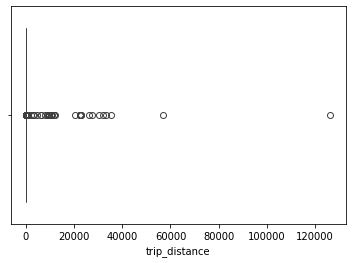

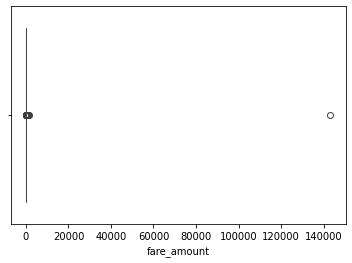

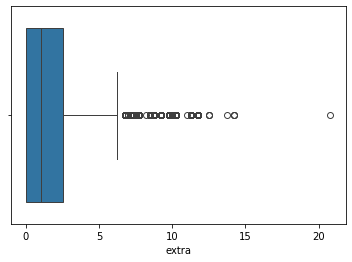

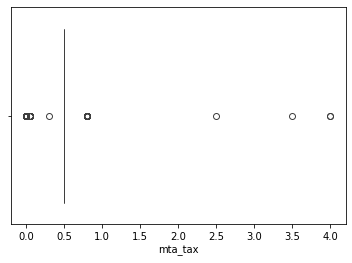

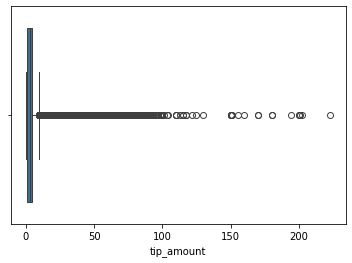

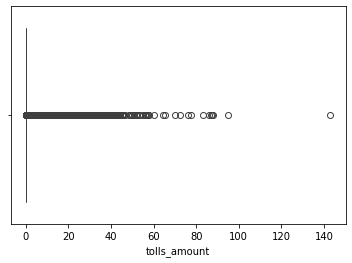

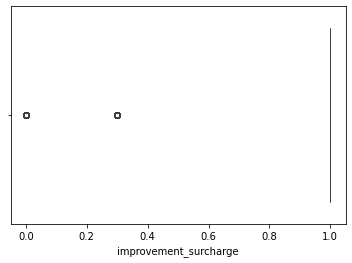

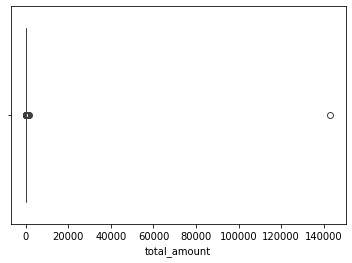

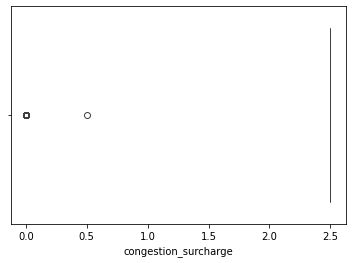

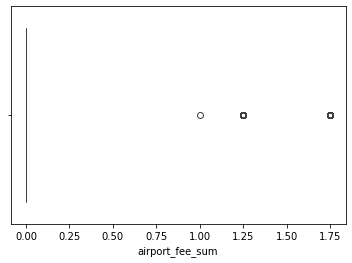

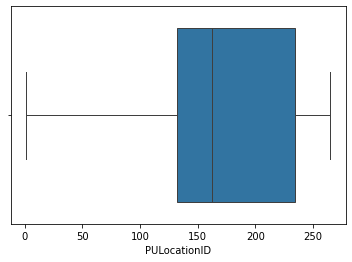

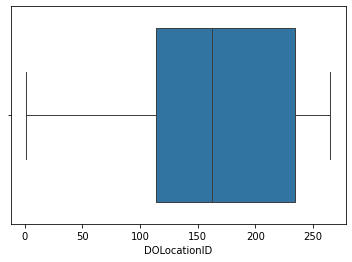

In [123]:
for col in columns:
    sns.boxplot(x=df[col])
    plt.show()

In [124]:
catcolumns = pd.Series(["passenger_count","RatecodeID","store_and_fwd_flag","payment_type"])

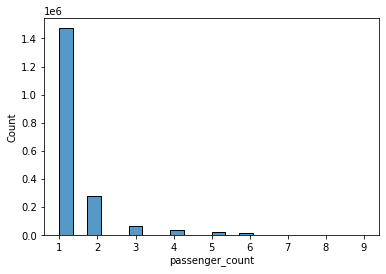

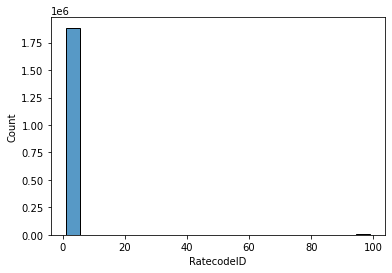

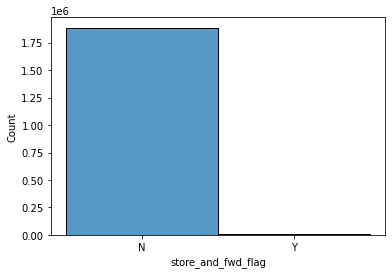

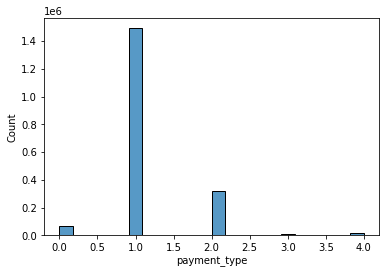

In [127]:
for col in catcolumns:
    sns.histplot(x=df[col])
    plt.show()

**2.3.1**  <font color = red>[10 marks]</font> <br>
Based on the above analysis, it seems that some of the outliers are present due to errors in registering the trips. Fix the outliers.

Some points you can look for:
- Entries where `trip_distance` is nearly 0 and `fare_amount` is more than 300
- Entries where `trip_distance` and `fare_amount` are 0 but the pickup and dropoff zones are different (both distance and fare should not be zero for different zones)
- Entries where `trip_distance` is more than 250  miles.
- Entries where `payment_type` is 0 (there is no payment_type 0 defined in the data dictionary)

These are just some suggestions. You can handle outliers in any way you wish, using the insights from above outlier analysis.

In [132]:
 df = df[-((df["trip_distance"] <= 0.5 ) & (df["fare_amount"] > 300))]

In [133]:
df = df[-((df["trip_distance"] == 0 ) & (df["fare_amount"] == 0) & (df["PULocationID"] == df["DOLocationID"]))]

In [134]:
df = df[-(df["trip_distance"] > 250)]

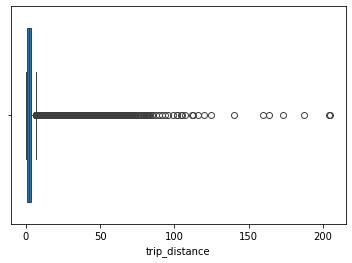

In [135]:
sns.boxplot(x=df["trip_distance"])
plt.show()

In [136]:
df.shape

(1896006, 25)

In [138]:
Q1 = df["trip_distance"].quantile(0.25)
Q3 = df["trip_distance"].quantile(0.75)
IQR = Q3-Q1
uw = Q3+(1.5*IQR)
lw = Q1-(1.5*IQR)
print(uw)
print(lw)

6.924999999999999
-2.4749999999999996


In [140]:
df = df[(df['trip_distance'] >= lw) & (df['trip_distance'] <= uw)] 

In [144]:
df = df[-(df["payment_type"] == 0)]

How will you fix each of these values? Which ones will you drop and which ones will you replace?

<b>[Sheeshma]</b><br>
Dropping outliers

First, let us remove 7+ passenger counts as there are very less instances.

In [145]:
# remove passenger_count > 6
df = df[-(df["passenger_count"] > 6)]

In [146]:
df.shape

(1591318, 25)

In [147]:
# Continue with outlier handling
totQ1 = df["total_amount"].quantile(0.25)
totQ3 = df["total_amount"].quantile(0.75)
totIQR = totQ3-totQ1
totuw = totQ3+1.5*totIQR
totlw = totQ1-1.5*totIQR

print(totuw)
print(totlw)


41.25
-0.2699999999999978


In [148]:
df = df[(df['total_amount'] >= totlw) & (df['total_amount'] <= totuw)] 

In [149]:
df.shape

(1539179, 25)

In [150]:
df.to_parquet('df231.parquet')

In [ ]:
# Do any columns need standardising?



## **3** Exploratory Data Analysis
<font color = red>[90 marks]</font> <br>

In [ ]:
df.columns.tolist()

#### **3.1** General EDA: Finding Patterns and Trends
<font color = red>[40 marks]</font> <br>

**3.1.1** <font color = red>[3 marks]</font> <br>
Categorise the varaibles into Numerical or Categorical.
* `VendorID`: Categorical
* `tpep_pickup_datetime`: Numerical
* `tpep_dropoff_datetime`: Numerical
* `passenger_count`: Categorical
* `trip_distance`: Numerical
* `RatecodeID`: Categorical
* `PULocationID`: Numerical
* `DOLocationID`: Numerical
* `payment_type`: Categorical
* `pickup_hour`: Categorical
* `trip_duration`: Numerical

The following monetary parameters belong in the same category, is it categorical or numerical?


* `fare_amount`:numerical
* `extra` : numerical
* `mta_tax`: numerical
* `tip_amount`: numerical
* `tolls_amount`: numerical
* `improvement_surcharge`: numerical
* `total_amount` : numerical
* `congestion_surcharge` : numerical
* `airport_fee`: numerical


##### Temporal Analysis

**3.1.2** <font color = red>[5 marks]</font> <br>
Analyse the distribution of taxi pickups by hours, days of the week, and months.

In [151]:
# Find and show the hourly trends in taxi pickups

taxipickupHrly = df.groupby(["hour"]).agg({"tpep_pickup_datetime":"count"})


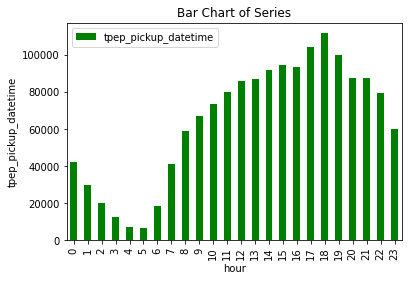

In [152]:
taxipickupHrly.plot(kind='bar', title="Bar Chart of Series", color='g')
plt.xlabel("hour")
plt.ylabel("tpep_pickup_datetime")
plt.show()

In [153]:
# Find and show the daily trends in taxi pickups (days of the week)

df["pickupday"] = df["tpep_pickup_datetime"].dt.day_name()

In [154]:
taxipickupdaily = df.groupby(["pickupday"]).agg({"tpep_pickup_datetime":"count"})


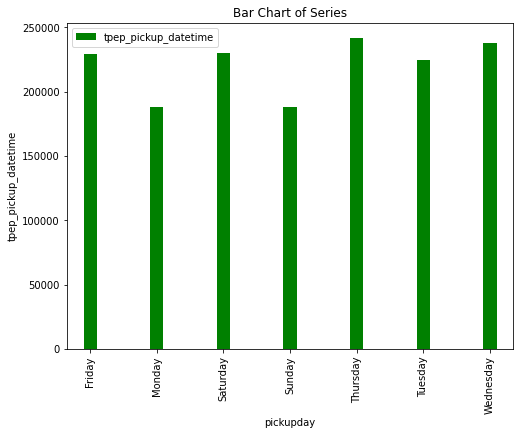

In [155]:
taxipickupdaily.plot(kind='bar', title="Bar Chart of Series",width=0.2, figsize=(8, 6), color='g')
plt.xlabel("pickupday")
plt.ylabel("tpep_pickup_datetime")
plt.show()

In [156]:
# Show the monthly trends in pickups
taxipickupmonthly = df.groupby(["month"]).agg({"tpep_pickup_datetime":"count"})



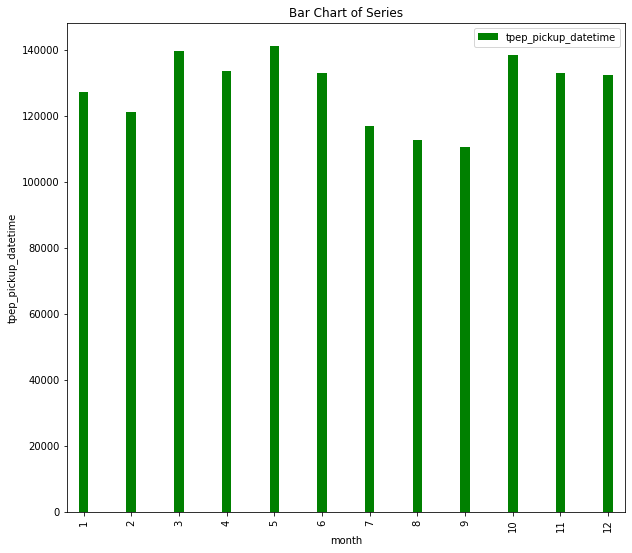

In [157]:
taxipickupmonthly.plot(kind='bar', title="Bar Chart of Series",width=0.2, figsize=(10, 9), color='g')
plt.xlabel("month")
plt.ylabel("tpep_pickup_datetime")
plt.show()

##### Financial Analysis

Take a look at the financial parameters like `fare_amount`, `tip_amount`, `total_amount`, and also `trip_distance`. Do these contain zero/negative values?

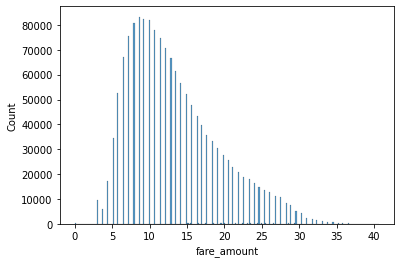

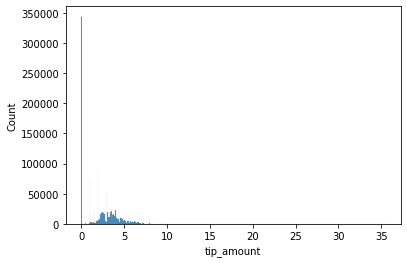

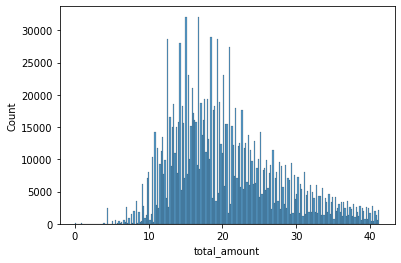

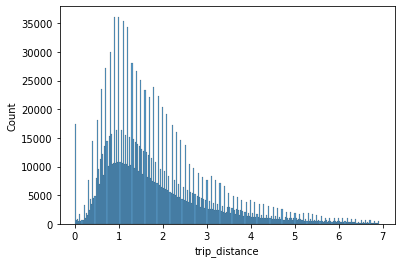

In [158]:
# Analyse the above parameters
fincolumns = pd.Series(["fare_amount","tip_amount","total_amount","trip_distance"])

for col in fincolumns:
    sns.histplot(x=df[col])
    plt.show()

Do you think it is beneficial to create a copy DataFrame leaving out the zero values from these?

In [162]:
df.shape

(1539179, 26)

<b>[Sheeshma]</b><br>
Negative values are not present as it is removed from the dataset considering amount value should never be negative<br>

Yes i feel its beneficial to remove zero for the <b>trip_distance</b>, it will not impact other fields as shown in diagrams above


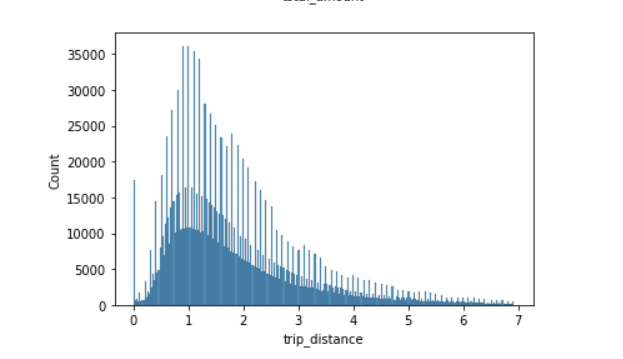

**3.1.3** <font color = red>[2 marks]</font> <br>
Filter out the zero values from the above columns.

**Note:** The distance might be 0 in cases where pickup and drop is in the same zone. Do you think it is suitable to drop such cases of zero distance?

In [165]:
# Create a df with non zero entries for the selected parameters.

df = df[-((df["PULocationID"] == df["DOLocationID"]) & (df["trip_distance"] == 0))]

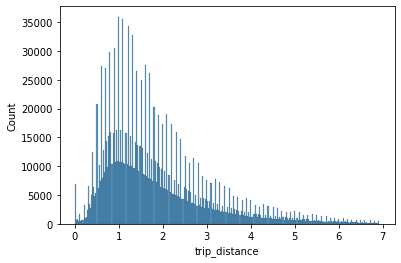

In [166]:
sns.histplot(x=df["trip_distance"])
plt.show()

**3.1.4** <font color = red>[3 marks]</font> <br>
Analyse the monthly revenue (`total_amount`) trend

In [169]:
# Group data by month and analyse monthly revenue

mon_rev = df.groupby(["month"]).agg({"total_amount":"sum"})

In [171]:
df.groupby(["month"]).agg({"total_amount":"sum"})

total_amount
month              
1        2527246.91
2        2427591.49
3        2823633.06
4        2712872.96
5        2917956.75
6        2736461.86
7        2364635.05
8        2288100.24
9        2302230.17
10       2899090.71
11       2764093.16
12       2756558.29

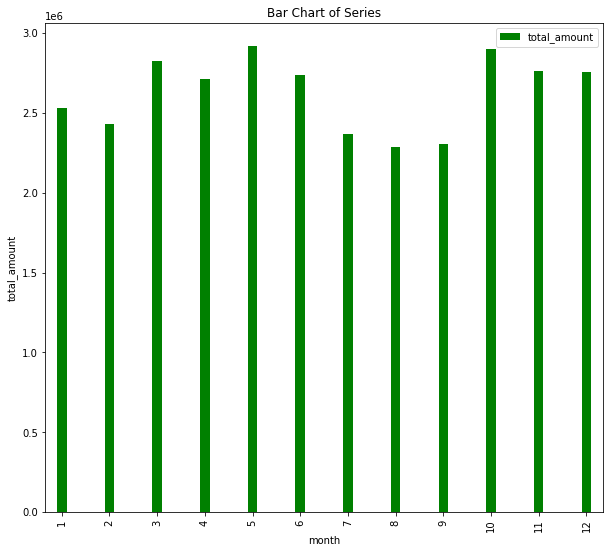

In [170]:
mon_rev.plot(kind='bar', title="Bar Chart of Series",width=0.2, figsize=(10, 9), color='g' )
plt.xlabel("month")
plt.ylabel("total_amount")
plt.show()

In [173]:

df["quarter"] = df["tpep_pickup_datetime"].dt.quarter

In [178]:
df["total_amount"].agg("sum")

31520470.650000006

**3.1.5** <font color = red>[3 marks]</font> <br>
Show the proportion of each quarter of the year in the revenue

In [181]:
# Calculate proportion of each quarter

print((df.groupby(["quarter"]).agg({"total_amount":"sum"})/df["total_amount"].agg("sum"))*100)

         total_amount
quarter              
1           24.677523
2           26.545579
3           22.064916
4           26.711981


**3.1.6** <font color = red>[3 marks]</font> <br>
Visualise the relationship between `trip_distance` and `fare_amount`. Also find the correlation value for these two.

**Hint:** You can leave out the trips with trip_distance = 0

In [188]:
df.shape

(1523038, 27)

In [186]:
df = df[-(df["trip_distance"] == 0)]

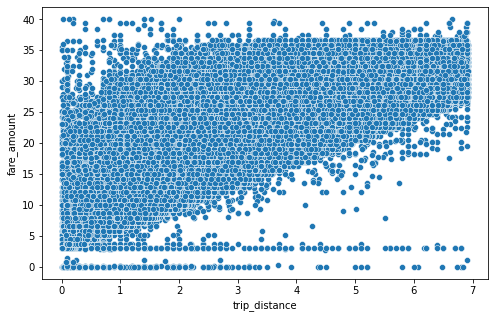

In [196]:
plt.figure(figsize=(8, 5))
sns.scatterplot(x=df['trip_distance'], y=df['fare_amount'])
plt.show()

<b>[Sheeshma]</b><br>
There is possitive relationship between fare amount and trip distance

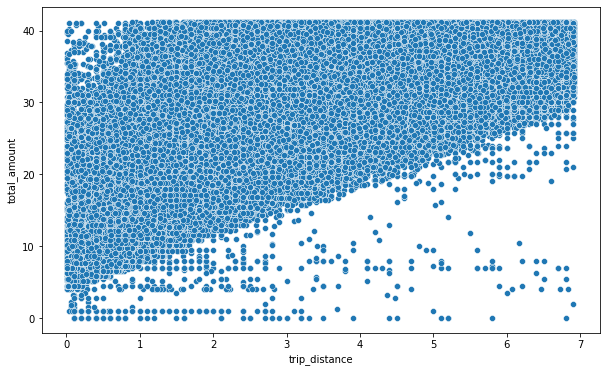

In [200]:
# Show how trip fare is affected by distance

plt.figure(figsize=(10, 6))
sns.scatterplot(x=df['trip_distance'], y=df['total_amount'])
plt.show()

<b>[Sheeshma]</b><br>
There is possitive relationship total fare amount and trip distance as well


**3.1.7** <font color = red>[5 marks]</font> <br>
Find and visualise the correlation between:
1. `fare_amount` and trip duration (pickup time to dropoff time)
2. `fare_amount` and `passenger_count`
3. `tip_amount` and `trip_distance`

In [208]:
# Show relationship between fare and trip duration
df["Duration"] = df["tpep_dropoff_datetime"] - df["tpep_pickup_datetime"]


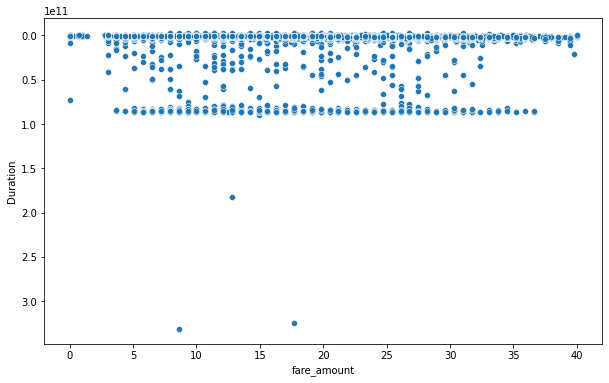

In [333]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=df['fare_amount'], y=df['Duration'])
plt.show()

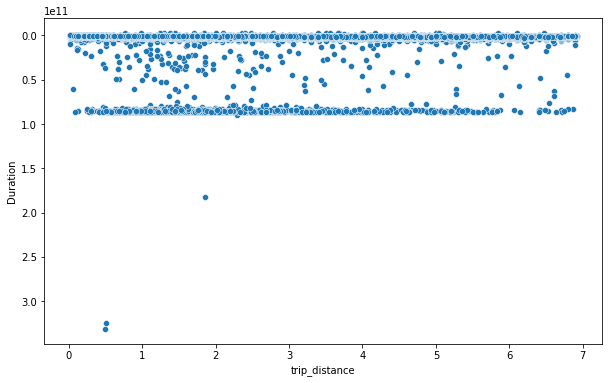

In [212]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=df['trip_distance'], y=df['Duration'])
plt.show()

<b>[Sheeshma]</b><br>
<b> Trip distance and duration</b> there is no relation

In [213]:
df.head()

VendorID tpep_pickup_datetime tpep_dropoff_datetime  passenger_count  \
3703         2  2023-01-01 00:31:50   2023-01-01 00:44:17              2.0   
4166         2  2023-01-01 00:10:50   2023-01-01 00:24:12              4.0   
3847         2  2023-01-01 00:25:37   2023-01-01 00:34:52              1.0   
1882         2  2023-01-01 00:27:26   2023-01-01 00:52:20              2.0   
4335         1  2023-01-01 00:55:02   2023-01-01 00:59:57              1.0   

      trip_distance  RatecodeID store_and_fwd_flag  PULocationID  \
3703           2.85         1.0                  N           263   
4166           1.32         1.0                  N            90   
3847           3.17         1.0                  N            79   
1882           3.80         1.0                  N           142   
4335           0.60         1.0                  N           237   

      DOLocationID  payment_type  ...  pickupdate  pickuptime  pickupyear  \
3703            41             1  ...  2023-01-01    00:31:50        2023   
4166           137             1  ...  2023-01-01    00:10:50        2023   
3847           141             1  ...  2023-01-01    00:25:37        2023   
1882           107             2  ...  2023-01-01    00:27:26        2023   
4335           237             1  ...  2023-01-01    00:55:02        2023   

      day  month  hour  airport_fee_sum  pickupday quarter        Duration  
3703    1      1     0              0.0     Sunday       1 0 days 00:12:27  
4166    1      1     0              0.0     Sunday       1 0 days 00:13:22  
3847    1      1     0              0.0     Sunday       1 0 days 00:09:15  
1882    1      1     0              0.0     Sunday       1 0 days 00:24:54  
4335    1      1     0              0.0     Sunday       1 0 days 00:04:55  

[5 rows x 28 columns]

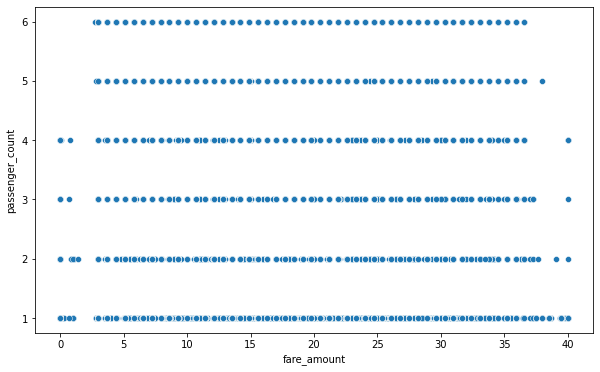

In [214]:
# Show relationship between fare and number of passengers

plt.figure(figsize=(10, 6))
sns.scatterplot(x=df['fare_amount'], y=df['passenger_count'])
plt.show()

<b>[Sheeshma]</b><br>
No relationship between <b> fare amount and passenger count</b>

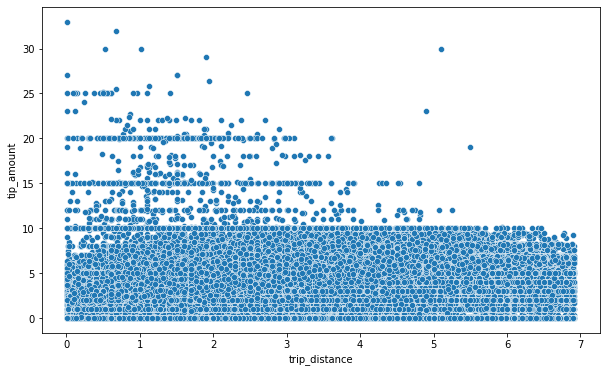

In [216]:
# Show relationship between tip and trip distance

plt.figure(figsize=(10, 6))
sns.scatterplot(x=df['trip_distance'], y=df['tip_amount'])
plt.show()

<b>[Sheeshma]</b><br>
No relationship between <b> trip_distance and tip_amount</b>

**3.1.8** <font color = red>[3 marks]</font> <br>
Analyse the distribution of different payment types (`payment_type`)

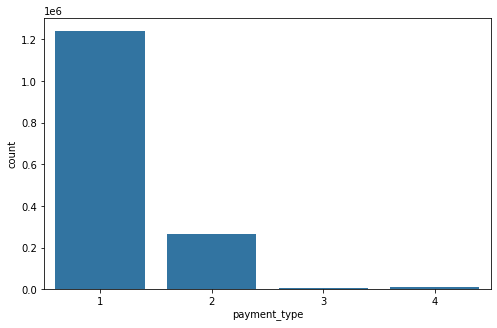

In [218]:
# Analyse the distribution of different payment types (payment_type).

plt.figure(figsize=(8, 5))
sns.countplot(x=df['payment_type'])
plt.show()


In [332]:
df.to_parquet('df318.parquet')

- 1= Credit card
- 2= Cash
- 3= No charge
- 4= Dispute



##### Geographical Analysis

For this, you have to use the *taxi_zones.shp* file from the *taxi_zones* folder.

There would be multiple files inside the folder (such as *.shx, .sbx, .sbn* etc). You do not need to import/read any of the files other than the shapefile, *taxi_zones.shp*.

Do not change any folder structure - all the files need to be present inside the folder for it to work.

The folder structure should look like this:
```
Taxi Zones
|- taxi_zones.shp.xml
|- taxi_zones.prj
|- taxi_zones.sbn
|- taxi_zones.shp
|- taxi_zones.dbf
|- taxi_zones.shx
|- taxi_zones.sbx

 ```

 You only need to read the `taxi_zones.shp` file. The *shp* file will utilise the other files by itself.

We will use the *GeoPandas* library for geopgraphical analysis
```
import geopandas as gpd
```

More about geopandas and shapefiles: [About](https://geopandas.org/en/stable/about.html)


Reading the shapefile is very similar to *Pandas*. Use `gpd.read_file()` function to load the data (*taxi_zones.shp*) as a GeoDataFrame. Documentation: [Reading and Writing Files](https://geopandas.org/en/stable/docs/user_guide/io.html)

In [219]:
!pip install geopandas

In [267]:
import geopandas as gpd

**3.1.9** <font color = red>[2 marks]</font> <br>
Load the shapefile and display it.

In [268]:
# Read the shapefile using geopandas
zones = gpd.read_file("taxi_zones.shp") 
zones.head()

OBJECTID  Shape_Leng  Shape_Area                     zone  LocationID  \
0         1    0.116357    0.000782           Newark Airport           1   
1         2    0.433470    0.004866              Jamaica Bay           2   
2         3    0.084341    0.000314  Allerton/Pelham Gardens           3   
3         4    0.043567    0.000112            Alphabet City           4   
4         5    0.092146    0.000498            Arden Heights           5   

         borough                                           geometry  
0            EWR  POLYGON ((933100.918 192536.086, 933091.011 19...  
1         Queens  MULTIPOLYGON (((1033269.244 172126.008, 103343...  
2          Bronx  POLYGON ((1026308.77 256767.698, 1026495.593 2...  
3      Manhattan  POLYGON ((992073.467 203714.076, 992068.667 20...  
4  Staten Island  POLYGON ((935843.31 144283.336, 936046.565 144...

In [264]:
df = pd.read_parquet('df318.parquet')

Now, if you look at the DataFrame created, you will see columns like: `OBJECTID`,`Shape_Leng`, `Shape_Area`, `zone`, `LocationID`, `borough`, `geometry`.
<br><br>

Now, the `locationID` here is also what we are using to mark pickup and drop zones in the trip records.

The geometric parameters like shape length, shape area and geometry are used to plot the zones on a map.

This can be easily done using the `plot()` method.

<Axes: >

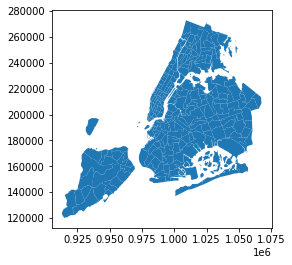

In [12]:
zones.plot()

Now, you have to merge the trip records and zones data using the location IDs.



**3.1.10** <font color = red>[3 marks]</font> <br>
Merge the zones data into trip data using the `locationID` and `PULocationID` columns.

In [265]:
# Merge zones and trip records using locationID and PULocationID

df["LocationID"] = df["PULocationID"]

In [8]:
df.shape

(1523038, 29)

In [269]:
merged_df = pd.merge(df, zones, on='LocationID', how='inner')

In [15]:
print(zones.info())


<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 263 entries, 0 to 262
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   OBJECTID    263 non-null    int32   
 1   Shape_Leng  263 non-null    float64 
 2   Shape_Area  263 non-null    float64 
 3   zone        263 non-null    object  
 4   LocationID  263 non-null    int32   
 5   borough     263 non-null    object  
 6   geometry    263 non-null    geometry
dtypes: float64(2), geometry(1), int32(2), object(2)
memory usage: 12.5+ KB
None


In [16]:
merged_df.shape

(1510345, 35)

In [163]:
merged_df.head()

VendorID tpep_pickup_datetime tpep_dropoff_datetime  passenger_count  \
0         2  2023-01-01 00:31:50   2023-01-01 00:44:17              2.0   
1         2  2023-01-01 00:10:50   2023-01-01 00:24:12              4.0   
2         2  2023-01-01 00:25:37   2023-01-01 00:34:52              1.0   
3         2  2023-01-01 00:27:26   2023-01-01 00:52:20              2.0   
4         1  2023-01-01 00:55:02   2023-01-01 00:59:57              1.0   

   trip_distance  RatecodeID store_and_fwd_flag  PULocationID  DOLocationID  \
0           2.85         1.0                  N           263            41   
1           1.32         1.0                  N            90           137   
2           3.17         1.0                  N            79           141   
3           3.80         1.0                  N           142           107   
4           0.60         1.0                  N           237           237   

   payment_type  ...  pickupday  quarter        Duration  LocationID  \
0             1  ...     Sunday        1 0 days 00:12:27         263   
1             1  ...     Sunday        1 0 days 00:13:22          90   
2             1  ...     Sunday        1 0 days 00:09:15          79   
3             2  ...     Sunday        1 0 days 00:24:54         142   
4             1  ...     Sunday        1 0 days 00:04:55         237   

   OBJECTID  Shape_Leng  Shape_Area                   zone    borough  \
0       263    0.037017    0.000066         Yorkville West  Manhattan   
1        90    0.030759    0.000055               Flatiron  Manhattan   
2        79    0.042625    0.000108           East Village  Manhattan   
3       142    0.038176    0.000076    Lincoln Square East  Manhattan   
4       237    0.042213    0.000096  Upper East Side South  Manhattan   

                                            geometry  
0  POLYGON ((997493.323 220912.386, 997355.264 22...  
1  POLYGON ((985265.129 208165.863, 985125.733 20...  
2  POLYGON ((988746.067 202151.955, 988733.885 20...  
3  POLYGON ((989380.305 218980.247, 989359.803 21...  
4  POLYGON ((993633.442 216961.016, 993507.232 21...  

[5 rows x 35 columns]

**3.1.11** <font color = red>[3 marks]</font> <br>
Group data by location IDs to find the total number of trips per location ID

In [307]:
# Group data by location and calculate the number of trips


In [244]:
agg_df = merged_df.groupby("LocationID").agg({"zone":"count"}).reset_index()

In [13]:
agg_df.columns = ['LocationID', 'LocationID_Sum']


In [166]:
agg_df

LocationID  LocationID_Sum
0             1              14
1             3              19
2             4            1690
3             6              18
4             7             627
..          ...             ...
234         259              13
235         260             203
236         261            7433
237         262           21968
238         263           32426

[239 rows x 2 columns]

**3.1.12** <font color = red>[2 marks]</font> <br>
Now, use the grouped data to add number of trips to the GeoDataFrame.

We will use this to plot a map of zones showing total trips per zone.


In [14]:
# Merge trip counts back to the zones GeoDataFrame

mergedzones_df = pd.merge(zones, agg_df, on='LocationID', how='inner')

In [12]:
mergedzones_df.head()

OBJECTID  Shape_Leng  Shape_Area                     zone  LocationID  \
0         1    0.116357    0.000782           Newark Airport           1   
1         3    0.084341    0.000314  Allerton/Pelham Gardens           3   
2         4    0.043567    0.000112            Alphabet City           4   
3         6    0.150491    0.000606  Arrochar/Fort Wadsworth           6   
4         7    0.107417    0.000390                  Astoria           7   

         borough                                           geometry  \
0            EWR  POLYGON ((933100.918 192536.086, 933091.011 19...   
1          Bronx  POLYGON ((1026308.77 256767.698, 1026495.593 2...   
2      Manhattan  POLYGON ((992073.467 203714.076, 992068.667 20...   
3  Staten Island  POLYGON ((966568.747 158679.855, 966615.256 15...   
4         Queens  POLYGON ((1010804.218 218919.641, 1011049.165 ...   

   LocationID_Sum  
0              14  
1              19  
2            1690  
3              18  
4             627

In [169]:
mergedzones_df.shape

(240, 8)

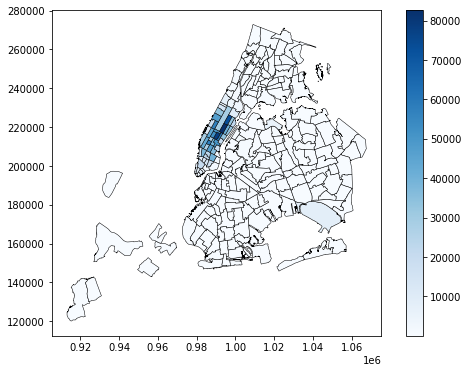

In [12]:
fig, ax = plt.subplots(figsize=(9, 6)) 
mergedzones_df.plot(column='LocationID_Sum', cmap='Blues', linewidth=0.5,edgecolor='black', legend=True, ax=ax)
plt.show()

The next step is creating a color map (choropleth map) showing zones by the number of trips taken.

Again, you can use the `zones.plot()` method for this. [Plot Method GPD](https://geopandas.org/en/stable/docs/reference/api/geopandas.GeoDataFrame.plot.html#geopandas.GeoDataFrame.plot)

But first, you need to define the figure and axis for the plot.

`fig, ax = plt.subplots(1, 1, figsize = (12, 10))`

This function creates a figure (fig) and a single subplot (ax)

---

After setting up the figure and axis, we can proceed to plot the GeoDataFrame on this axis. This is done in the next step where we use the plot method of the GeoDataFrame.

You can define the following parameters in the `zones.plot()` method:
```
column = '',
ax = ax,
legend = True,
legend_kwds = {'label': "label", 'orientation': "<horizontal/vertical>"}
```

To display the plot, use `plt.show()`.

**3.1.13** <font color = red>[3 marks]</font> <br>
Plot a color-coded map showing zone-wise trips

In [257]:
# Define figure and axis
pickup_trip = merged_df.groupby(["zone"])["zone"].count().reset_index(name="zone_count")

# Plot the map and display it

merged_pick_zones_df = pd.merge(zones, pickup_trip, on='zone', how='inner')

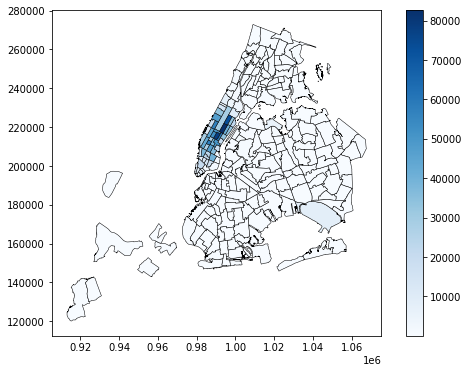

In [260]:
fig, ax = plt.subplots(figsize=(9, 6)) 
merged_pick_zones_df.plot(column='zone_count', cmap='Blues', linewidth=0.5,edgecolor='black', legend=True, ax=ax)
plt.show()

In [253]:
pickup_trip.sort_values("zone_count", ascending=False)

zone  zone_count
214         Upper East Side South       82771
144                Midtown Center       78133
213         Upper East Side North       73189
145                  Midtown East       60207
168  Penn Station/Madison Sq West       57660
..                            ...         ...
37         Charleston/Tottenville           1
100           Grymes Hill/Clifton           1
51                   Crotona Park           1
155        New Dorp/Midland Beach           1
96            Green-Wood Cemetery           1

[239 rows x 2 columns]

In [14]:
# can you try displaying the zones DF sorted by the number of trips?

mergedzones_df.sort_values("LocationID_Sum")

OBJECTID  Shape_Leng  Shape_Area                          zone  \
53         59    0.037795    0.000063                  Crotona Park   
102       115    0.116169    0.000373           Grymes Hill/Clifton   
38         44    0.235689    0.001945        Charleston/Tottenville   
98        111    0.059931    0.000209           Green-Wood Cemetery   
40         46    0.134475    0.000926                   City Island   
..        ...         ...         ...                           ...   
169       186    0.024696    0.000037  Penn Station/Madison Sq West   
147       162    0.035270    0.000048                  Midtown East   
214       236    0.044252    0.000103         Upper East Side North   
146       161    0.035804    0.000072                Midtown Center   
215       237    0.042213    0.000096         Upper East Side South   

     LocationID        borough  \
53           59          Bronx   
102         115  Staten Island   
38           44  Staten Island   
98          111       Brooklyn   
40           46          Bronx   
..          ...            ...   
169         186      Manhattan   
147         162      Manhattan   
214         236      Manhattan   
146         161      Manhattan   
215         237      Manhattan   

                                              geometry  LocationID_Sum  
53   POLYGON ((1014848.343 245121.005, 1015049.583 ...               1  
102  POLYGON ((961850.466 167915.309, 961831.926 16...               1  
38   POLYGON ((925284.273 142075.259, 924921.951 14...               1  
98   POLYGON ((985590.381 179611.82, 986202.162 179...               1  
40   MULTIPOLYGON (((1043853.395 252845.891, 104386...               1  
..                                                 ...             ...  
169  POLYGON ((986752.603 210853.699, 986627.863 21...           57661  
147  POLYGON ((992224.354 214415.293, 992096.999 21...           60209  
214  POLYGON ((995940.048 221122.92, 995812.322 220...           73191  
146  POLYGON ((991081.026 214453.698, 990952.644 21...           78135  
215  POLYGON ((993633.442 216961.016, 993507.232 21...           82775  

[240 rows x 8 columns]

In [15]:
mergedzones_df.to_parquet('mergedzones_df.parquet')

Here we have completed the temporal, financial and geographical analysis on the trip records.

**Compile your findings from general analysis below:**

You can consider the following points:

* Busiest hours, days and months
* Trends in revenue collected
* Trends in quarterly revenue
* How fare depends on trip distance, trip duration and passenger counts
* How tip amount depends on trip distance
* Busiest zones


<b>[Sheeshma]</b><br>

Busiest hours, days and months:<br>

- Busiest hours: 18:00,17.00,19.00 <br>
- Busiest days: Thursday,Wednesday <br>
- Busiest month: May,Oct <br>

Trends in revenue collected<br>
- Revenue collection high in the month of May,Oct

Trends in quarterly revenue<br>
              
quarter1           24.677523<br>
quarter2           26.545579<br>
quarter3           22.064916<br>
quarter4           26.711981<br>

- 4th and 2nd quarter is most revenue generating quarter<br>

- There is possitive relationship between fare amount and trip distance<br>
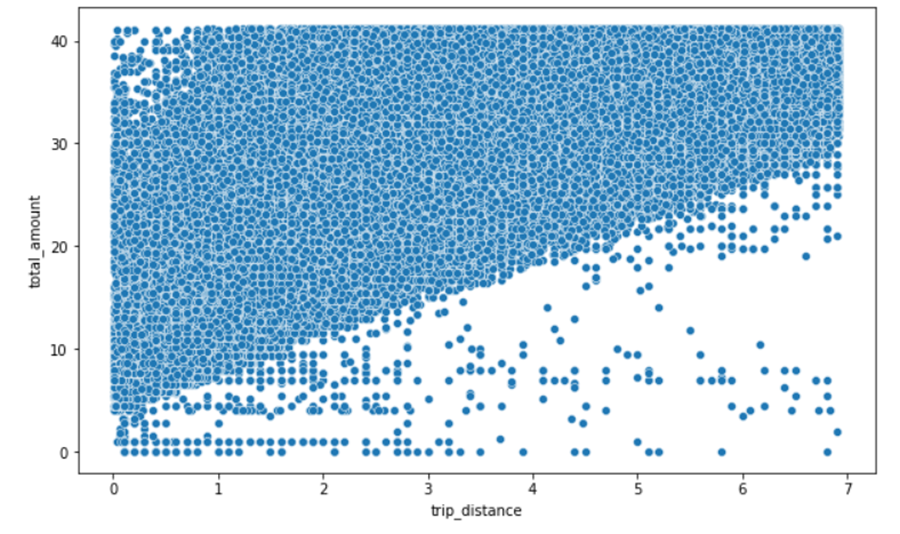
- There is no relationship between fare amount and trip duration
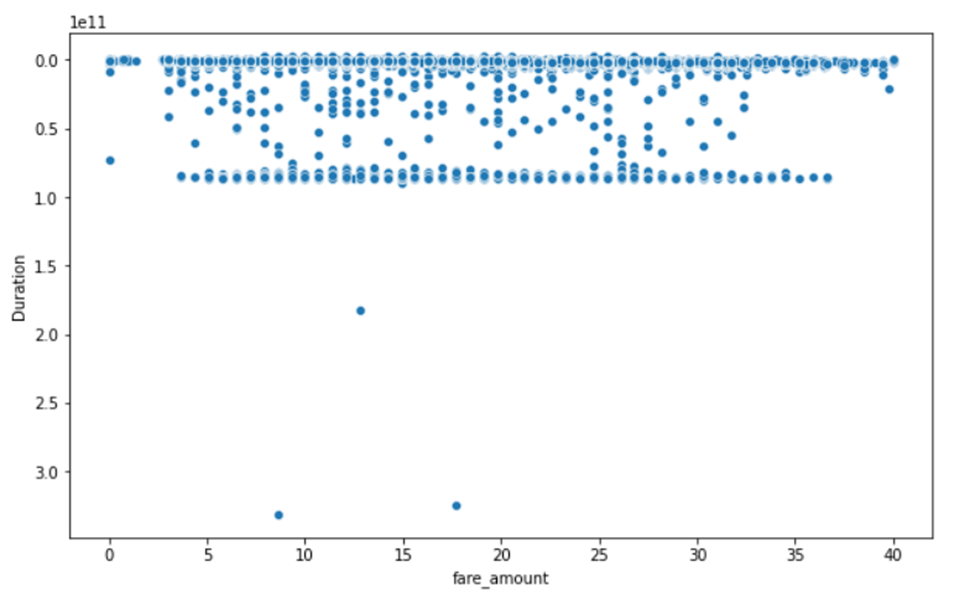
- There is no relationship between fare amount and passenger counts
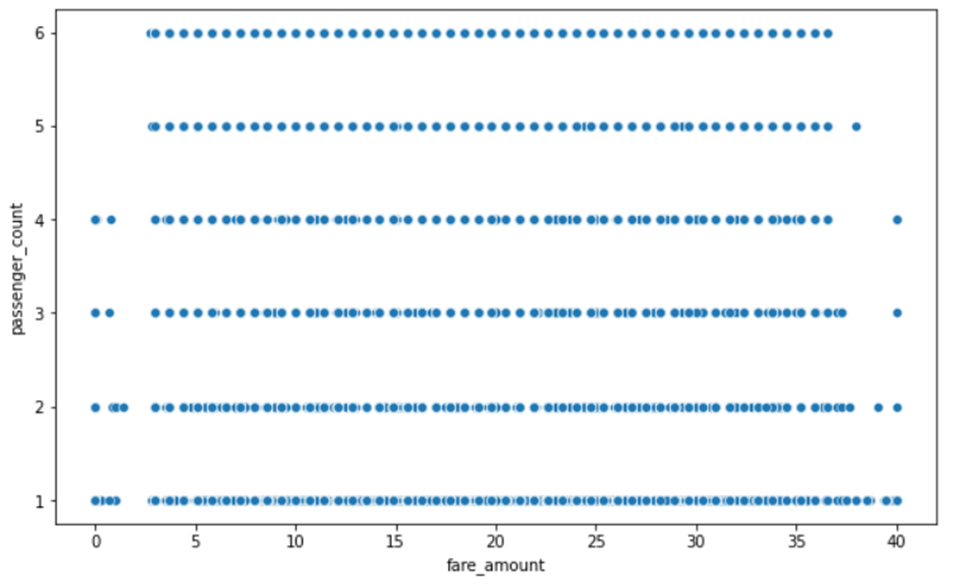

- Busiest zones are Upper East Side South, Midtown Center, Upper East Side North	, Midtown East	

#### **3.2** Detailed EDA: Insights and Strategies
<font color = red>[50 marks]</font> <br>

Having performed basic analyses for finding trends and patterns, we will now move on to some detailed analysis focussed on operational efficiency, pricing strategies, and customer experience.

##### Operational Efficiency

Analyze variations by time of day and location to identify bottlenecks or inefficiencies in routes

**3.2.1** <font color = red>[3 marks]</font> <br>
Identify slow routes by calculating the average time taken by cabs to get from one zone to another at different hours of the day.

Speed on a route *X* for hour *Y* = (*distance of the route X / average trip duration for hour Y*)

In [15]:
df = pd.read_parquet('df318.parquet')

In [172]:
mergedzones_df.head()

OBJECTID  Shape_Leng  Shape_Area                     zone  LocationID  \
0         1    0.116357    0.000782           Newark Airport           1   
1         3    0.084341    0.000314  Allerton/Pelham Gardens           3   
2         4    0.043567    0.000112            Alphabet City           4   
3         6    0.150491    0.000606  Arrochar/Fort Wadsworth           6   
4         7    0.107417    0.000390                  Astoria           7   

         borough                                           geometry  \
0            EWR  POLYGON ((933100.918 192536.086, 933091.011 19...   
1          Bronx  POLYGON ((1026308.77 256767.698, 1026495.593 2...   
2      Manhattan  POLYGON ((992073.467 203714.076, 992068.667 20...   
3  Staten Island  POLYGON ((966568.747 158679.855, 966615.256 15...   
4         Queens  POLYGON ((1010804.218 218919.641, 1011049.165 ...   

   LocationID_Sum  
0              14  
1              19  
2            1690  
3              18  
4             627

In [16]:
merged_df.head()

VendorID tpep_pickup_datetime tpep_dropoff_datetime  passenger_count  \
0         2  2023-01-01 00:31:50   2023-01-01 00:44:17              2.0   
1         2  2023-01-01 00:10:50   2023-01-01 00:24:12              4.0   
2         2  2023-01-01 00:25:37   2023-01-01 00:34:52              1.0   
3         2  2023-01-01 00:27:26   2023-01-01 00:52:20              2.0   
4         1  2023-01-01 00:55:02   2023-01-01 00:59:57              1.0   

   trip_distance  RatecodeID store_and_fwd_flag  PULocationID  DOLocationID  \
0           2.85         1.0                  N           263            41   
1           1.32         1.0                  N            90           137   
2           3.17         1.0                  N            79           141   
3           3.80         1.0                  N           142           107   
4           0.60         1.0                  N           237           237   

   payment_type  ...  pickupday  quarter        Duration  LocationID  \
0             1  ...     Sunday        1 0 days 00:12:27         263   
1             1  ...     Sunday        1 0 days 00:13:22          90   
2             1  ...     Sunday        1 0 days 00:09:15          79   
3             2  ...     Sunday        1 0 days 00:24:54         142   
4             1  ...     Sunday        1 0 days 00:04:55         237   

   OBJECTID  Shape_Leng  Shape_Area                   zone    borough  \
0       263    0.037017    0.000066         Yorkville West  Manhattan   
1        90    0.030759    0.000055               Flatiron  Manhattan   
2        79    0.042625    0.000108           East Village  Manhattan   
3       142    0.038176    0.000076    Lincoln Square East  Manhattan   
4       237    0.042213    0.000096  Upper East Side South  Manhattan   

                                            geometry  
0  POLYGON ((997493.323 220912.386, 997355.264 22...  
1  POLYGON ((985265.129 208165.863, 985125.733 20...  
2  POLYGON ((988746.067 202151.955, 988733.885 20...  
3  POLYGON ((989380.305 218980.247, 989359.803 21...  
4  POLYGON ((993633.442 216961.016, 993507.232 21...  

[5 rows x 35 columns]

In [15]:
zoneinfo = pd.read_parquet('mergedzone.parquet')

In [130]:
zoneinfo.head()

OBJECTID  Shape_Leng  Shape_Area                     zone  LocationID  \
0         1    0.116357    0.000782           Newark Airport           1   
1         3    0.084341    0.000314  Allerton/Pelham Gardens           3   
2         4    0.043567    0.000112            Alphabet City           4   
3         6    0.150491    0.000606  Arrochar/Fort Wadsworth           6   
4         7    0.107417    0.000390                  Astoria           7   

         borough                                           geometry  \
0            EWR  b'\x01\x03\x00\x00\x00\x01\x00\x00\x00\xe8\x00...   
1          Bronx  b'\x01\x03\x00\x00\x00\x01\x00\x00\x00y\x00\x0...   
2      Manhattan  b'\x01\x03\x00\x00\x00\x01\x00\x00\x00X\x00\x0...   
3  Staten Island  b'\x01\x03\x00\x00\x00\x01\x00\x00\x00\x15\x01...   
4         Queens  b'\x01\x03\x00\x00\x00\x01\x00\x00\x00\xb6\x00...   

   LocationID_Sum  
0              14  
1              19  
2            1690  
3              18  
4             627

In [17]:
merged_df = merged_df[-((merged_df["tpep_dropoff_datetime"]==merged_df["tpep_pickup_datetime"]) & (merged_df["PULocationID"] == merged_df["DOLocationID"]))]

In [18]:
merged_df.shape

(1510315, 35)

In [16]:
merged_df[merged_df["tpep_dropoff_datetime"] < merged_df["tpep_pickup_datetime"]]

VendorID tpep_pickup_datetime tpep_dropoff_datetime  passenger_count  \
489593          1  2023-08-28 12:28:00   2023-08-28 12:17:18              1.0   
499820          1  2023-08-31 11:40:00   2023-08-31 11:24:26              1.0   
995207          1  2023-07-29 11:45:00   2023-07-29 11:29:01              1.0   
1269242         2  2023-11-05 01:53:23   2023-11-05 01:02:12              2.0   
1269252         2  2023-11-05 01:53:24   2023-11-05 01:00:39              1.0   
1269260         2  2023-11-05 01:44:38   2023-11-05 01:05:43              1.0   
1269269         1  2023-11-05 01:59:01   2023-11-05 01:14:45              1.0   
1269273         1  2023-11-05 01:50:53   2023-11-05 01:02:37              1.0   
1269282         1  2023-11-05 01:59:30   2023-11-05 01:15:33              1.0   
1269296         2  2023-11-05 01:59:19   2023-11-05 01:12:55              2.0   
1269315         1  2023-11-05 01:53:06   2023-11-05 01:00:52              1.0   
1269322         1  2023-11-05 01:58:32   2023-11-05 01:13:26              2.0   
1269361         1  2023-11-05 01:52:31   2023-11-05 01:03:17              2.0   
1269378         2  2023-11-05 01:45:35   2023-11-05 01:01:45              1.0   
1269380         1  2023-11-05 01:41:16   2023-11-05 01:01:11              1.0   
1269390         2  2023-11-05 01:58:19   2023-11-05 01:20:19              1.0   
1269396         2  2023-11-05 01:58:38   2023-11-05 01:08:06              1.0   
1269407         2  2023-11-05 01:57:58   2023-11-05 01:05:33              2.0   
1269415         1  2023-11-05 01:36:34   2023-11-05 01:09:50              1.0   
1269426         1  2023-11-05 01:52:03   2023-11-05 01:00:42              1.0   
1269429         2  2023-11-05 01:58:50   2023-11-05 01:13:41              1.0   
1269431         2  2023-11-05 01:54:41   2023-11-05 01:00:23              1.0   
1269440         2  2023-11-05 01:42:53   2023-11-05 01:05:36              1.0   
1269452         2  2023-11-05 01:53:05   2023-11-05 01:07:15              1.0   
1269453         2  2023-11-05 01:47:51   2023-11-05 01:00:49              3.0   
1269483         2  2023-11-05 01:42:12   2023-11-05 01:04:24              1.0   
1269499         2  2023-11-05 01:40:43   2023-11-05 01:06:12              1.0   
1269516         2  2023-11-05 01:47:47   2023-11-05 01:05:05              1.0   
1269526         2  2023-11-05 01:51:47   2023-11-05 01:09:07              1.0   
1269537         2  2023-11-05 01:58:17   2023-11-05 01:14:41              1.0   
1269556         1  2023-11-05 01:51:19   2023-11-05 01:04:06              1.0   
1269559         2  2023-11-05 01:54:57   2023-11-05 01:03:08              1.0   
1269565         2  2023-11-05 01:59:08   2023-11-05 01:05:55              1.0   
1269567         1  2023-11-05 01:57:57   2023-11-05 01:05:21              3.0   
1269575         2  2023-11-05 01:58:09   2023-11-05 01:08:11              1.0   

         trip_distance  RatecodeID store_and_fwd_flag  PULocationID  \
489593            3.30        99.0                  N           244   
499820            1.80        99.0                  N           263   
995207            3.60        99.0                  N           213   
1269242           1.84         1.0                  N           148   
1269252           2.36         1.0                  N           162   
1269260           4.70         1.0                  N           249   
1269269           3.40         1.0                  N           186   
1269273           3.50         1.0                  N           107   
1269282           6.10         1.0                  N           151   
1269296           2.78         1.0                  N           114   
1269315           1.30         1.0                  N           234   
1269322           4.00         1.0                  N           249   
1269361           2.10         1.0                  N            50   
1269378           3.68         1.0                  N           234   
1269380           5.00     

<b>[Sheeshma]<b><br>

Based above records dropoff time is less than pickuptime considering these records are invalid, hence removing <br>

In [270]:
merged_df = merged_df[-(merged_df["tpep_dropoff_datetime"] < merged_df["tpep_pickup_datetime"])]

In [271]:
merged_df.shape

(1510310, 35)

In [272]:
# Find routes which have the slowest speeds at different times of the day

merged_df["Duration"] = merged_df["tpep_dropoff_datetime"] - merged_df["tpep_pickup_datetime"]

In [273]:
merged_df["DurationInSec"] = (merged_df["Duration"].dt.total_seconds()).astype(int)

In [274]:
merged_df["DurationInHr"] = merged_df["DurationInSec"]/3600

In [275]:
merged_df["DurationInMin"] = merged_df["DurationInSec"]/60

In [276]:
merged_df["pickupday"] = merged_df["tpep_pickup_datetime"].dt.day_name()

In [270]:
merged_df.head()

VendorID tpep_pickup_datetime tpep_dropoff_datetime  passenger_count  \
0         2  2023-01-01 00:31:50   2023-01-01 00:44:17              2.0   
1         2  2023-01-01 00:10:50   2023-01-01 00:24:12              4.0   
2         2  2023-01-01 00:25:37   2023-01-01 00:34:52              1.0   
3         2  2023-01-01 00:27:26   2023-01-01 00:52:20              2.0   
5         2  2023-01-01 00:35:52   2023-01-01 00:43:38              2.0   

   trip_distance  RatecodeID store_and_fwd_flag  PULocationID  DOLocationID  \
0           2.85         1.0                  N           263            41   
1           1.32         1.0                  N            90           137   
2           3.17         1.0                  N            79           141   
3           3.80         1.0                  N           142           107   
5           1.41         1.0                  N           161           141   

   payment_type  ...  LocationID  OBJECTID  Shape_Leng  Shape_Area  \
0             1  ...         263       263    0.037017    0.000066   
1             1  ...          90        90    0.030759    0.000055   
2             1  ...          79        79    0.042625    0.000108   
3             2  ...         142       142    0.038176    0.000076   
5             2  ...         161       161    0.035804    0.000072   

                  zone    borough  \
0       Yorkville West  Manhattan   
1             Flatiron  Manhattan   
2         East Village  Manhattan   
3  Lincoln Square East  Manhattan   
5       Midtown Center  Manhattan   

                                            geometry  DurationInSec  \
0  POLYGON ((997493.323 220912.386, 997355.264 22...            747   
1  POLYGON ((985265.129 208165.863, 985125.733 20...            802   
2  POLYGON ((988746.067 202151.955, 988733.885 20...            555   
3  POLYGON ((989380.305 218980.247, 989359.803 21...           1494   
5  POLYGON ((991081.026 214453.698, 990952.644 21...            466   

  DurationInHr DurationInMin  
0     0.207500     12.450000  
1     0.222778     13.366667  
2     0.154167      9.250000  
3     0.415000     24.900000  
5     0.129444      7.766667  

[5 rows x 38 columns]

In [277]:
route_distance = merged_df.groupby(["PULocationID","DOLocationID","hour","zone","DurationInHr"])['trip_distance'].mean().reset_index()


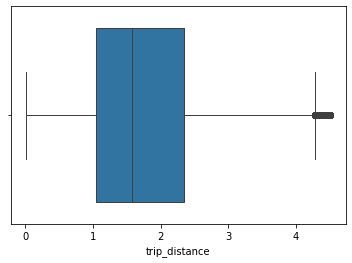

In [479]:
sns.boxplot(x=route_distance["trip_distance"])
plt.show()

In [480]:
route_distance.shape

(1284877, 6)

In [481]:
route_distance.head()

PULocationID  DOLocationID  hour                     zone  DurationInHr  \
0             3            20    10  Allerton/Pelham Gardens      0.228333   
1             3            32     9  Allerton/Pelham Gardens      0.488333   
2             3            32    11  Allerton/Pelham Gardens      0.102500   
3             3            32    17  Allerton/Pelham Gardens      0.108889   
4             3            81    10  Allerton/Pelham Gardens      0.172500   

   trip_distance  
0            2.5  
1            3.1  
2            0.9  
3            0.4  
4            1.3

In [482]:
route_distance.shape

(1284877, 6)

In [278]:
avgDuration = route_distance.groupby(["PULocationID","DOLocationID","hour","zone","trip_distance"])["DurationInHr"].mean().reset_index()

In [484]:
avgDuration.shape

(966029, 6)

In [33]:
avgDuration.head()

PULocationID  DOLocationID  hour                     zone  trip_distance  \
0             3            20    10  Allerton/Pelham Gardens            2.5   
1             3            32     9  Allerton/Pelham Gardens            3.1   
2             3            32    11  Allerton/Pelham Gardens            0.9   
3             3            32    17  Allerton/Pelham Gardens            0.4   
4             3            81    10  Allerton/Pelham Gardens            1.3   

   DurationInHr  
0      0.228333  
1      0.488333  
2      0.102500  
3      0.108889  
4      0.172500

In [34]:
route_distance[route_distance["DurationInHr"] < 0]

Empty DataFrame
Columns: [PULocationID, DOLocationID, hour, zone, DurationInHr, trip_distance]
Index: []

In [279]:
avgDuration["speed"] = avgDuration["trip_distance"]/avgDuration["DurationInHr"]

In [284]:
avgDuration.head()

PULocationID  DOLocationID  hour                     zone  trip_distance  \
0             3            20    10  Allerton/Pelham Gardens            2.5   
1             3            32     9  Allerton/Pelham Gardens            3.1   
2             3            32    11  Allerton/Pelham Gardens            0.9   
3             3            32    17  Allerton/Pelham Gardens            0.4   
4             3            81    10  Allerton/Pelham Gardens            1.3   

   DurationInHr      speed  
0      0.228333  10.948905  
1      0.488333   6.348123  
2      0.102500   8.780488  
3      0.108889   3.673469  
4      0.172500   7.536232

In [124]:
avgDuration[avgDuration["speed"] < 0]

Empty DataFrame
Columns: [PULocationID, DOLocationID, hour, trip_distance, DurationInHr, speed]
Index: []

In [282]:
avgDuration_new = avgDuration.sort_values(by='speed').head(10)

In [493]:
avgDuration_new.head(10)

PULocationID  DOLocationID  hour                       zone  \
711730           232            65    13    Two Bridges/Seward Park   
641296           226           145    18                  Sunnyside   
359228           143           116    16        Lincoln Square West   
822535           237           236     9      Upper East Side South   
318529           141           237    18            Lenox Hill West   
236914           114            79    17    Greenwich Village South   
678665           230           161    11  Times Sq/Theatre District   
911138           249           140    22               West Village   
395675           151            50    22           Manhattan Valley   
817222           237           193    19      Upper East Side South   

        trip_distance  DurationInHr     speed  
711730           0.49     92.040556  0.005324  
641296           0.50     90.183333  0.005544  
359228           0.02      2.726944  0.007334  
822535           0.25     23.723889  0.010538  
318529           0.27     23.941944  0.011277  
236914           0.31     23.102778  0.013418  
678665           0.33     23.658056  0.013949  
911138           0.01      0.670000  0.014925  
395675           0.01      0.655833  0.015248  
817222           0.01      0.643889  0.015531

In [283]:

avgDuration_new["pickupzone"] = avgDuration_new["zone"] 

In [284]:
avgDuration_new["LocationID"] = avgDuration_new["DOLocationID"] 

In [285]:
avgDuration_new.head(10)

PULocationID  DOLocationID  hour                           zone  \
462978           158           158    22  Meatpacking/West Village West   
46369             48            48    12                   Clinton East   
20816             43            43    12                   Central Park   
791484           232            65    13        Two Bridges/Seward Park   
713430           226           145    18                      Sunnyside   
406493           143           116    16            Lincoln Square West   
911001           237           236     9          Upper East Side South   
322670           140           140    13                Lenox Hill East   
362583           141           237    18                Lenox Hill West   
603784           164           164     4                  Midtown South   

        trip_distance  DurationInHr     speed                     pickupzone  \
462978           0.06     16.639444  0.003606  Meatpacking/West Village West   
46369            0.09     23.963889  0.003756                   Clinton East   
20816            0.12     23.587500  0.005087                   Central Park   
791484           0.49     92.040556  0.005324        Two Bridges/Seward Park   
713430           0.50     90.183333  0.005544                      Sunnyside   
406493           0.02      2.726944  0.007334            Lincoln Square West   
911001           0.25     23.723889  0.010538          Upper East Side South   
322670           0.25     23.077500  0.010833                Lenox Hill East   
362583           0.27     23.941944  0.011277                Lenox Hill West   
603784           0.30     23.342778  0.012852                  Midtown South   

        LocationID  
462978         158  
46369           48  
20816           43  
791484          65  
713430         145  
406493         116  
911001         236  
322670         140  
362583         237  
603784         164

In [286]:
merged_df_final = pd.merge(avgDuration_new, zones, on='LocationID', how='inner')

In [287]:
merged_df_final[["zone_x","zone_y","speed"]]

zone_x                          zone_y     speed
0  Meatpacking/West Village West   Meatpacking/West Village West  0.003606
1                   Clinton East                    Clinton East  0.003756
2                   Central Park                    Central Park  0.005087
3        Two Bridges/Seward Park     Downtown Brooklyn/MetroTech  0.005324
4                      Sunnyside  Long Island City/Hunters Point  0.005544
5            Lincoln Square West                Hamilton Heights  0.007334
6          Upper East Side South           Upper East Side North  0.010538
7                Lenox Hill East                 Lenox Hill East  0.010833
8                Lenox Hill West           Upper East Side South  0.011277
9                  Midtown South                   Midtown South  0.012852

How does identifying high-traffic, high-demand routes help us?

<b>[Sheeshma]</b><br>

Identifying high-traffic, high-demand routes helps in many ways :<br>
To plan business in perticular area<br>
To plan hospitals<br>
To manage traffic<br>
Access of logistics and delivery<br>

**3.2.2** <font color = red>[3 marks]</font> <br>
Calculate the number of trips at each hour of the day and visualise them. Find the busiest hour and show the number of trips for that hour.

In [288]:
# Visualise the number of trips per hour and find the busiest hour

hrlyTrips = merged_df.groupby(["hour"])["hour"].count().reset_index(name="count")

In [500]:
hrlyTrips.sort_values(by = "count")

hour   count
4      4    5550
5      5    5569
3      3   10484
6      6   16402
2      2   16663
1      1   25103
0      0   36185
7      7   36988
23    23   52225
8      8   52723
9      9   59868
10    10   65039
22    22   70403
11    11   70811
12    12   76078
13    13   77656
21    21   78020
20    20   78671
14    14   81780
16    16   84261
15    15   84504
19    19   90181
17    17   94485
18    18  101392

<b>[Sheeshma]</b><br>

Busiest hour is <b>18.00</b><br>

First busiest hour is 18:00 with 109906 no of trips.<br>
Second busiest hour is 17:00, with number of trips 102325<br>
Third busiest hour is 19.00 with number of trips 98203<br>



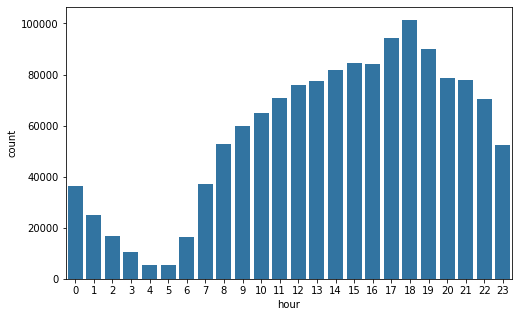

In [501]:
plt.figure(figsize=(8, 5))
sns.barplot(x=hrlyTrips["hour"],y=hrlyTrips["count"],estimator=np.max)
plt.show()

Remember, we took a fraction of trips. To find the actual number, you have to scale the number up by the sampling ratio.

**3.2.3** <font color = red>[2 mark]</font> <br>
Find the actual number of trips in the five busiest hours

In [502]:
# Scale up the number of trips

# Fill in the value of your sampling fraction and use that to scale up the numbers
sample_fraction = 0.05

hrlyTrips["sampleratio"] = hrlyTrips["count"]/sample_fraction

In [503]:
hrlyTrips.sort_values(by = "sampleratio")

hour   count  sampleratio
4      4    5550     111000.0
5      5    5569     111380.0
3      3   10484     209680.0
6      6   16402     328040.0
2      2   16663     333260.0
1      1   25103     502060.0
0      0   36185     723700.0
7      7   36988     739760.0
23    23   52225    1044500.0
8      8   52723    1054460.0
9      9   59868    1197360.0
10    10   65039    1300780.0
22    22   70403    1408060.0
11    11   70811    1416220.0
12    12   76078    1521560.0
13    13   77656    1553120.0
21    21   78020    1560400.0
20    20   78671    1573420.0
14    14   81780    1635600.0
16    16   84261    1685220.0
15    15   84504    1690080.0
19    19   90181    1803620.0
17    17   94485    1889700.0
18    18  101392    2027840.0

<b>[Sheeshma]<b><br>
    
Actual number of trips<br>
    
18.00  is  2198120.0<br>
17.00  is  2046500.0<br>
19.00  is  1964060.0<br>
    

**3.2.4** <font color = red>[3 marks]</font> <br>
Compare hourly traffic pattern on weekdays. Also compare for weekend.

In [289]:
# Compare traffic trends for the week days and weekends

merged_df.groupby(["pickupday"])["pickupday"].count().reset_index(name="count")

pickupday   count
0     Friday  224888
1     Monday  183894
2   Saturday  226071
3     Sunday  184358
4   Thursday  237173
5    Tuesday  220178
6  Wednesday  233748

In [290]:
Weekend = merged_df[merged_df["pickupday"].isin(["Sunday","Saturday"])]

In [291]:
WeekDay = merged_df[-(merged_df["pickupday"].isin(["Sunday","Saturday"]))]

In [47]:
Weekend["pickupday"].unique()

array(['Sunday', 'Saturday'], dtype=object)

In [292]:
Weekend = Weekend.groupby(["PULocationID","DOLocationID","hour","zone","DurationInHr"])['trip_distance'].mean().reset_index(name="AvgDistance")

In [293]:
Weekend = Weekend.groupby(["PULocationID","DOLocationID","hour","zone","AvgDistance"])['DurationInHr'].mean().reset_index(name="AvgTime")

In [294]:
Weekend.head()

PULocationID  DOLocationID  hour            zone  AvgDistance   AvgTime
0             1             1    15  Newark Airport         1.83  0.058056
1             1             1    17  Newark Airport         0.01  0.001389
2             1             1    17  Newark Airport         0.04  0.001111
3             1             1    19  Newark Airport         2.40  0.007222
4             1             1    20  Newark Airport         0.03  0.001111

In [295]:
WeekDay = WeekDay.groupby(["PULocationID","DOLocationID","hour","zone","DurationInHr"])['trip_distance'].mean().reset_index(name="AvgDistance")
WeekDay = WeekDay.groupby(["PULocationID","DOLocationID","hour","zone","AvgDistance"])['DurationInHr'].mean().reset_index(name="AvgTime")

In [296]:
WeekDay.shape

(808676, 6)

In [297]:
Weekend.shape

(362726, 6)

In [298]:
Weekend["speed"] = Weekend["AvgDistance"]/Weekend["AvgTime"]

In [299]:
WeekDay["speed"] = WeekDay["AvgDistance"]/WeekDay["AvgTime"]


In [513]:
Weekend.shape

(326024, 7)

In [514]:
WeekDay.shape

(732563, 7)

In [301]:
Weekend.head()

PULocationID  DOLocationID  hour            zone  AvgDistance   AvgTime  \
0             1             1    15  Newark Airport         1.83  0.058056   
1             1             1    17  Newark Airport         0.01  0.001389   
2             1             1    17  Newark Airport         0.04  0.001111   
3             1             1    19  Newark Airport         2.40  0.007222   
4             1             1    20  Newark Airport         0.03  0.001111   

        speed  
0   31.521531  
1    7.200000  
2   36.000000  
3  332.307692  
4   27.000000

In [300]:
trafficTrends = pd.merge(WeekDay, Weekend, on=["PULocationID","DOLocationID"], how='inner')

KeyboardInterrupt: 

In [ ]:
trafficTrends["route"] = trafficTrends["PULocationID"].astype(str) + trafficTrends["DOLocationID"].astype(str)

In [48]:
trafficTrends.head()

PULocationID  DOLocationID  hour_x                   zone_x  AvgDistance_x  \
0             3            32      11  Allerton/Pelham Gardens           0.90   
1             3            32      11  Allerton/Pelham Gardens           0.90   
2             4            13       6            Alphabet City           3.98   
3             4            13       6            Alphabet City           3.98   
4             4            13       6            Alphabet City           3.98   

   AvgTime_x    speed_x  hour_y                   zone_y  AvgDistance_y  \
0     0.1025   8.780488       9  Allerton/Pelham Gardens           3.10   
1     0.1025   8.780488      17  Allerton/Pelham Gardens           0.40   
2     0.1575  25.269841       0            Alphabet City           4.16   
3     0.1575  25.269841       2            Alphabet City           4.36   
4     0.1575  25.269841      14            Alphabet City           3.66   

   AvgTime_y    speed_y route  
0   0.488333   6.348123   332  
1   0.108889   3.673469   332  
2   0.191667  21.704348   413  
3   0.189722  22.980966   413  
4   0.179722  20.364760   413

In [57]:
trafficTrends["route"].dtype

dtype('O')

In [73]:
weekdaytraffic = trafficTrends.groupby(["route","zone_x"])["speed_x"].mean().reset_index(name="AvgSpeed")

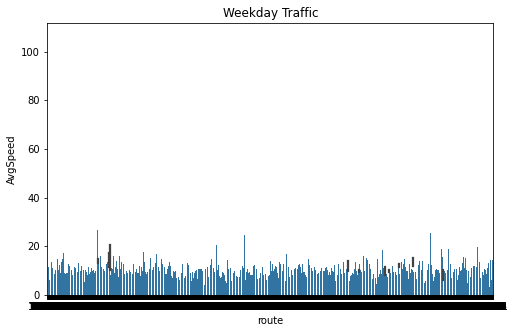

In [74]:
plt.figure(figsize=(8, 5))
sns.barplot(x=weekdaytraffic["route"],y=weekdaytraffic["AvgSpeed"],estimator=np.max)
plt.title("Weekday Traffic")
plt.show()

In [78]:
weekendtraffic = trafficTrends.groupby(["route","zone_x"])["speed_y"].mean().reset_index(name="AvgSpeed")

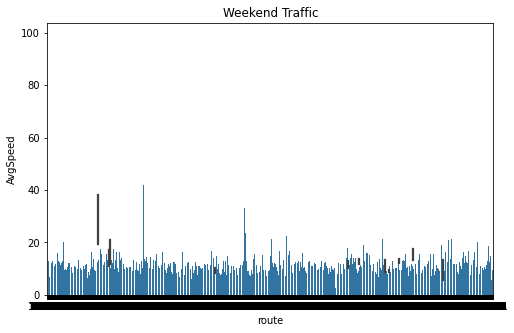

In [79]:
plt.figure(figsize=(8, 5))
sns.barplot(x=weekendtraffic["route"],y=weekendtraffic["AvgSpeed"],estimator=np.max)
plt.title("Weekend Traffic")
plt.show()

In [80]:
comparison = pd.merge(weekdaytraffic, weekendtraffic, on=["route"], how='inner')

In [81]:
comparison.head()

route          zone_x_x  AvgSpeed_x          zone_x_y  AvgSpeed_y
0  100107  Garment District    8.199537  Garment District    8.100475
1  100113  Garment District    9.213238  Garment District    9.166284
2  100114  Garment District    9.247734  Garment District    8.830179
3   10012  Garment District   11.059089  Garment District   13.282957
4  100125  Garment District   10.285492  Garment District   11.150411

In [95]:
comparison["same"] = comparison.apply(lambda row: row['AvgSpeed_x'] == row['AvgSpeed_y'], axis=1)

In [96]:
comparison["weekdayless"] = comparison.apply(lambda row: row['AvgSpeed_x'] < row['AvgSpeed_y'], axis=1)

In [97]:
comparison["weekendless"] = comparison.apply(lambda row: row['AvgSpeed_x'] > row['AvgSpeed_y'], axis=1)

In [93]:
comparison.shape

(4205, 8)

In [ ]:
comparison[comparison["weekdayless"] == True]

<b>[Sheeshma]</b><br>

Conclusion Weekday has more traffic than weekend, comparing below number in the same route.<br>

There are <b>3153 slow routes in Weekday</b> and on <b>Weekend 1052</b> slow routes only<br>



What can you infer from the above patterns? How will finding busy and quiet hours for each day help us?

<b>[Sheeshma]</b></br>

Weekeday traffic is more than weekend. Busy and quiet hours help in making stratergic business decisions, marketting, food business, staff managing, traffic controls

**3.2.5** <font color = red>[3 marks]</font> <br>
Identify top 10 zones with high hourly pickups. Do the same for hourly dropoffs. Show pickup and dropoff trends in these zones.

In [29]:
# Find top 10 pickup and dropoff zones

pickupcounts = merged_df.groupby(["hour","zone"])["hour"].count().reset_index(name="count")

In [30]:
merged_df["dropoffhour"] = merged_df["tpep_dropoff_datetime"].dt.hour

In [31]:
pickupcounts = pickupcounts.sort_values(by = "count", ascending=False).head(10)



In [32]:
dropoffcounts = merged_df.groupby(["dropoffhour","DOLocationID"])["dropoffhour"].count().reset_index(name="count")

In [33]:
merged_df.groupby(["dropoffhour","DOLocationID"])["dropoffhour"].count().reset_index(name="count")

dropoffhour  DOLocationID  count
0               0             4    421
1               0             7    325
2               0             8      3
3               0            10    114
4               0            11      1
...           ...           ...    ...
4560           23           261    352
4561           23           262   1171
4562           23           263   1645
4563           23           264    141
4564           23           265     15

[4565 rows x 3 columns]

In [34]:
dropoffcounts["LocationID"] = dropoffcounts["DOLocationID"]

In [35]:
dropoffcounts = pd.merge(dropoffcounts, zones, on='LocationID', how='inner')

In [36]:
dropoffcounts.drop(columns = ["DOLocationID","OBJECTID","Shape_Leng","Shape_Area","borough","geometry"], inplace=True)

In [38]:
dropoffcounts = dropoffcounts.sort_values(by = "count", ascending=False).head(10)


<b>[Sheeshma]</b><br>

Top 10 hourly pickup zones

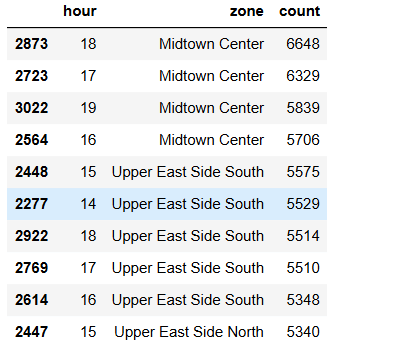


Top 10 hourly drop off zones

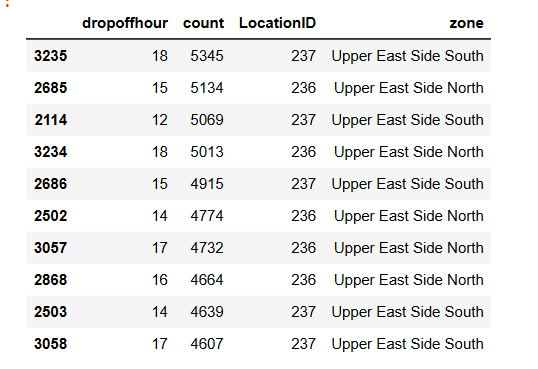


In [120]:
dropoffcounts.sort_values(by = "count", ascending=False).head(10)


dropoffhour                   zone  count
2848           18         Midtown Center   6856
2688           17         Midtown Center   6158
2998           19         Midtown Center   6140
2895           18  Upper East Side South   5691
2410           15  Upper East Side South   5676
2738           17  Upper East Side South   5580
2528           16         Midtown Center   5538
2240           14  Upper East Side South   5406
2409           15  Upper East Side North   5395
2576           16  Upper East Side South   5304

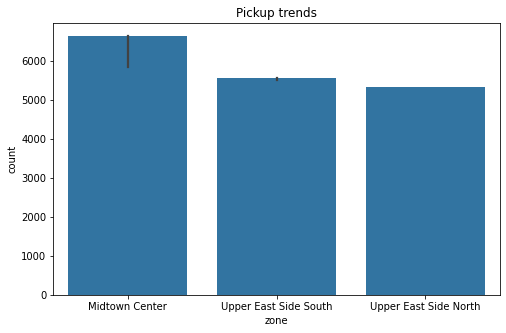

In [136]:
plt.figure(figsize=(8, 5))
sns.barplot(x=pickupcounts["zone"],y=pickupcounts["count"],estimator=np.max)
plt.title("Pickup trends")
plt.show()

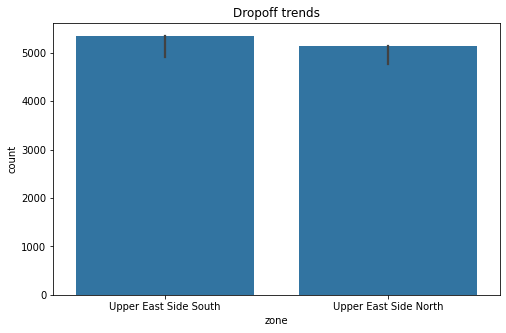

In [137]:
plt.figure(figsize=(8, 5))
sns.barplot(x=dropoffcounts["zone"],y=dropoffcounts["count"],estimator=np.max)
plt.title("Dropoff trends")
plt.show()

**3.2.6** <font color = red>[3 marks]</font> <br>
Find the ratio of pickups and dropoffs in each zone. Display the 10 highest (pickup/drop) and 10 lowest (pickup/drop) ratios.

In [159]:
# Find the top 10 and bottom 10 pickup/dropoff ratios

toppickup = merged_df.groupby(["PULocationID","zone"])["PULocationID"].count().reset_index(name="count")

In [154]:
topdropoff = merged_df.groupby(["DOLocationID"])["DOLocationID"].count().reset_index(name="count")

In [155]:
topdropoff["LocationID"] = topdropoff["DOLocationID"]

In [156]:
topdropoff = pd.merge(topdropoff, zones, on='LocationID', how='inner')

In [157]:
topdropoff.drop(columns = ["DOLocationID","OBJECTID","Shape_Leng","Shape_Area","borough","geometry"], inplace=True)


In [165]:
zoneratio.rename(columns={'count_x': 'pickupcount'}, inplace=True)

In [166]:
zoneratio.rename(columns={'count_y': 'dropoffcount'}, inplace=True)

In [171]:
zoneratio["ratio"] = zoneratio["pickupcount"]/zoneratio["dropoffcount"]

In [175]:
zoneratio.sort_values(by = "ratio", ascending=False).head(10)


PULocationID                             zone  pickupcount  dropoffcount  \
110           132                      JFK Airport         2898            49   
116           138                LaGuardia Airport         3372           230   
132           154  Marine Park/Floyd Bennett Field           11             2   
96            117                  Hammels/Arverne            7             2   
45             55                     Coney Island           12             4   
6              11                       Bath Beach            7             3   
41             51                       Co-Op City           35            16   
175           204                Rossville/Woodrow            2             1   
157           182                      Parkchester           34            18   
189           220       Spuyten Duyvil/Kingsbridge           31            17   

     LocationID      ratio  
110         132  59.142857  
116         138  14.660870  
132         154   5.500000  
96          117   3.500000  
45           55   3.000000  
6            11   2.333333  
41           51   2.187500  
175         204   2.000000  
157         182   1.888889  
189         220   1.823529

In [176]:
zoneratio.sort_values(by = "ratio", ascending=True).head(10)


PULocationID                              zone  pickupcount  \
5              10                      Baisley Park           48   
188           219         Springfield Gardens South           26   
78             92                          Flushing           26   
185           216                  South Ozone Park           51   
173           202                  Roosevelt Island           30   
92            112                        Greenpoint           94   
167           194                   Randalls Island            7   
123           145    Long Island City/Hunters Point          239   
177           207  Saint Michaels Cemetery/Woodside            2   
26             34                Brooklyn Navy Yard           11   

     dropoffcount  LocationID     ratio  
5            1238          10  0.038772  
188           485         219  0.053608  
78            403          92  0.064516  
185           698         216  0.073066  
173           375         202  0.080000  
92           1135         112  0.082819  
167            83         194  0.084337  
123          2446         145  0.097711  
177            18         207  0.111111  
26             87          34  0.126437

<b>[Sheeshma]</b><br>

Top 10 highest pickup/drop ratio<br>    

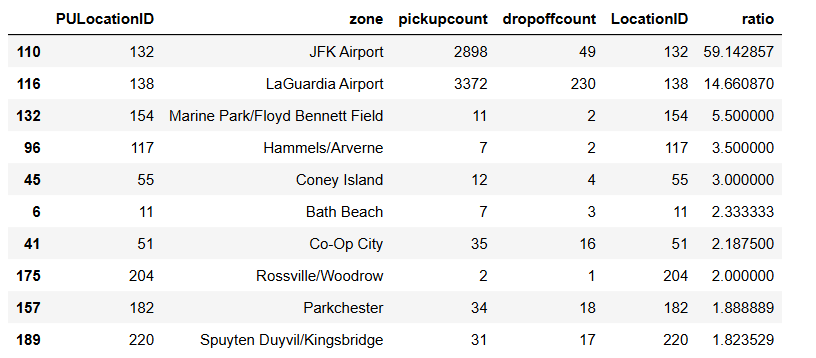

To 10 lowest pickup/drop ratio
    
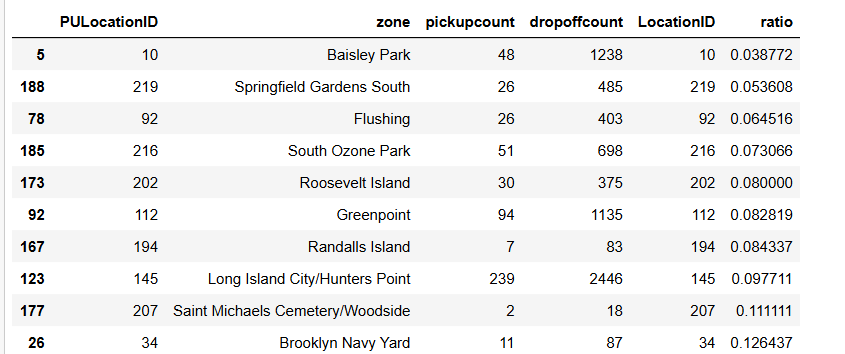    


**3.2.7** <font color = red>[3 marks]</font> <br>
Identify zones with high pickup and dropoff traffic during night hours (11PM to 5AM)

In [185]:
# During night hours (11pm to 5am) find the top 10 pickup and dropoff zones
# Note that the top zones should be of night hours and not the overall top zones

timeslot = ["23","0","1","2","3","4","5"]

In [211]:
toppickupzone_night = merged_df[((merged_df["hour"].astype(str).isin(timeslot)))]

In [212]:
toppickupzone_night.shape

(151779, 39)

In [213]:
toppickupzone_night = toppickupzone_night.groupby(["zone"])["zone"].count().reset_index(name="count")

In [214]:
toppickupzone_night.sort_values(by = "count", ascending=False).head(10)


zone  count
57                   East Village  12160
176                  West Village  10020
31                   Clinton East   7789
105               Lower East Side   7532
79        Greenwich Village South   7213
159     Times Sq/Theatre District   6104
131  Penn Station/Madison Sq West   5617
117                 Midtown South   4974
75                       Gramercy   4694
47                   East Chelsea   4653

In [226]:
topdropoffzone_night = merged_df[(merged_df["dropoffhour"].astype(str).isin(timeslot))]

In [216]:
topdropoffzone_night.shape

(162955, 39)

In [231]:
topdropoffzone_night = topdropoffzone_night.groupby(["DOLocationID"])["DOLocationID"].count().reset_index(name="count")

In [232]:
topdropoffzone_night.rename(columns={'DOLocationID': 'LocationID'}, inplace=True)


In [234]:
topdropoffzone_night = pd.merge(topdropoffzone_night, zones, on='LocationID', how='inner')

In [237]:
pickdrop_night = pd.merge(toppickupzone_night,topdropoffzone_night, on='zone', how='inner')

In [238]:
pickdrop_night.head()

zone  count_x  LocationID  count_y  OBJECTID  Shape_Leng  \
0  Alphabet City      838           4     1587         4    0.043567   
1        Astoria       88           7      721         7    0.107417   
2   Baisley Park        3          10      278        10    0.099839   
3     Bath Beach        1          11        1        11    0.079211   
4   Battery Park        6          12       25        12    0.036661   

   Shape_Area    borough                                           geometry  
0    0.000112  Manhattan  POLYGON ((992073.467 203714.076, 992068.667 20...  
1    0.000390     Queens  POLYGON ((1010804.218 218919.641, 1011049.165 ...  
2    0.000436     Queens  POLYGON ((1044355.072 190734.321, 1044612.122 ...  
3    0.000265   Brooklyn  POLYGON ((983945.076 158978.174, 984160.158 15...  
4    0.000042  Manhattan  POLYGON ((979908.772 196066.565, 979980.852 19...

In [240]:
pickdrop_night["finalcount"] = pickdrop_night["count_x"] + pickdrop_night["count_y"]

In [244]:
pickdrop_night = pickdrop_night.groupby(["zone"])["finalcount"].sum().reset_index()

In [247]:
pickdrop_night.sort_values(by=["finalcount"] , ascending=False).head(10)

zone  finalcount
53                   East Village       19528
165                  West Village       14713
30                   Clinton East       13946
100               Lower East Side       11482
70                       Gramercy       10241
150     Times Sq/Theatre District       10062
44                   East Chelsea       10021
74        Greenwich Village South        9633
118                   Murray Hill        9333
125  Penn Station/Madison Sq West        9294

<b>[Sheeshma]</b><br>

Top 10 pickup/dropoff traffic in night hours<br>

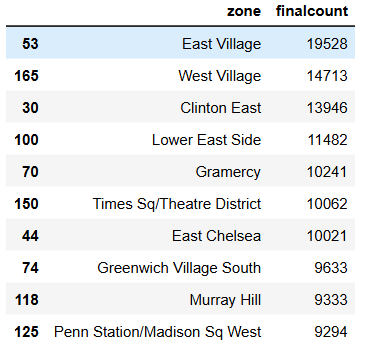

Now, let us find the revenue share for the night time hours and the day time hours. After this, we will move to deciding a pricing strategy.

**3.2.8** <font color = red>[2 marks]</font> <br>
Find the revenue share for nighttime and daytime hours.

In [277]:
# Filter for night hours (11 PM to 5 AM)

night_data = merged_df[((merged_df["hour"].astype(str).isin(timeslot)))]

In [278]:
day_data = merged_df[-((merged_df["hour"].astype(str).isin(timeslot)))]

In [281]:
night_data["total_amount"].sum()

2999273.9

In [282]:
day_data["total_amount"].sum()

24779641.98

<b>[Sheeshma]</b></br>

Rvenue data for night time <b>2999273.9<b></br>

Rvenue data for day time <b>24779641.98<b>
    
    

##### Pricing Strategy

**3.2.9** <font color = red>[2 marks]</font> <br>
For the different passenger counts, find the average fare per mile per passenger.

For instance, suppose the average fare per mile for trips with 3 passengers is 3 USD/mile, then the fare per mile per passenger will be 1 USD/mile.

In [310]:
# Analyse the fare per mile per passenger for different passenger counts

milesperpasngr = merged_df.groupby(["passenger_count"])[["passenger_count","trip_distance","fare_amount"]].sum()


In [311]:
milesperpasngr.rename(columns={'passenger_count': 'passenger_count',
    'passenger_count': 'total_passenger_count',
    'trip_distance': 'total_trip_distance',
    'fare_amount': 'total_fare_amount'
}, inplace=True)

In [317]:
milesperpasngr

total_passenger_count  total_trip_distance  \
passenger_count                                               
1.0                          1064212.0           1848826.58   
2.0                           398198.0            354505.96   
3.0                           150636.0             88888.23   
4.0                           108176.0             48537.87   
5.0                            91420.0             32770.44   
6.0                            73140.0             21422.52   

                 total_fare_amount  avgfarepermileperpassenger  
passenger_count                                                 
1.0                    13686251.05                    0.000007  
2.0                     2624337.41                    0.000019  
3.0                      665881.60                    0.000050  
4.0                      365399.30                    0.000070  
5.0                      237670.70                    0.000079  
6.0                      158292.75                    0.000101

In [313]:
milesperpasngr["avgfarepermileperpassenger"] = milesperpasngr["total_fare_amount"]/(milesperpasngr["total_trip_distance"]*milesperpasngr["total_passenger_count"])

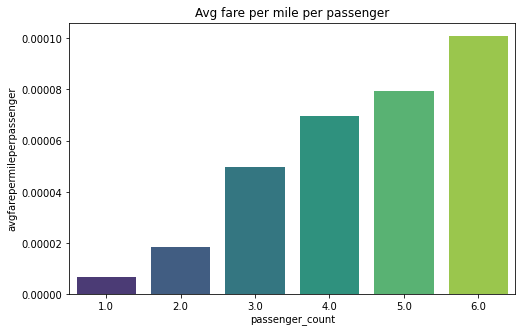

In [318]:
plt.figure(figsize=(8, 5))
sns.barplot(x='passenger_count', y='avgfarepermileperpassenger', data=milesperpasngr, palette='viridis')
plt.xlabel('passenger_count')
plt.ylabel('avgfarepermileperpassenger')
plt.title('Avg fare per mile per passenger')
plt.show()

<b>[Sheeshma]</b><br>
Avg fare per mile per passenger
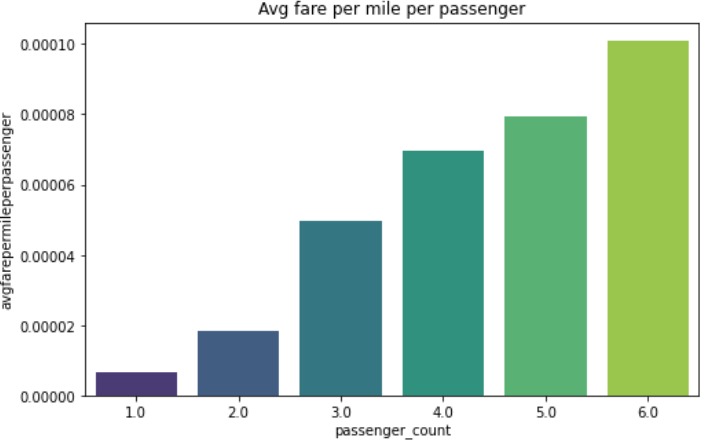

**3.2.10** <font color = red>[3 marks]</font> <br>
Find the average fare per mile by hours of the day and by days of the week

In [320]:
# Compare the average fare per mile for different days and for different times of the day

AvgFarePerMile_hr = merged_df.groupby(["hour"])[["trip_distance","fare_amount"]].sum()


In [324]:
AvgFarePerMile_hr.rename(columns={'hour': 'hour',
    'trip_distance': 'total_trip_distance',
    'fare_amount': 'total_fare_amount'
}, inplace=True)

In [325]:
AvgFarePerMile_hr["avgfarepermileperhr"] = AvgFarePerMile_hr["total_fare_amount"]/(AvgFarePerMile_hr["total_trip_distance"])


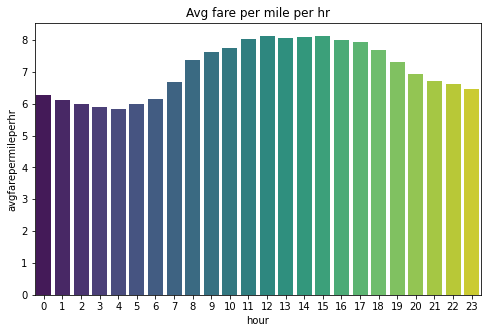

In [326]:
plt.figure(figsize=(8, 5))
sns.barplot(x='hour', y='avgfarepermileperhr', data=AvgFarePerMile_hr, palette='viridis')
plt.xlabel('hour')
plt.ylabel('avgfarepermileperhr')
plt.title('Avg fare per mile per hr')
plt.show()

In [333]:

AvgFarePerMile_dayofweek = merged_df.groupby(["pickupday"])[["trip_distance","fare_amount"]].sum()


In [334]:
AvgFarePerMile_dayofweek.rename(columns={'pickupday': 'pickupday',
    'trip_distance': 'total_trip_distance',
    'fare_amount': 'total_fare_amount'
}, inplace=True)

In [338]:
AvgFarePerMile_dayofweek["avgfarepermileperday"] = AvgFarePerMile_dayofweek["total_fare_amount"]/AvgFarePerMile_dayofweek["total_trip_distance"]


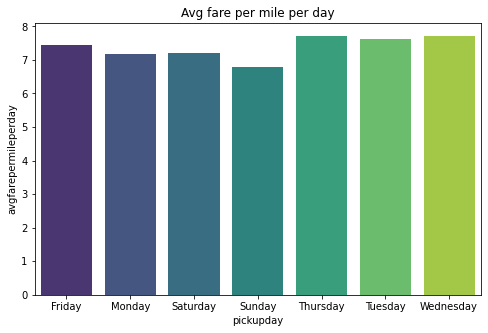

In [340]:
plt.figure(figsize=(8, 5))
sns.barplot(x='pickupday', y='avgfarepermileperday', data=AvgFarePerMile_dayofweek, palette='viridis')
plt.xlabel('pickupday')
plt.ylabel('avgfarepermileperday')
plt.title('Avg fare per mile per day')
plt.show()

<b>[Sheeshma]</b><br>

Average fare per mile per day <br>


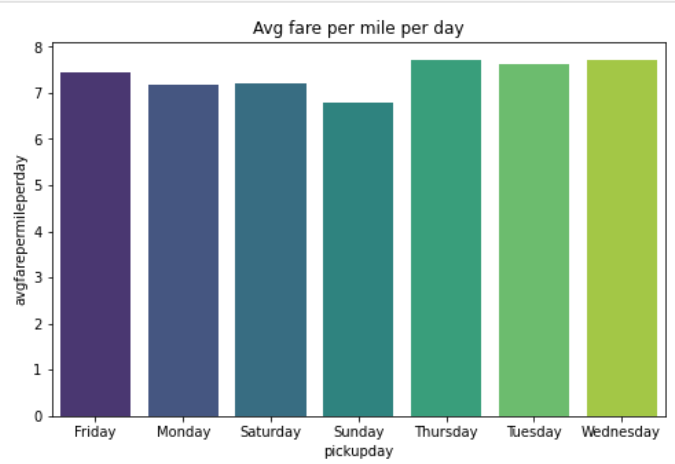

**3.2.11** <font color = red>[3 marks]</font> <br>
Analyse the average fare per mile for the different vendors for different hours of the day

In [384]:
# Compare fare per mile for different vendors

Avgfarepermile_vendor = merged_df.groupby(["VendorID"])[["trip_distance","fare_amount"]].sum()

In [385]:
Avgfarepermile_vendor.rename(columns={'VendorID': 'VendorID',
    'trip_distance': 'total_trip_distance',
    'fare_amount': 'total_fare_amount'
}, inplace=True)

In [386]:

Avgfarepermile_vendor

total_trip_distance  total_fare_amount
VendorID                                        
1                    633597.7         4667481.93
2                   1761353.9        13070350.88

In [389]:
Avgfarepermile_vendor["avgfarepermile_ven"] = Avgfarepermile_vendor_hr["total_fare_amount"]/Avgfarepermile_vendor_hr["total_trip_distance"]


In [390]:
Avgfarepermile_vendor.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2 entries, 1 to 2
Data columns (total 3 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   total_trip_distance  2 non-null      float64
 1   total_fare_amount    2 non-null      float64
 2   avgfarepermile_ven   2 non-null      float64
dtypes: float64(3)
memory usage: 64.0 bytes


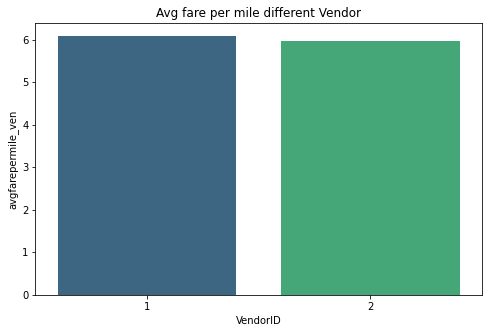

In [392]:
plt.figure(figsize=(8, 5))
sns.barplot(x='VendorID', y='avgfarepermile_ven', data=Avgfarepermile_vendor, palette='viridis')
plt.xlabel('VendorID')
plt.ylabel('avgfarepermile_ven')
plt.title('Avg fare per mile different Vendor')
plt.show()

<b>[Sheeshma]</b><br>

For avg fare per mile for different vendor<br>

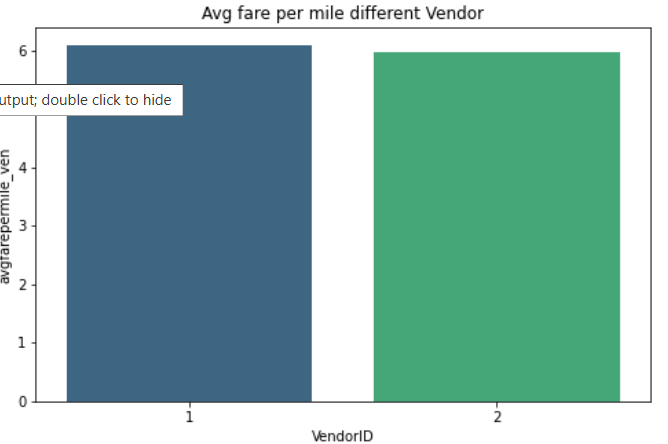

In [393]:
Avgfarepermile_vendor_hr = merged_df.groupby(["VendorID","hour"])[["trip_distance","fare_amount"]].sum()

In [396]:
Avgfarepermile_vendor_hr.reset_index(inplace=True)

In [401]:
Avgfarepermile_vendor_hr.rename(columns={'VendorID': 'VendorID',
    'hour': 'hour',
    'trip_distance': 'total_trip_distance',
    'fare_amount': 'total_fare_amount'
}, inplace=True)

In [403]:
Avgfarepermile_vendor_hr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48 entries, 0 to 47
Data columns (total 4 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   VendorID             48 non-null     int64  
 1   hour                 48 non-null     int32  
 2   total_trip_distance  48 non-null     float64
 3   total_fare_amount    48 non-null     float64
dtypes: float64(2), int32(1), int64(1)
memory usage: 1.4 KB


In [405]:
Avgfarepermile_vendor_hr["avgfarepermile_ven_hr"] = Avgfarepermile_vendor_hr["total_fare_amount"]/Avgfarepermile_vendor_hr["total_trip_distance"]


In [408]:
Avgfarepermile_vendor_hr_1 = Avgfarepermile_vendor_hr[Avgfarepermile_vendor_hr["VendorID"] == 1]

In [409]:
Avgfarepermile_vendor_hr_2 = Avgfarepermile_vendor_hr[Avgfarepermile_vendor_hr["VendorID"] == 2]

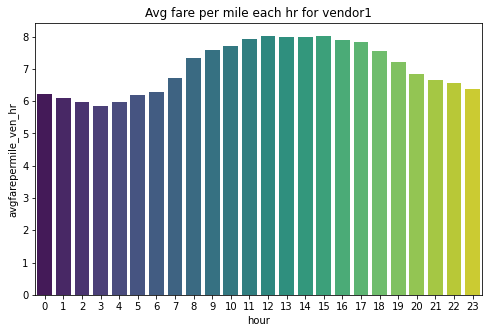

In [411]:
plt.figure(figsize=(8, 5))
sns.barplot(x='hour', y='avgfarepermile_ven_hr', data=Avgfarepermile_vendor_hr_1, palette='viridis')
plt.xlabel('hour')
plt.ylabel('avgfarepermile_ven_hr')
plt.title('Avg fare per mile each hr for vendor1')
plt.show()

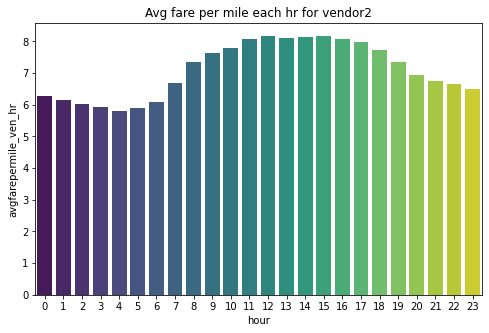

In [412]:
plt.figure(figsize=(8, 5))
sns.barplot(x='hour', y='avgfarepermile_ven_hr', data=Avgfarepermile_vendor_hr_2, palette='viridis')
plt.xlabel('hour')
plt.ylabel('avgfarepermile_ven_hr')
plt.title('Avg fare per mile each hr for vendor2')
plt.show()

<b>[Sheeshma]<b></br>
    
Avg fare per mile each hr for Vendor 1

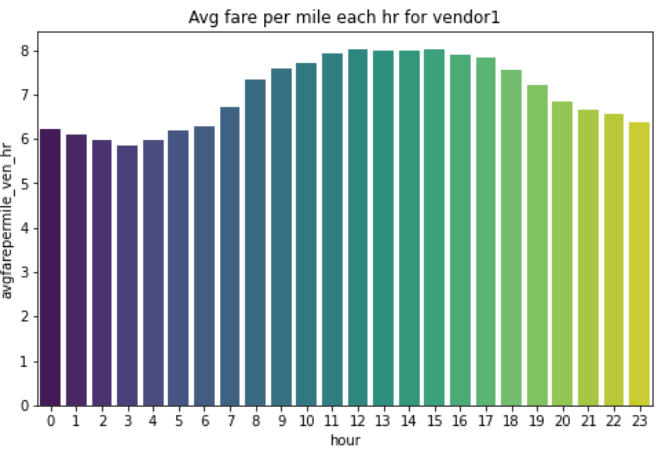
    
    
Avg fare per mile each hr for Vendor 2

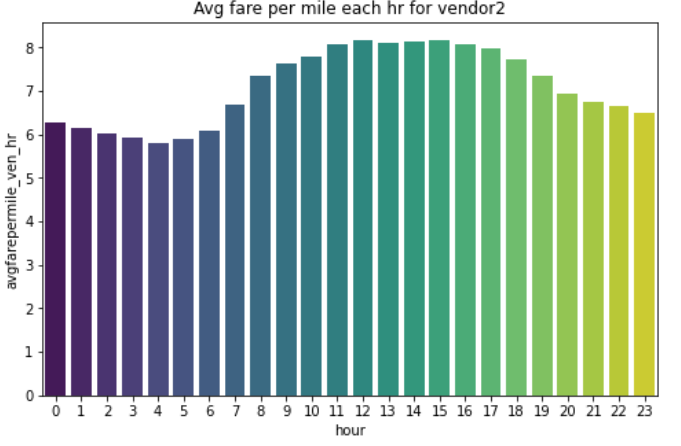

**3.2.12** <font color = red>[5 marks]</font> <br>
Compare the fare rates of the different vendors in a tiered fashion. Analyse the average fare per mile for distances upto 2 miles. Analyse the fare per mile for distances from 2 to 5 miles. And then for distances more than 5 miles.


In [41]:
# Defining distance tiers

merged_df_up2 = merged_df[merged_df["trip_distance"] <= 2]

In [42]:
merged_df_2_5 = merged_df[((merged_df["trip_distance"] > 2) & (merged_df["trip_distance"] <= 5))]

In [43]:
merged_df_to_5 = merged_df[((merged_df["trip_distance"] > 5))]

In [44]:
merged_df_up2 = merged_df_up2.groupby(["VendorID"])[["trip_distance","fare_amount"]].sum()

In [45]:
merged_df_up2.reset_index()


VendorID  trip_distance  fare_amount
0         1      304463.10   2608358.65
1         2      806046.05   6956025.12

In [46]:
merged_df_up2

trip_distance  fare_amount
VendorID                            
1             304463.10   2608358.65
2             806046.05   6956025.12

In [47]:
merged_df_up2.rename(columns={'VendorID': 'VendorID',
    'trip_distance': 'total_trip_distance',
    'fare_amount': 'total_fare_amount'
}, inplace=True)

In [48]:
merged_df_up2["Avgfarepermile"] = merged_df_up2["total_fare_amount"]/merged_df_up2["total_trip_distance"]

In [49]:
merged_df_up2

total_trip_distance  total_fare_amount  Avgfarepermile
VendorID                                                        
1                   304463.10         2608358.65        8.567076
2                   806046.05         6956025.12        8.629811

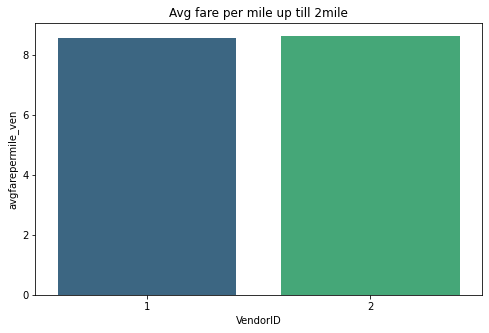

In [440]:
plt.figure(figsize=(8, 5))
sns.barplot(x='VendorID', y='Avgfarepermile', data=merged_df_up2, palette='viridis')
plt.xlabel('VendorID')
plt.ylabel('avgfarepermile_ven')
plt.title('Avg fare per mile up till 2mile')
plt.show()

In [450]:
merged_df_2_5 = merged_df_2_5.groupby(["VendorID"])[["trip_distance","fare_amount"]].sum()

In [451]:
merged_df_2_5.reset_index()
merged_df_2_5.rename(columns={'VendorID': 'VendorID',
    'trip_distance': 'total_trip_distance',
    'fare_amount': 'total_fare_amount'
}, inplace=True)
merged_df_2_5["Avgfarepermile"] = merged_df_2_5["total_fare_amount"]/merged_df_2_5["total_trip_distance"]


In [452]:
merged_df_2_5

total_trip_distance  total_fare_amount  Avgfarepermile
VendorID                                                        
1                   329134.60         2059123.28        6.256174
2                   955307.85         6114325.76        6.400372

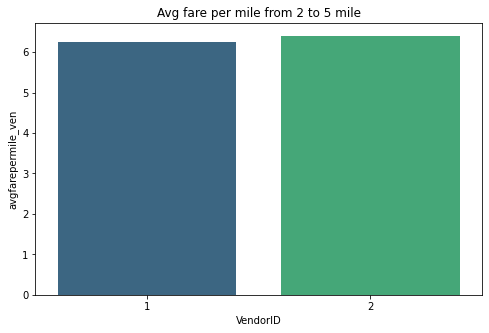

In [453]:
plt.figure(figsize=(8, 5))
sns.barplot(x='VendorID', y='Avgfarepermile', data=merged_df_2_5, palette='viridis')
plt.xlabel('VendorID')
plt.ylabel('avgfarepermile_ven')
plt.title('Avg fare per mile from 2 to 5 mile')
plt.show()

In [51]:
merged_df_to_5 = merged_df_to_5.groupby(["VendorID"])[["trip_distance","fare_amount"]].sum()

In [53]:
merged_df_to_5.reset_index()
merged_df_to_5.rename(columns={'VendorID': 'VendorID',
    'trip_distance': 'total_trip_distance',
    'fare_amount': 'total_fare_amount'
}, inplace=True)
merged_df_to_5["Avgfarepermile"] = merged_df_to_5["total_fare_amount"]/merged_df_to_5["total_trip_distance"]

In [54]:
merged_df_to_5

total_trip_distance  total_fare_amount  Avgfarepermile
VendorID                                                        
1                    70222.20          333479.59        4.748920
2                   188104.71          907502.40        4.824453

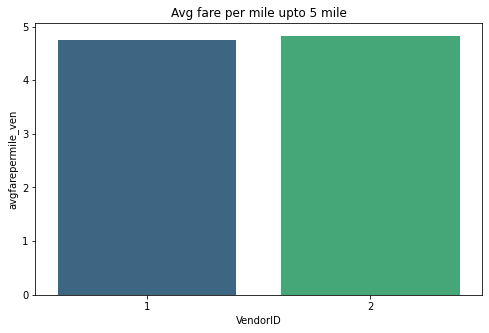

In [55]:
plt.figure(figsize=(8, 5))
sns.barplot(x='VendorID', y='Avgfarepermile', data=merged_df_to_5, palette='viridis')
plt.xlabel('VendorID')
plt.ylabel('avgfarepermile_ven')
plt.title('Avg fare per mile upto 5 mile')
plt.show()

<b>[Sheeshma]<b><br>

Avg fare per mile up to 2mile <br>

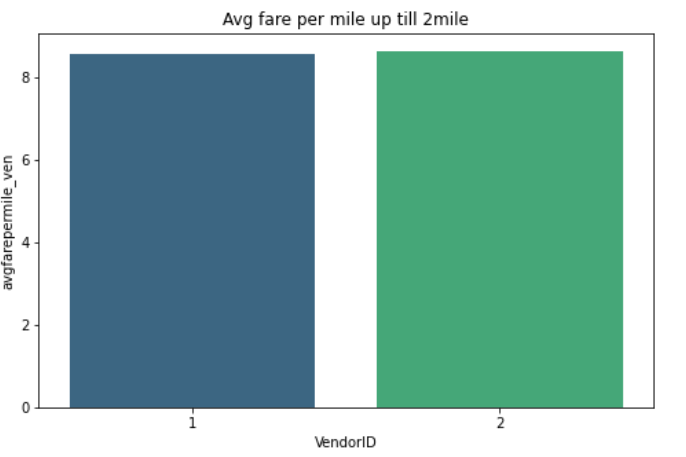

Avg fare per mile from 2 - 5 mile <br>
    
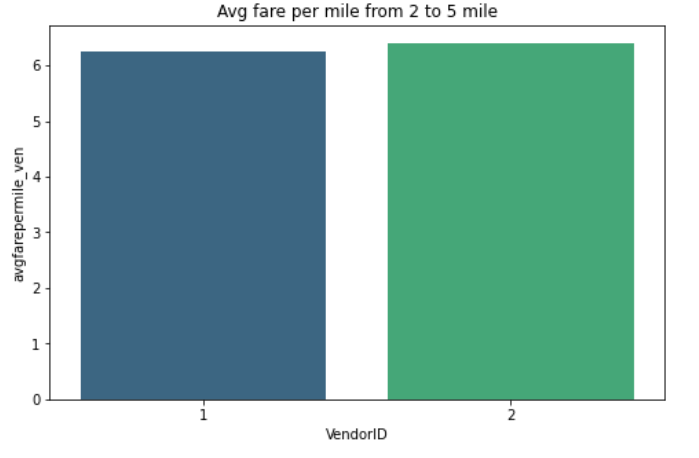
    
 Avg fare per mile up to 5 mile <br>   
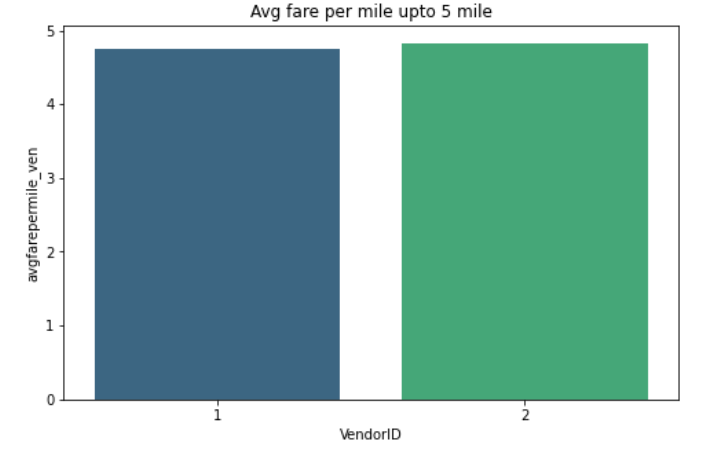

##### Customer Experience and Other Factors

**3.2.13** <font color = red>[5 marks]</font> <br>
Analyse average tip percentages based on trip distances, passenger counts and time of pickup. What factors lead to low tip percentages?

In [24]:
#  Analyze tip percentages based on distances, passenger counts and pickup times

fareamount_df = merged_df[-(merged_df["fare_amount"] <= 0)]

In [31]:
val = (fareamount_df["tip_amount"]/fareamount_df["fare_amount"])*100
fareamount_df["tip_percent"] = round(val,2)

In [151]:
tippercent_distance_2m_1 = fareamount_df[fareamount_df["trip_distance"] <= 2].groupby(["trip_distance"])["trip_distance"].count().reset_index(name="trip_count")

In [152]:
tippercent_distance_2m_2 = fareamount_df[fareamount_df["trip_distance"] <= 2].groupby(["trip_distance"])["tip_percent"].sum().reset_index(name="tip_percent_sum")

In [154]:
tippercent_distance_2m_2

trip_distance  tip_percent_sum
0             0.01          1818.13
1             0.02          1913.64
2             0.03          1128.54
3             0.04           920.79
4             0.05           750.71
..             ...              ...
195           1.96         62847.93
196           1.97         64530.21
197           1.98         61156.92
198           1.99         61936.42
199           2.00        276671.42

[200 rows x 2 columns]

In [155]:
tippercent_distance_2m_1 = pd.merge(tippercent_distance_2m_1, tippercent_distance_2m_2, on='trip_distance', how='inner')

In [157]:
tippercent_distance_2m_1["tip_avg_per"] = tippercent_distance_2m_1["tip_percent_sum"]/tippercent_distance_2m_1["trip_count"]

In [158]:
tippercent_distance_2m_1

trip_distance  trip_count  tip_percent_sum  tip_avg_per
0             0.01         117          1818.13    15.539573
1             0.02          97          1913.64    19.728247
2             0.03          97          1128.54    11.634433
3             0.04          79           920.79    11.655570
4             0.05          68           750.71    11.039853
..             ...         ...              ...          ...
195           1.96        3157         62847.93    19.907485
196           1.97        3221         64530.21    20.034216
197           1.98        3049         61156.92    20.058026
198           1.99        3087         61936.42    20.063628
199           2.00       13971        276671.42    19.803265

[200 rows x 4 columns]

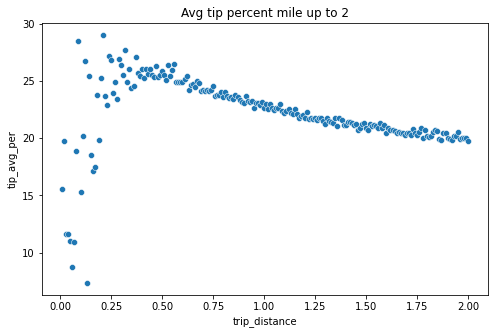

In [160]:
plt.figure(figsize=(8, 5))
sns.scatterplot(x='trip_distance', y='tip_avg_per', data=tippercent_distance_2m_1, palette='viridis')
plt.xlabel('trip_distance')
plt.ylabel('tip_avg_per')
plt.title('Avg tip percent mile up to 2')
plt.show()

In [161]:
tippercent_distance_2m5_1 = fareamount_df[((fareamount_df["trip_distance"] > 2) & (fareamount_df["trip_distance"] <= 5))].groupby(["trip_distance"])["trip_distance"].count().reset_index(name="trip_count")

tippercent_distance_2m5_2 = fareamount_df[((fareamount_df["trip_distance"] > 2) & (fareamount_df["trip_distance"] <= 5))].groupby(["trip_distance"])["tip_percent"].sum().reset_index(name="tip_percent_sum")

tippercent_distance_2m5_1 = pd.merge(tippercent_distance_2m5_1, tippercent_distance_2m5_2, on='trip_distance', how='inner')

tippercent_distance_2m5_1["tip_avg_per"] = tippercent_distance_2m5_1["tip_percent_sum"]/tippercent_distance_2m5_1["trip_count"]

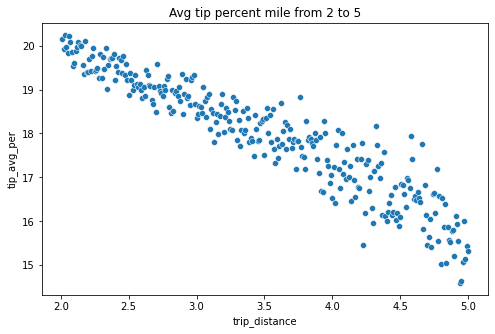

In [163]:
plt.figure(figsize=(8, 5))
sns.scatterplot(x='trip_distance', y='tip_avg_per', data=tippercent_distance_2m5_1, palette='viridis')
plt.xlabel('trip_distance')
plt.ylabel('tip_avg_per')
plt.title('Avg tip percent mile from 2 to 5')
plt.show()

In [166]:
tippercent_distance_5m_1 = fareamount_df[((fareamount_df["trip_distance"] > 5))].groupby(["trip_distance"])["trip_distance"].count().reset_index(name="trip_count")

tippercent_distance_5m_2 = fareamount_df[((fareamount_df["trip_distance"] > 5))].groupby(["trip_distance"])["tip_percent"].sum().reset_index(name="tip_percent_sum")

tippercent_distance_5m_1 = pd.merge(tippercent_distance_5m_1, tippercent_distance_5m_2, on='trip_distance', how='inner')

tippercent_distance_5m_1["tip_avg_per"] = tippercent_distance_5m_1["tip_percent_sum"]/tippercent_distance_5m_1["trip_count"]

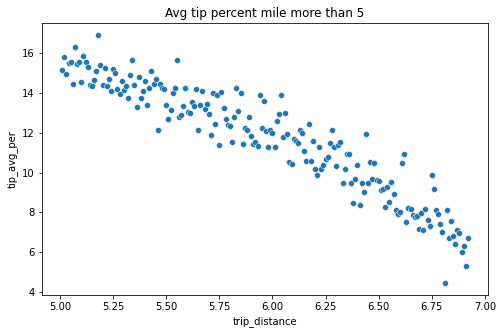

In [167]:
plt.figure(figsize=(8, 5))
sns.scatterplot(x='trip_distance', y='tip_avg_per', data=tippercent_distance_5m_1, palette='viridis')
plt.xlabel('trip_distance')
plt.ylabel('tip_avg_per')
plt.title('Avg tip percent mile more than 5')
plt.show()

In [122]:
tippercent_distance_2m


trip_distance  total_tip_amount  total_fare_amount
0             0.01            121.67             892.67
1             0.02             92.83             540.09
2             0.03             57.02             517.40
3             0.04             67.90             474.75
4             0.05             33.20             325.62
..             ...               ...                ...
195           1.96           8845.83           45085.50
196           1.97           9160.91           46309.20
197           1.98           8772.01           44214.00
198           1.99           8830.11           44582.30
199           2.00          39126.40          200370.11

[200 rows x 3 columns]

<b>[Sheeshma]</b><br>

Average tip percentages based on different trip distances<br>

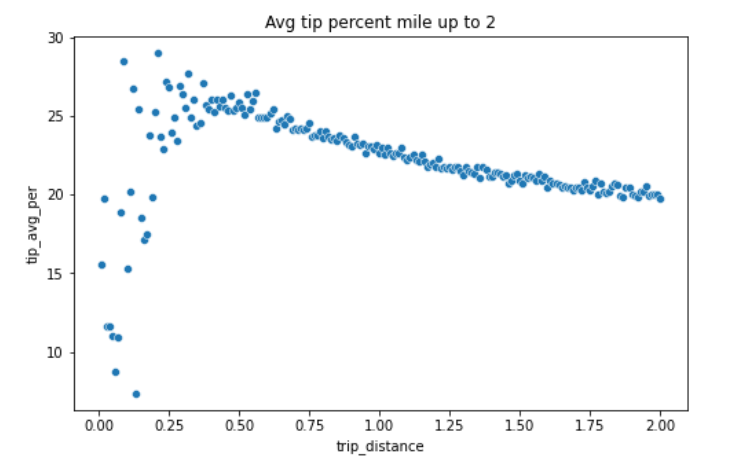
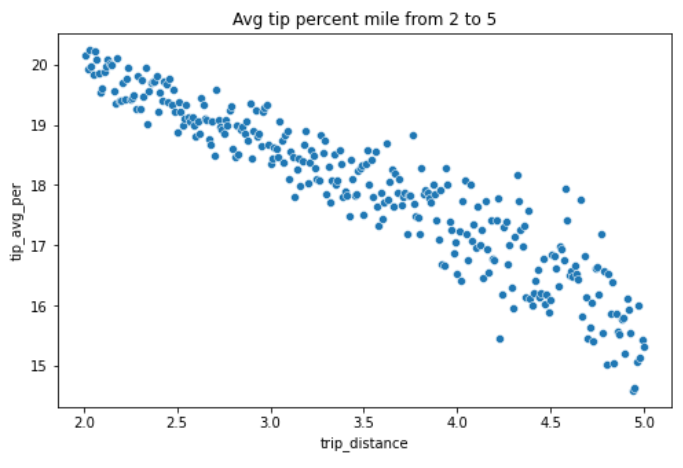
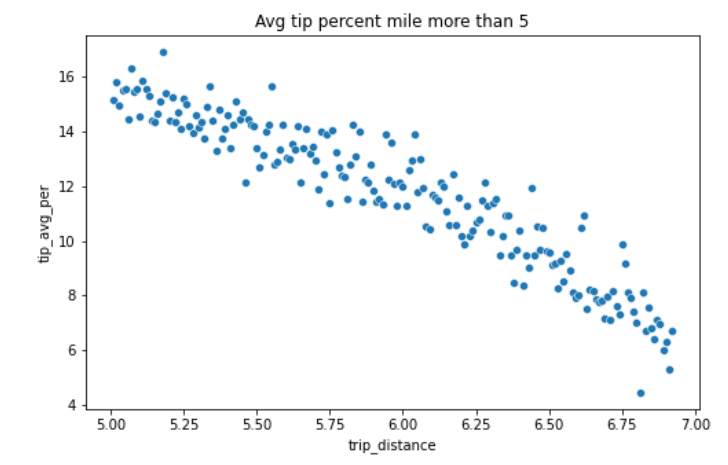

In [ ]:
#Analyse average tip percentages based on passenger counts and time of pickup. What factors lead to low tip percentages?

In [176]:
tip_passenger_count_1  = fareamount_df.groupby(["passenger_count"])["passenger_count"].count().reset_index(name="total_passenger_count")

In [177]:
tip_passenger_count_2  = fareamount_df.groupby(["passenger_count"])["tip_percent"].sum().reset_index(name="tip_percent_sum")

In [178]:
tip_passenger_count_1 = pd.merge(tip_passenger_count_1, tip_passenger_count_2, on='passenger_count', how='inner')

In [179]:
tip_passenger_count_1

passenger_count  total_passenger_count  tip_percent_sum
0              1.0                1117465      23451668.89
1              2.0                 209720       4253935.70
2              3.0                  52996       1034751.72
3              4.0                  28787        517853.65
4              5.0                  19270        400123.72
5              6.0                  12777        265393.52

In [181]:
tip_passenger_count_1["tip_avg_per"] = tip_passenger_count_1["tip_percent_sum"]/tip_passenger_count_1["total_passenger_count"]

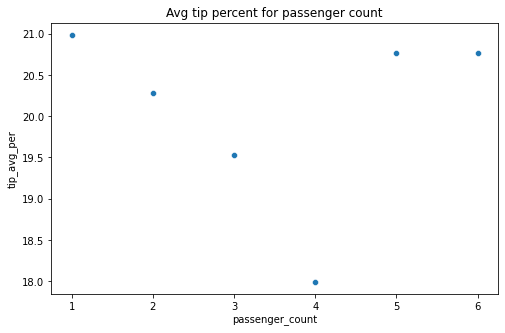

In [182]:
plt.figure(figsize=(8, 5))
sns.scatterplot(x='passenger_count', y='tip_avg_per', data=tip_passenger_count_1, palette='viridis')
plt.xlabel('passenger_count')
plt.ylabel('tip_avg_per')
plt.title('Avg tip percent for passenger count')
plt.show()

<b>[Sheeshma]</b><br>

Negative correlation for tip amount vs passenger count, however for passenger count more than 4 tip amount is high <br>

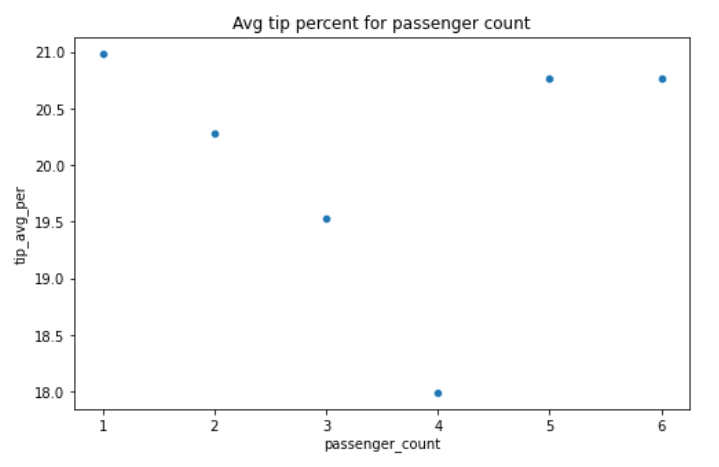


In [ ]:
#Analyse average tip percentages based on time of pickup. What factors lead to low tip percentages?

In [189]:
fareamount_df["hour"].dtype

dtype('int32')

In [204]:
night_df_1 = fareamount_df[((fareamount_df["hour"] >= 0) & (fareamount_df["hour"] <= 5))]

In [205]:
night_df_2 = fareamount_df[((fareamount_df["hour"] >= 19) & (fareamount_df["hour"] <= 23))]

In [206]:
night_df_1 = pd.concat([night_df_1, night_df_2]).reset_index(drop=True)

In [200]:
morning_df_1 = fareamount_df[((fareamount_df["hour"] > 5) & (fareamount_df["hour"] <= 18))]

In [207]:
night_df_hr_1 = night_df_1.groupby(["hour"])["hour"].count().reset_index(name="hour_count")

In [208]:
night_df_hr_2 = night_df_1.groupby(["hour"])["tip_percent"].sum().reset_index(name="tip_percent_sum")

In [ ]:
night_df_1.groupby(["hour"])["hour"].count().reset_index(name="hour_count")

In [210]:
night_df_hr_1 = pd.merge(night_df_hr_1, night_df_hr_2, on='hour', how='inner')

In [212]:
night_df_hr_1["tip_avg_per"] = night_df_hr_1["tip_percent_sum"]/night_df_hr_1["hour_count"]

In [226]:
night_df_hr_1

hour  hour_count  tip_percent_sum  tip_avg_per
0      0       39893        841485.37    21.093560
1      1       27971        594634.08    21.258950
2      2       18705        394405.35    21.085557
3      3       11843        241346.21    20.378807
4      4        6378        119197.11    18.688791
5      5        6110        113362.67    18.553628
6     19       93849       2126963.38    22.663677
7     20       82909       1816670.01    21.911614
8     21       82869       1818106.04    21.939519
9     22       75541       1649366.25    21.834054
10    23       56954       1210971.69    21.262276

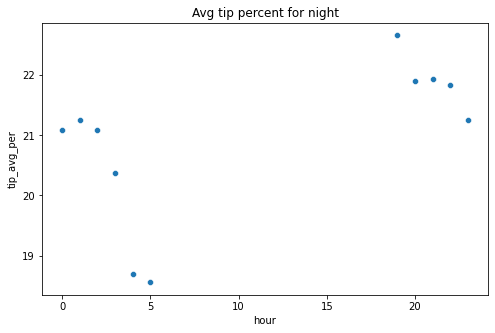

In [225]:
plt.figure(figsize=(8, 5))
sns.scatterplot(x='hour', y='tip_avg_per', data=night_df_hr_1, palette='viridis')
plt.xlabel('hour')
plt.ylabel('tip_avg_per')
plt.title('Avg tip percent for night')
plt.show()


In [222]:
morning_df_2["tip_avg_per"] = morning_df_2["tip_percent_sum"]/morning_df_2["hour_count"]

In [214]:
morning_df_2 = morning_df_1.groupby(["hour"])["hour"].count().reset_index(name="hour_count")
morning_df_3 = morning_df_1.groupby(["hour"])["tip_percent"].sum().reset_index(name="tip_percent_sum")

morning_df_2 = pd.merge(morning_df_2, morning_df_3, on='hour', how='inner')

morning_df_2["tip_avg_per"] = morning_df_2["tip_percent_sum"]/morning_df_2["hour_count"]

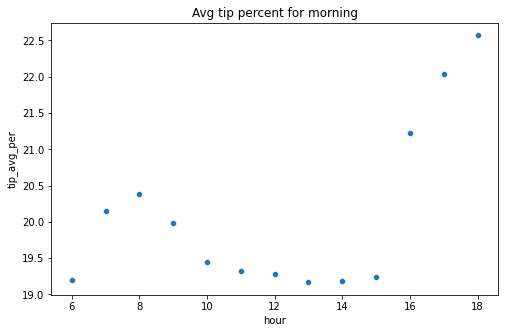

In [227]:
plt.figure(figsize=(8, 5))
sns.scatterplot(x='hour', y='tip_avg_per', data=morning_df_2, palette='viridis')
plt.xlabel('hour')
plt.ylabel('tip_avg_per')
plt.title('Avg tip percent for morning')
plt.show()

<b>[Sheeshma]</b><br>

Avg tip percent for morning and night <br>


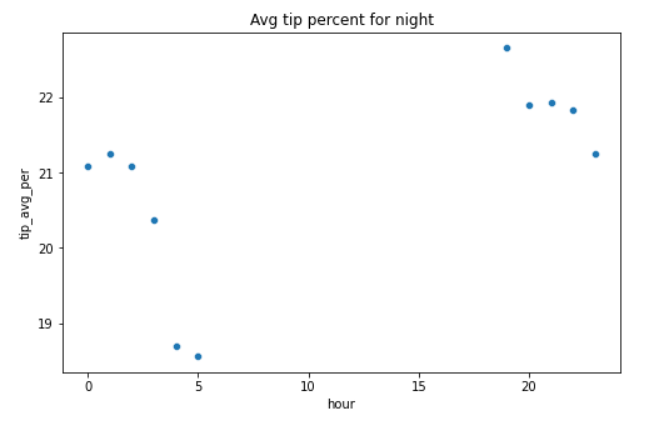

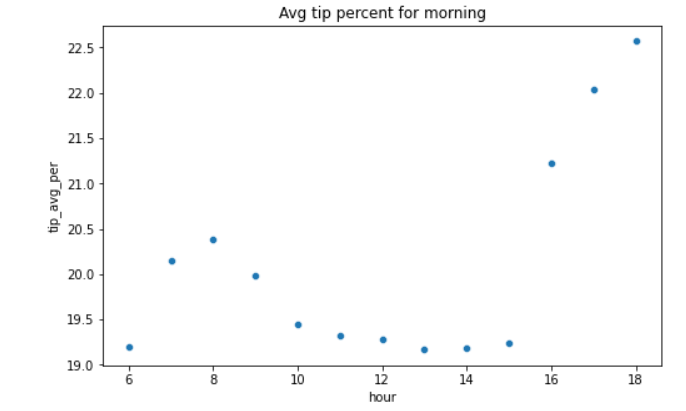

<b>[Sheeshma]</b></br>
What factors lead to low tip percentages?</br>

Factors which led to low tip percentages are</br>
1. high trip distance ie, trip distance more than 2 miles </br>
2. Passenger count is 4<br>
3. Morning time after 5am to 6 am and from 10am till 4pm

Additional analysis [optional]: Let's try comparing cases of low tips with cases of high tips to find out if we find a clear aspect that drives up the tipping behaviours

In [248]:
fareamount_df = merged_df[-(merged_df["fare_amount"] <= 0)]

In [251]:
fareamount_df_1 = fareamount_df[["DOLocationID","tip_percent"]]

In [252]:
fareamount_df_1["LocationID"] = fareamount_df[["DOLocationID"]]

In [254]:
fareamount_df_1 = pd.merge(fareamount_df_1, zones, on='LocationID', how='inner')

In [256]:
fareamount_df_1["dropoff_zone"] = fareamount_df_1["zone"]

In [257]:
fareamount_df_1["pickup_zone"] = fareamount_df["zone"]

In [269]:
fareamount_df_1 = fareamount_df_1[["pickup_zone","dropoff_zone","tip_percent"]]

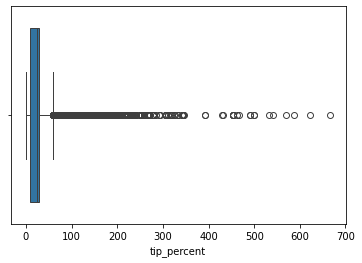

In [279]:
sns.boxplot(x=fareamount_df_1["tip_percent"])
plt.show()

In [280]:
tipQ1 = fareamount_df_1["tip_percent"].quantile(0.25)
tipQ3 = fareamount_df_1["tip_percent"].quantile(0.75)
tipIQR = tipQ3-tipQ1
tipuw = tipQ3+1.5*tipIQR
tiplw = tipQ1-1.5*tipIQR

print(tipuw)
print(tiplw)

59.92999999999999
-20.869999999999997


In [283]:
fareamount_df_1_witho = fareamount_df_1[((fareamount_df_1['tip_percent'] >= tiplw) & (fareamount_df_1['tip_percent'] <= tipuw))]

In [284]:
fareamount_df_1_witho_lessthan10 = fareamount_df_1_witho[fareamount_df_1_witho["tip_percent"] < 10]

In [285]:
fareamount_df_1_witho_morethan25 = fareamount_df_1_witho[fareamount_df_1_witho["tip_percent"] > 25]

In [288]:
# Compare trips with tip percentage < 10%
fareamount_df_1_witho_lessthan10.sort_values("tip_percent", ascending=False).head(10)

pickup_zone           dropoff_zone  tip_percent
104730   Penn Station/Madison Sq West    Lincoln Square East         9.99
309977                   East Village      East Harlem South         9.98
800120          Upper West Side North             Park Slope         9.97
1194800                      Flatiron      East Harlem South         9.97
606625                 Yorkville West        Lenox Hill West         9.96
269506                   Midtown East         Yorkville West         9.96
99004                    East Chelsea  Upper West Side South         9.96
319551                   East Village     World Trade Center         9.95
696844      West Chelsea/Hudson Yards            Murray Hill         9.95
333346       Financial District North           East Village         9.95

In [277]:
# Compare trips with tip percentage < 10% to trips with tip percentage > 25%

fareamount_df_1_morethan25.sort_values("tip_percent", ascending=True).head(10)

pickup_zone               dropoff_zone  tip_percent
1395047            Lincoln Square East      Upper West Side South        25.02
47717                  Lenox Hill East  Springfield Gardens North        25.03
591494                    Clinton West           South Ozone Park        25.03
93964    Sutton Place/Turtle Bay North              Midtown North        25.03
404885                     Murray Hill                Murray Hill        25.05
943487           Upper East Side North  Williamsburg (North Side)        25.05
943489           Upper East Side South        Lincoln Square East        25.05
322594                    Midtown East        Lincoln Square West        25.05
173769                             NaN       TriBeCa/Civic Center        25.05
868397                Garment District             Yorkville West        25.05

In [62]:
#Analysis with heatmap

tip_amount_df = fareamount_df[['fare_amount', 'tip_amount', 'trip_distance', 'tip_percent', 'passenger_count', 'pickupday',"hour","zone"]]


tip_hr_day = tip_amount_df.pivot_table(values='tip_percent', index='pickupday', columns='hour', aggfunc='mean')

day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
tip_hr_day = tip_hr_day.reindex(day_order)


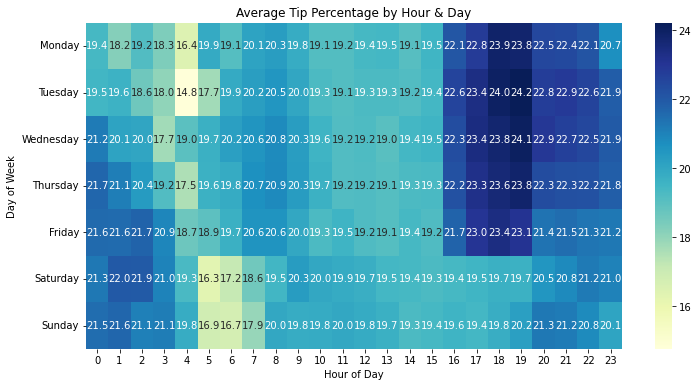

In [71]:

plt.figure(figsize=(12, 6))
sns.heatmap(tip_hr_day, cmap="YlGnBu", annot=True, fmt=".1f")
plt.title("Average Tip Percentage by Hour & Day")
plt.xlabel("Hour of Day")
plt.ylabel("Day of Week")
plt.show()

In [66]:
tip_amount_df.sort_values("trip_distance", inplace=True)


In [67]:
tip_amount_df["distance"] = pd.cut(tip_amount_df['trip_distance'], bins=[0, 2, 5, 10, 15], labels=['0-2', '2-5', '5-10','10+'])

In [68]:
dist_passenger = tip_amount_df.pivot_table(values='tip_percent', index='distance', columns='passenger_count', aggfunc='mean')

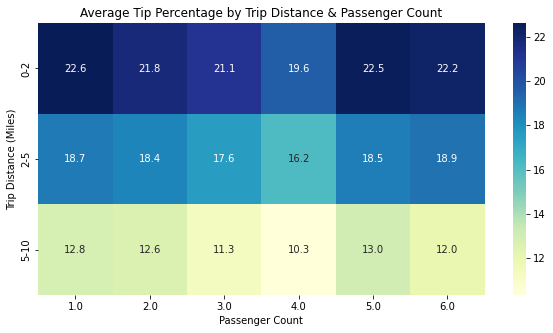

In [69]:
plt.figure(figsize=(10, 5))
sns.heatmap(dist_passenger, cmap="YlGnBu", annot=True, fmt=".1f")
plt.title("Average Tip Percentage by Trip Distance & Passenger Count")
plt.xlabel("Passenger Count")
plt.ylabel("Trip Distance (Miles)")
plt.show()

In [79]:
tip_lessthn10= tip_amount_df[tip_amount_df['tip_percent'] < 10]
tip_gtthn25 = tip_amount_df[tip_amount_df['tip_percent'] > 25]

In [75]:
lessthn10 = tip_lessthn10.pivot_table(values='tip_percent', index='pickupday', columns='hour', aggfunc='count')

day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
lesspercent = lessthn10.reindex(day_order)


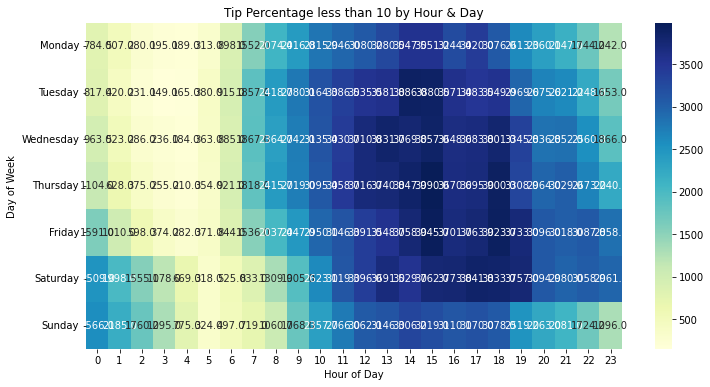

In [76]:
plt.figure(figsize=(12, 6))
sns.heatmap(lesspercent, cmap="YlGnBu", annot=True, fmt=".1f")
plt.title("Tip Percentage less than 10 by Hour & Day")
plt.xlabel("Hour of Day")
plt.ylabel("Day of Week")
plt.show()

In [80]:
tip_gtthn25

fare_amount  tip_amount  trip_distance  tip_percent  passenger_count  \
419502           3.0        4.00           0.01       133.33              1.0   
1230832         14.2        4.14           0.01        29.15              2.0   
462994           3.0       19.00           0.01       633.33              1.0   
1003549          3.0       12.00           0.01       400.00              1.0   
1216400          8.6        3.02           0.01        35.12              1.0   
...              ...         ...            ...          ...              ...   
313086          27.5        7.25           6.90        26.36              1.0   
877289          27.5        7.70           6.90        28.00              1.0   
299474          26.8        9.25           6.90        34.51              1.0   
1443263         28.9        7.60           6.92        26.30              2.0   
388970          28.2        8.05           6.92        28.55              1.0   

        pickupday  hour                       zone distance  
419502    Tuesday    15            Lenox Hill West      0-2  
1230832    Friday    19               Clinton East      0-2  
462994     Sunday    12               Midtown East      0-2  
1003549    Monday    17               West Village      0-2  
1216400   Tuesday    19  Times Sq/Theatre District      0-2  
...           ...   ...                        ...      ...  
313086     Monday    14          LaGuardia Airport     5-10  
877289     Sunday    14                JFK Airport     5-10  
299474     Friday    11      Upper East Side North     5-10  
1443263  Thursday    10           Manhattan Valley     5-10  
388970     Friday    10            Lenox Hill East     5-10  

[735834 rows x 9 columns]

In [81]:

tip_gtthn25 = tip_gtthn25.pivot_table(values='tip_percent', index='pickupday', columns='hour', aggfunc='count')
gtpercent = tip_gtthn25.reindex(day_order)

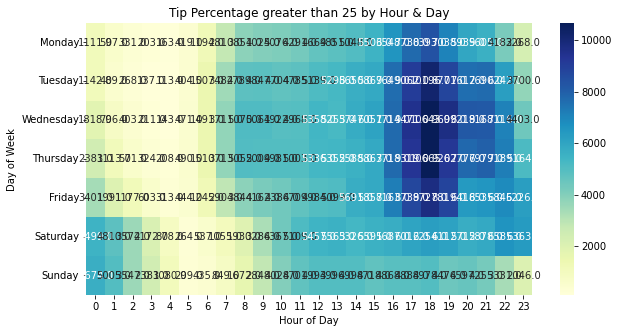

In [82]:

plt.figure(figsize=(10, 5))
sns.heatmap(gtpercent, cmap="YlGnBu", annot=True, fmt=".1f")
plt.title("Tip Percentage greater than 25 by Hour & Day")
plt.xlabel("Hour of Day")
plt.ylabel("Day of Week")
plt.show()

Analysing tip percentage by Hours of the day

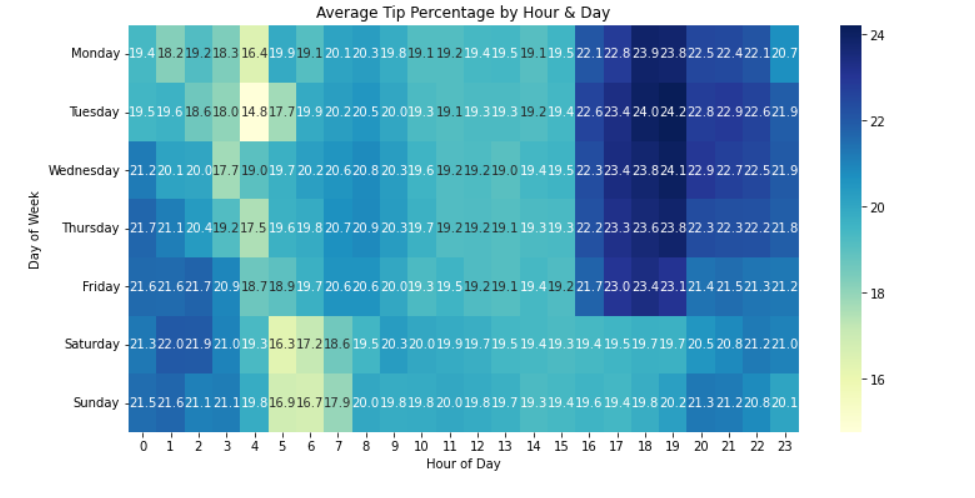


Tip percent by trip distance and passenger count

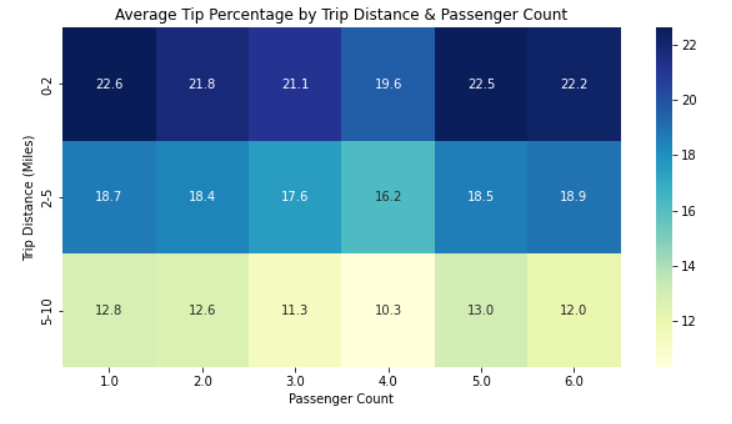

Tip percent less than 10%

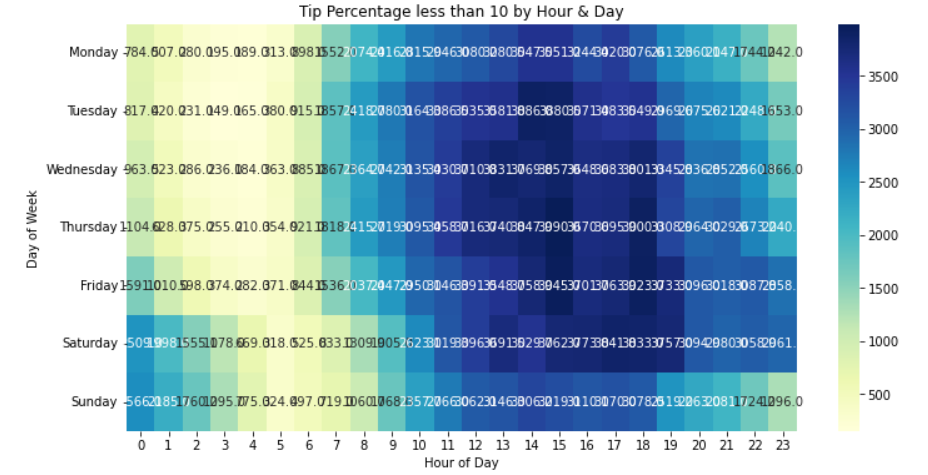


Tip percent greater than 25%

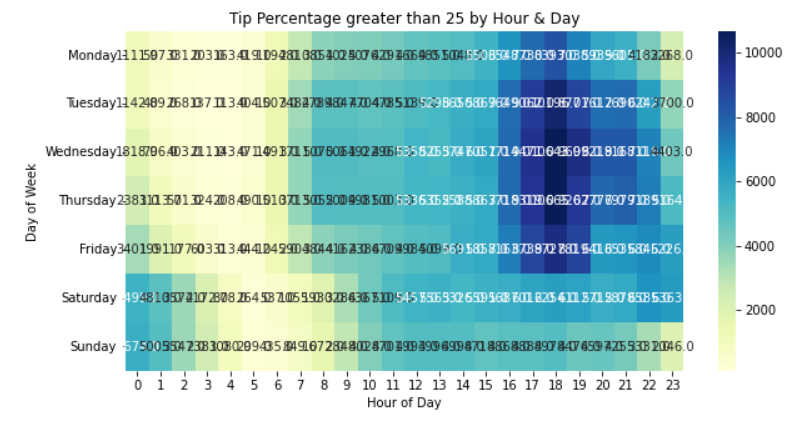

<b>[Sheeshma]</b></br>
What factors lead to low tip percentages?</br>

Factors which led to low tip percentages are</br>
1. high trip distance ie(5-10m) low tip percent, trip distance 2-5m averge tip percent </br>
2. Passenger count is 4 results in low tip<br>
3. Morning time after 5am to 6 am and from 10am till 4pm

**3.2.14** <font color = red>[3 marks]</font> <br>
Analyse the variation of passenger count across hours and days of the week.

In [83]:
# See how passenger count varies across hours and days


passcnt_hr_day = fareamount_df[['passenger_count', 'pickupday',"hour"]]


In [85]:
passcnt_hr_day_map = passcnt_hr_day.pivot_table(values='passenger_count', index='pickupday', columns='hour', aggfunc='count')


In [87]:
passcnt_hr_day_map = passcnt_hr_day_map.reindex(day_order)

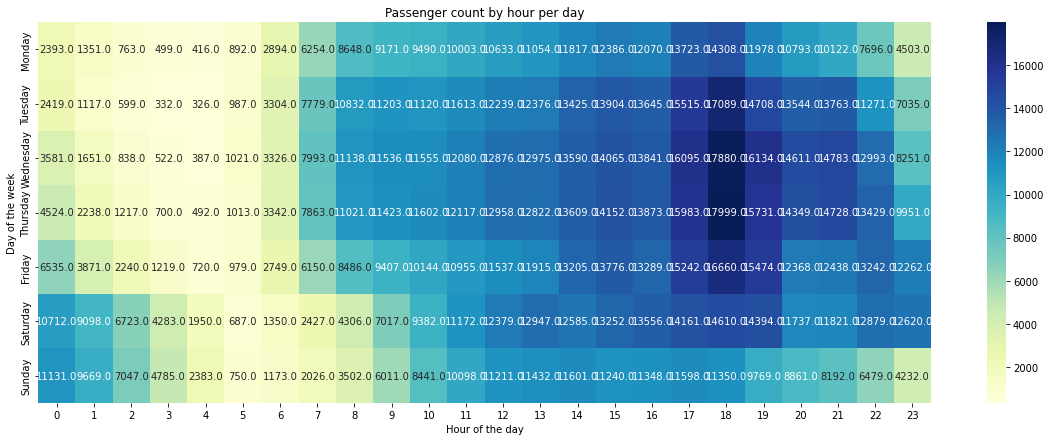

In [92]:


plt.figure(figsize=(20, 7))
sns.heatmap(passcnt_hr_day_map, cmap="YlGnBu", annot=True, fmt=".1f")
plt.title("Passenger count by hour per day")
plt.xlabel("Hour of the day")
plt.ylabel("Day of the week")
plt.show()

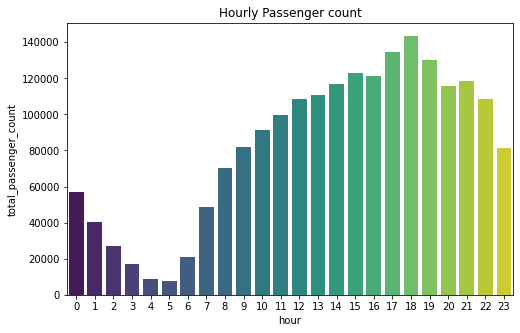

In [295]:
plt.figure(figsize=(8, 5))
sns.barplot(x='hour', y='total_passenger_count', data=merged_df_pass_hr, palette='viridis')
plt.xlabel('hour')
plt.ylabel('total_passenger_count')
plt.title('Hourly Passenger count' )
plt.show()

In [297]:
merged_df_pass_day = merged_df.groupby(["pickupday"])["passenger_count"].sum().reset_index(name="total_passenger_count")

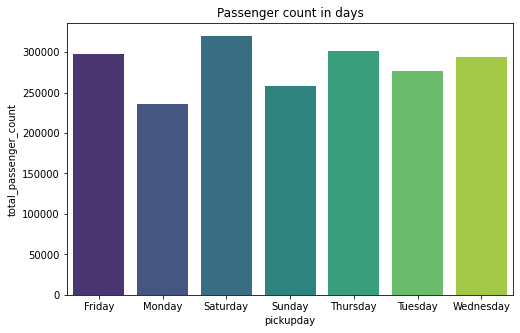

In [298]:
plt.figure(figsize=(8, 5))
sns.barplot(x='pickupday', y='total_passenger_count', data=merged_df_pass_day, palette='viridis')
plt.xlabel('pickupday')
plt.ylabel('total_passenger_count')
plt.title('Passenger count in days' )
plt.show()

<b> [Sheeshma] </b><br>

Heat Map

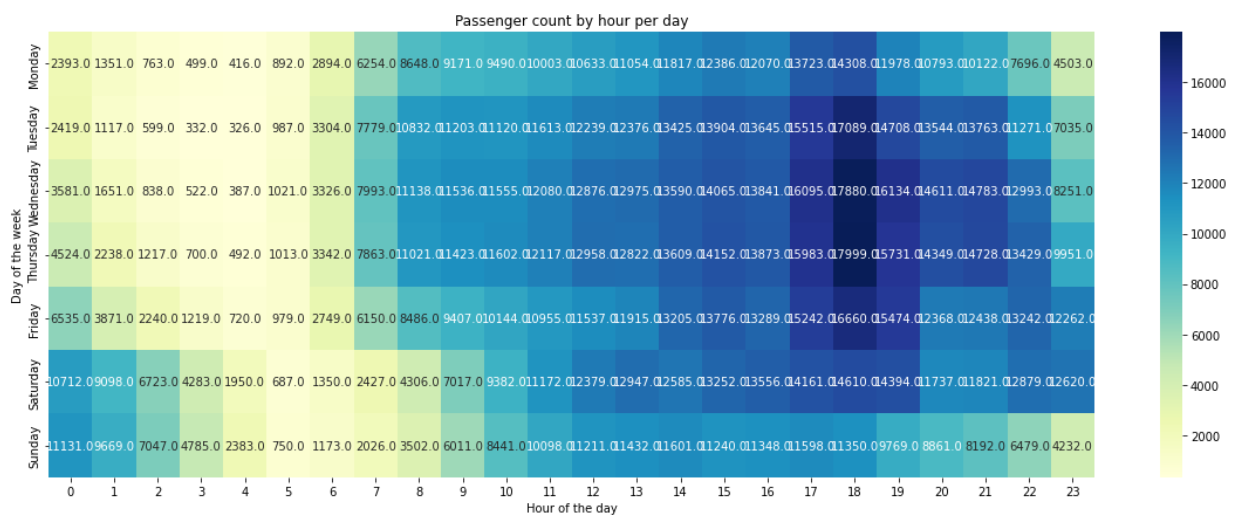

Passenger count in hours<br>

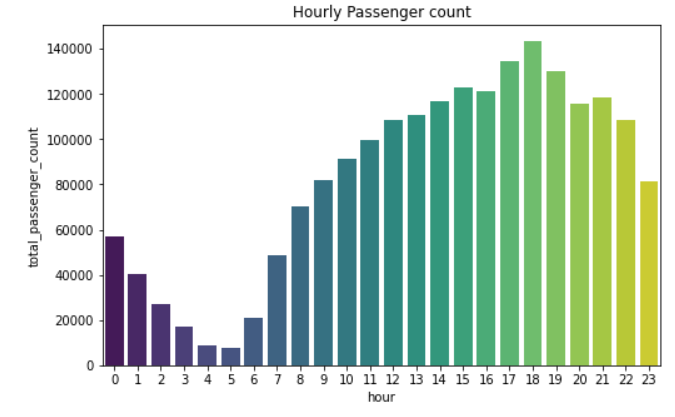

Passenger count in days<br>


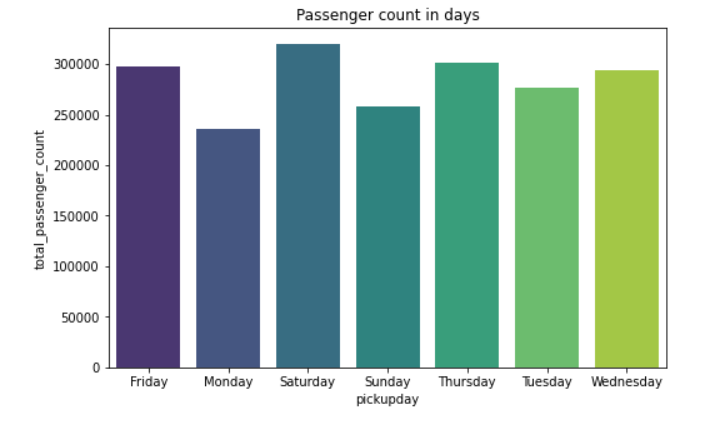


**3.2.15** <font color = red>[2 marks]</font> <br>
Analyse the variation of passenger counts across zones

In [173]:
# How does passenger count vary across zones

pass_zone =  merged_df[["DOLocationID","passenger_count","zone","extra","hour","pickupday"]]

In [174]:
pass_zone["pickupzone"] =  pass_zone["zone"]

In [175]:
pass_zone["LocationID"] =  pass_zone["DOLocationID"]

In [176]:
pass_zone.drop(columns=["zone"], inplace=True)

In [177]:
pass_zone = pd.merge(pass_zone, zones, on='LocationID', how='inner')

In [178]:
pass_zone["dropoffzone"] =  pass_zone["zone"]

In [179]:
pass_zone_ltd = pass_zone[["pickupzone","dropoffzone","passenger_count","extra","hour","pickupday"]]

In [202]:
pass_zone_ltd = pass_zone_ltd.groupby(["pickupzone"])["passenger_count"].mean().reset_index(name="passenger_count_mean")

In [243]:
pass_zone_ltd.sort_values("passenger_count_mean",ascending=False).head(10)

pickupzone  passenger_count_mean
2             Arrochar/Fort Wadsworth              2.055556
161               Ocean Parkway South              2.000000
186  Saint Michaels Cemetery/Woodside              2.000000
176                          Red Hook              1.886792
7                        Battery Park              1.765650
27                 Brooklyn Navy Yard              1.705882
112                  Inwood Hill Park              1.666667
56                 DUMBO/Vinegar Hill              1.540373
236                World Trade Center              1.529856
38                          Chinatown              1.527353

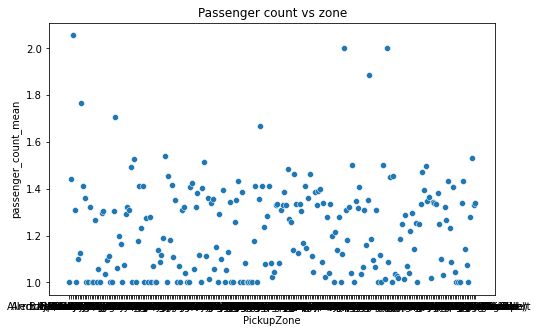

In [148]:


plt.figure(figsize=(8, 5))
sns.scatterplot(x='pickupzone', y='passenger_count_mean', data=pass_zone_ltd, palette='viridis')
plt.xlabel('PickupZone')
plt.ylabel('passenger_count_mean')
plt.title('Passenger count vs zone')
plt.show()



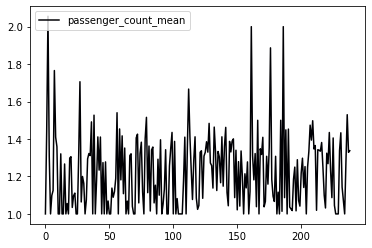

In [241]:
pass_zone_ltd.plot(column='passenger_count_mean', cmap="inferno")
plt.show()

In [149]:
# For a more detailed analysis, we can use the zones_with_trips GeoDataFrame
# Create a new column for the average passenger count in each zone.

total_pass_trips = pass_zone.groupby(["pickupzone","dropoffzone","passenger_count"])["passenger_count"].mean().reset_index(name="total_passenger_mean")

In [152]:
total_pass_trips = total_pass_trips[-(total_pass_trips["pickupzone"] == total_pass_trips["dropoffzone"])]

In [155]:
total_pass_trips.sort_values("total_passenger_mean", ascending=False).head(10)

pickupzone                     dropoffzone  \
25387            Yorkville West                  Yorkville East   
21695     Upper East Side North                   Midtown South   
6657   Financial District South         Two Bridges/Seward Park   
2343               Central Park                            SoHo   
21689     Upper East Side North                   Midtown North   
14964              Midtown East           Upper West Side South   
14972              Midtown East       West Chelsea/Hudson Yards   
21683     Upper East Side North                    Midtown East   
2351               Central Park  Stuy Town/Peter Cooper Village   
6641   Financial District South   Sutton Place/Turtle Bay North   

       passenger_count  total_passenger_mean  
25387              6.0                   6.0  
21695              6.0                   6.0  
6657               6.0                   6.0  
2343               6.0                   6.0  
21689              6.0                   6.0  
14964              6.0                   6.0  
14972              6.0                   6.0  
21683              6.0                   6.0  
2351               6.0                   6.0  
6641               6.0                   6.0

Find out how often surcharges/extra charges are applied to understand their prevalance

**3.2.16** <font color = red>[5 marks]</font> <br>
Analyse the pickup/dropoff zones or times when extra charges are applied more frequently

In [180]:
# How often is each surcharge applied?

surchrge_zone = pass_zone[["pickupzone","dropoffzone","passenger_count","extra","hour","pickupday"]]

In [181]:
surchrge_zone = surchrge_zone[surchrge_zone['extra'] > 0]

In [182]:
surchrge_zone.shape

(927521, 6)

In [184]:
surchrge_zone_pv = surchrge_zone.pivot_table(values='extra', index='pickupday', columns='hour', aggfunc='count')
surchrge_zone_pv = surchrge_zone_pv.reindex(day_order)

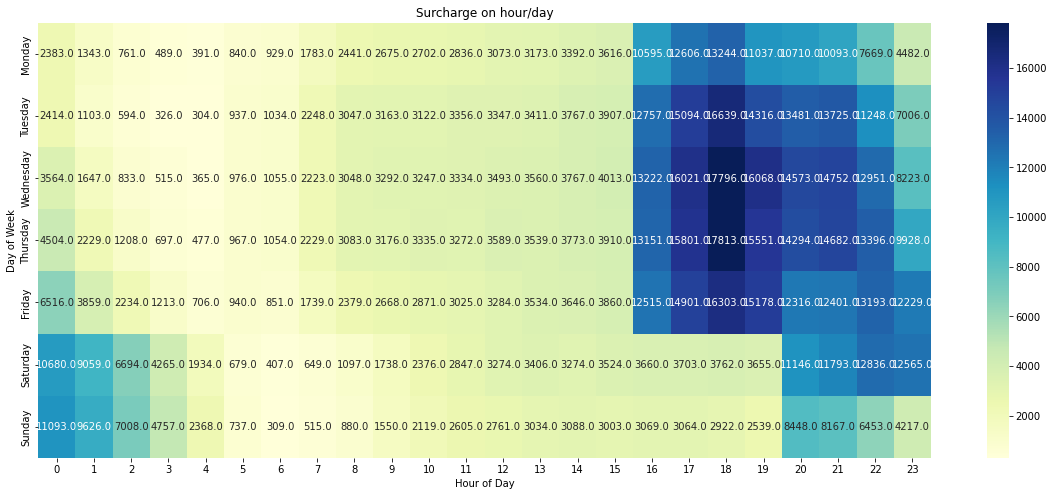

In [187]:
plt.figure(figsize=(20, 8))
sns.heatmap(surchrge_zone_pv, cmap="YlGnBu", annot=True, fmt=".1f")
plt.title("Surcharge on hour/day")
plt.xlabel("Hour of Day")
plt.ylabel("Day of Week")
plt.show()

In [211]:
merged_df_pickup  = merged_df.groupby(["zone","PULocationID"])["extra"].count().reset_index(name="extra_count")

In [213]:
merged_df_pickup_1 = pd.merge(merged_df_pickup, zones, on='zone', how='inner')

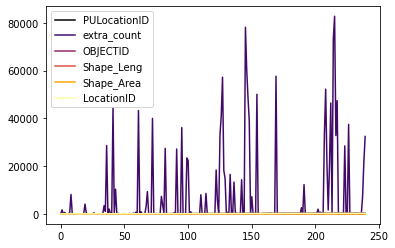

In [223]:
merged_df_pickup_1.plot(column='extra_count', cmap="inferno")
plt.show()

In [232]:
merged_df_pickup_1.sort_values("extra_count", ascending=False).head(10)

zone  PULocationID  extra_count  OBJECTID  \
215         Upper East Side South           237        82771       237   
145                Midtown Center           161        78133       161   
214         Upper East Side North           236        73189       236   
146                  Midtown East           162        60207       162   
169  Penn Station/Madison Sq West           186        57660       186   
127           Lincoln Square East           142        57263       142   
208     Times Sq/Theatre District           230        52245       230   
154                   Murray Hill           170        50087       170   
147                 Midtown North           163        48743       163   
217         Upper West Side South           239        47420       239   

     Shape_Leng  Shape_Area  LocationID    borough  \
215    0.042213    0.000096         237  Manhattan   
145    0.035804    0.000072         161  Manhattan   
214    0.044252    0.000103         236  Manhattan   
146    0.035270    0.000048         162  Manhattan   
169    0.024696    0.000037         186  Manhattan   
127    0.038176    0.000076         142  Manhattan   
208    0.031028    0.000056         230  Manhattan   
154    0.045769    0.000074         170  Manhattan   
147    0.034177    0.000041         163  Manhattan   
217    0.063626    0.000205         239  Manhattan   

                                              geometry  
215  POLYGON ((993633.442 216961.016, 993507.232 21...  
145  POLYGON ((991081.026 214453.698, 990952.644 21...  
214  POLYGON ((995940.048 221122.92, 995812.322 220...  
146  POLYGON ((992224.354 214415.293, 992096.999 21...  
169  POLYGON ((986752.603 210853.699, 986627.863 21...  
127  POLYGON ((989380.305 218980.247, 989359.803 21...  
208  POLYGON ((988786.877 214532.094, 988650.277 21...  
154  POLYGON ((991999.299 210994.739, 991972.635 21...  
147  POLYGON ((989412.663 219020.943, 990045.841 21...  
217  POLYGON ((991168.979 226252.992, 991955.565 22...

In [224]:
merged_df_dropoff  = merged_df.groupby(["DOLocationID"])["extra"].count().reset_index(name="extra_count")

In [226]:
merged_df_dropoff["LocationID"] = merged_df_dropoff["DOLocationID"]

In [228]:
merged_df_dropoff_1 = pd.merge(merged_df_dropoff, zones, on='LocationID', how='inner')

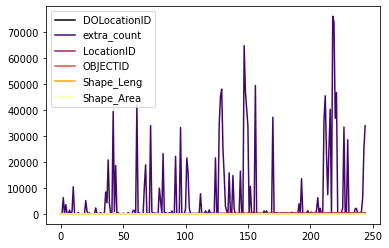

In [229]:
merged_df_dropoff_1.plot(column='extra_count', cmap="inferno")
plt.show()

In [238]:
merged_df_dropoff_1 = merged_df_dropoff_1[["zone","LocationID","extra_count"]]

merged_df_dropoff_1.sort_values("extra_count", ascending=False).head(10)

zone  LocationID  extra_count
218      Upper East Side North         236        76143
219      Upper East Side South         237        73843
147             Midtown Center         161        64800
156                Murray Hill         170        49469
129        Lincoln Square East         142        48072
148               Midtown East         162        47097
221      Upper West Side South         239        46751
212  Times Sq/Theatre District         230        45503
128            Lenox Hill West         141        45227
61                East Chelsea          68        41976

<b>[Sheeshma]</b><br>

High surcharge applied on zones<br>


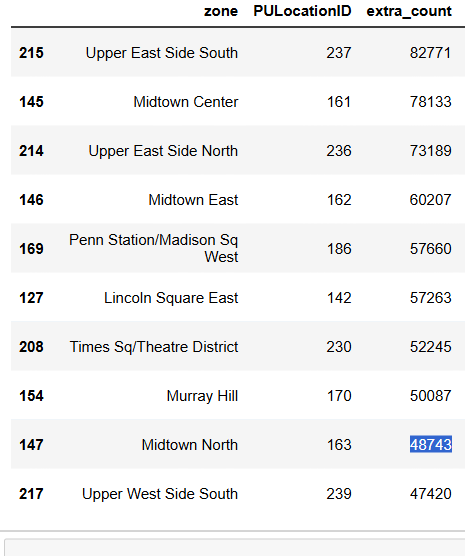


High surcharges applied on dropoffzones<br>

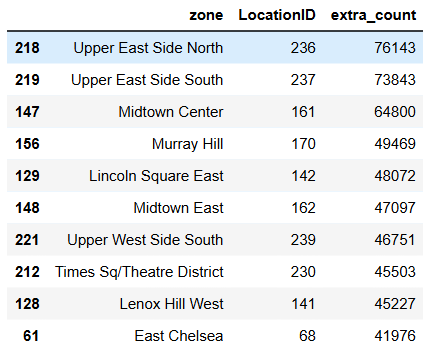

Relation of surcharge on trip distance and fare amount<br>

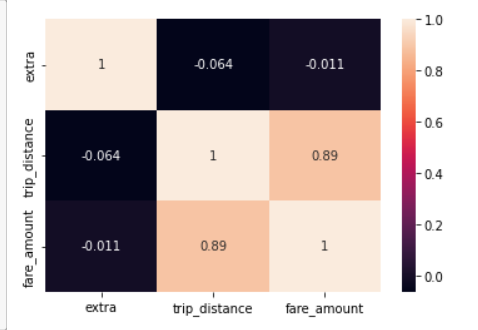

Negative correlation between <br>
1. extra amount/fare amount<br>
2. extra amount/trip distance<br>
3. extra amount/fare amount<br>




In [239]:
surchrge_zone_df = merged_df[merged_df['extra'] > 0]

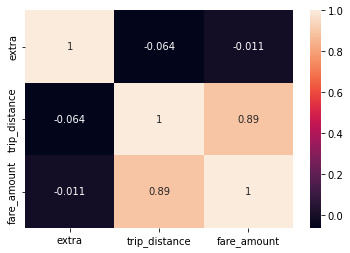

In [240]:
sns.heatmap(surchrge_zone_df[["extra","trip_distance","fare_amount"]].corr(),annot=True)
plt.show()

## **4** Conclusion
<font color = red>[15 marks]</font> <br>

### **4.1** Final Insights and Recommendations
<font color = red>[15 marks]</font> <br>

Conclude your analyses here. Include all the outcomes you found based on the analysis.

Based on the insights, frame a concluding story explaining suitable parameters such as location, time of the day, day of the week etc. to be kept in mind while devising a strategy to meet customer demand and optimise supply.

**4.1.1** <font color = red>[5 marks]</font> <br>
Recommendations to optimize routing and dispatching based on demand patterns and operational inefficiencies

<b>[Sheeshma</b><br>

<b>Continously monitor the heavy traffic areas and choose short routes. Allocate taxi based on demanded hours and zones.
Set a strageric goal to increase operational efficiencies like smart detectors deployed on the taxi in case of any faulty machine. Introduce AI based system to monitor the changing demands, so that taxi allocation can be done from low demanded area to high demanded zones</b>

**4.1.2** <font color = red>[5 marks]</font> <br>

Suggestions on strategically positioning cabs across different zones to make best use of insights uncovered by analysing trip trends across time, days and months.

<b>[Sheeshma</b><br>

<b>Deplpoy more taxi's during evening hrs 18:00. Weekdays on Wednesday and Thursday's. During the month of MAY and OCT ie 2nd and 4th Quater. Add in the most demanded zone upper east side</b>

**4.1.3** <font color = red>[5 marks]</font> <br>
Propose data-driven adjustments to the pricing strategy to maximize revenue while maintaining competitive rates with other vendors.

<b>[Sheeshma</b><br>

<b>Introduce multi vendor mechanism to have competition, so that people can have better manage fare amount. Introduce free ride on certain range of first few rides. Or a discount on initial 2 months to understand the strength </b>